# <center> Noon Delta Strategy Analysis on DAX</center>

<center><b>Copyright Federico Bari - 24 February 2024 - fede72bari@gmail.com</b></center>
<br><br><b>Disclaimer</b>: This document is published solely for coding and statistical analysis learning purposes. It is not intended to suggest, promote, or stimulate any trading strategy. bsolutely avoid using the results and remarks presented in this document for actual trading purposes, as it may contain bugs and mistakes. Moreover, future market conditions could differ from historical data, potentially leading to significant trading losses. Any suggestion, error/bug detection, and improvement is welcome.

## Strategy Description

- between 9:00 and 12:00 of each day detect the max and min prices
- calculate the difference bwtween that max and min (delta)
- divide the delta by 3 (delta_div_3)
- calculate two new thresholds subtrackting delta_div_3 to max (max_minus_delta) and adding delta_div_3 to min (min_plus_delta)
- if the Open price at noon
    - is between max_minus_delta and max --> entry long, take profit at max, stop loss at min_plus_delta or min
    - is between min and min_plus_delta --> entry short, take profit at min, stop loss at max_minus_delta or max

## Libraries import

In [1]:
# ---------------------------------------------------------------------------
#                              Libraries Import
# ---------------------------------------------------------------------------

# autorelaad changed packages
%load_ext autoreload

%autoreload 2

# Multiprocessing
import multiprocessing

# Files Management
import gzip
import joblib
import glob
import csv

# Stocks Indicators
# import talib

# Time Management
import datetime
from datetime import datetime, timedelta, date
import time
import pytz
from pytz import timezone


# Math and Sci
import numpy as np
import math
from scipy.signal import argrelextrema
import random
from scipy.signal import find_peaks
from scipy.signal import argrelmax, argrelmin
from sklearn.preprocessing import StandardScaler
from scipy.integrate import simps
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.integrate import simps
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean


# Reporting
import plotly
from plotly.figure_factory import create_candlestick
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import plot
from matplotlib.pylab import rcParams
from xgboost import plot_tree
import seaborn as sns
from tabulate import tabulate
from IPython.display import HTML

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, LambdaCallback
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import SGD


# Optimization
from deap import base, creator, tools, algorithms

# Models Explainablity
#import shap
#import torch

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Data sources
import yfinance as yf

# Financial indicators
import talib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import and prepare data

### 1 minute TF 2020/2021

In [2]:
# load data from CSV
df = pd.read_csv(r'D:\Dropbox\TRADING\DATA\FDAX-Interactive Brokers-EUREX-Futures-Minute-Trade.csv')

# create a datetime type column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)


df['Volume'] = df['TotalVolume']

print("Dataframe column names:")
print(df.columns)
display(df.head(5))
display(df['Date'].head(5))

Dataframe column names:
Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TotalVolume',
       'datetime', 'Volume'],
      dtype='object')


Date      Time     Open     High      Low    Close  TotalVolume  \
0  02/01/2020  01:16:00  13174.0  13194.5  13171.5  13177.5           92   
1  02/01/2020  01:17:00  13177.0  13185.0  13177.0  13180.5           34   
2  02/01/2020  01:18:00  13180.5  13181.5  13179.0  13181.5           16   
3  02/01/2020  01:19:00  13181.5  13182.0  13180.0  13182.0            9   
4  02/01/2020  01:20:00  13182.0  13183.0  13180.5  13181.5           10   

             datetime  Volume  
0 2020-01-02 01:16:00      92  
1 2020-01-02 01:17:00      34  
2 2020-01-02 01:18:00      16  
3 2020-01-02 01:19:00       9  
4 2020-01-02 01:20:00      10

0    02/01/2020
1    02/01/2020
2    02/01/2020
3    02/01/2020
4    02/01/2020
Name: Date, dtype: object

#### 5 minutes TF - 2000-2024

In [2]:
df = pd.read_csv(r'D:\Dropbox\TRADING\DATA\dax-5m.csv', delimiter=';')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TotalVolume']

df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

chicago_timezone = pytz.timezone('America/Chicago')

# Converte la colonna datetime alla time zone di Chicago
df['datetime_chicago'] = df['datetime'].dt.tz_localize(chicago_timezone)

# Specifica la time zone di Roma
rome_timezone = pytz.timezone('Europe/Rome')

# Converte la colonna datetime alla time zone di Roma
df['datetime_rome'] = df['datetime_chicago'].dt.tz_convert(rome_timezone)
df['datetime'] = df['datetime_rome'].dt.tz_localize(None)

df['Volume'] = df['TotalVolume']

# corrupted data on this dates
date_threshold = pd.to_datetime('2001-10-08').date()
df = df[df['datetime'].dt.date != date_threshold]
date_threshold = pd.to_datetime('2004-01-12').date()
df = df[df['datetime'].dt.date != date_threshold]
date_threshold = pd.to_datetime('2004-01-13').date()
df = df[df['datetime'].dt.date != date_threshold]


print("Dataframe column names:")
print(df.columns)

Dataframe column names:
Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TotalVolume',
       'datetime', 'datetime_chicago', 'datetime_rome', 'Volume'],
      dtype='object')


# Create statistics dataframe

In [3]:
# Funzione per trovare gli indici di minimi o massimi relativi
def find_rel_extrema(data, comparator, tol):

    return len(argrelextrema(data.values, comparator, order=tol)[0])


def create_noon_strategy_statistics(df, 
                                    coeff_min_thrsd = 1, 
                                    coeff_max_thrsd = 1, 
                                    coeff_min_target = 1, 
                                    coeff_max_target = 1):
    
    
    if(coeff_min_thrsd >= 1.5):
        coeff_min_thrsd = 1.49
    if(coeff_min_thrsd <= 0.5):
        coeff_min_thrsd = 0.51
        
    if(coeff_max_thrsd >= 1.5):
        coeff_max_thrsd = 1.49
    if(coeff_max_thrsd <= 0.5):
        coeff_max_thrsd = 0.51
    
    # ---------------------------------------------------
    #        9:00 to 12:00 data analysis
    # ---------------------------------------------------
    df['time'] = df['datetime'].dt.time
    df['Date'] = df['datetime'].dt.date

    # Filtra le righe tra le ore 9:00 e 12:00
    df_9_to_12 = df[(df['datetime'].dt.hour >= 9) & (df['datetime'].dt.hour < 12)]


    # Maax di ogni giorno tra le 9:00 e le 12:00 con informazioni sul valore, l'indice e l'ora
    df_high_max = df_9_to_12.loc[df_9_to_12.groupby(df_9_to_12['datetime'].dt.date)['High'].idxmax()]
    df_high_max = df_high_max[['datetime', 'High', 'Date', 'time']].rename(columns={'datetime': '9_to_12_max_datetime', 
                                                                                    'High': '9_to_12_max', 
                                                                                    'time': '9_to_12_max_time'})
    df_high_max['9_to_12_max_idx'] = df_9_to_12.groupby(df_9_to_12['datetime'].dt.date)['High'].idxmax().values


    df_low_min = df_9_to_12.loc[df_9_to_12.groupby(df_9_to_12['datetime'].dt.date)['Low'].idxmin()]
    df_low_min = df_low_min[['datetime', 'Low', 'Date', 'time']].rename(columns={'datetime': '9_to_12_min_datetime', 
                                                                                 'Low': '9_to_12_min', 
                                                                                 'time': '9_to_12_min_time'})
    df_low_min['9_to_12_min_idx'] = df_9_to_12.groupby(df_9_to_12['datetime'].dt.date)['Low'].idxmin().values

    df_stats = df_high_max
    df_stats = pd.merge(df_stats, df_low_min, on='Date', how='left')
    df_stats['9_to_12_max_idx_minus_min_idx'] = df_high_max['9_to_12_max_idx'] - df_low_min['9_to_12_min_idx']

    # Calcola delta valori e periodi
    df_stats['9_to_12_delta'] = df_stats['9_to_12_max'] - df_stats['9_to_12_min']
    df_stats['9_to_12_min_max_period'] = df_stats['9_to_12_max_idx'] - df_stats['9_to_12_min_idx']
    df_stats['9_to_12_min_before_max'] = np.where(df_stats['9_to_12_min_max_period'] > 0, 1, -1)

    # Calcola un terzo della differenza
    df_stats['9_to_12_delta_div_3'] = df_stats['9_to_12_delta'] / 3

    # Sottrai un terzo della differenza dal massimo giornaliero
    df_stats['9_to_12_max_minus_delta'] = df_stats['9_to_12_max'] - df_stats['9_to_12_delta_div_3'] * coeff_max_thrsd

    # Somma un terzo della differenza al minimo giornaliero
    df_stats['9_to_12_min_plus_delta'] = df_stats['9_to_12_min'] + df_stats['9_to_12_delta_div_3'] * coeff_min_thrsd

    # Determina il prezzo dell'Open alle 12:00
    open_at_12_df = df[(df['datetime'].dt.hour == 12) & (df['datetime'].dt.minute == 0)][['Date', 'Time', 'datetime', 'Open']]

    # Converti il formato della data in open_at_12_df
    open_at_12_df['Date'] = open_at_12_df['datetime'].dt.date

    # Uniamo df_stats con open_at_12_df sulla colonna 'Date'
    merged_df = pd.merge(df_stats, open_at_12_df[['Date','Open']], on='Date', how='left')


    # # Assegna i risultati alle colonne di df_stats
    df_stats['open_at_12'] = merged_df['Open']


    # Crea colonna 'forecast' basata sulla condizione specificata
    df_stats['forecast'] = 'undetermined'
    df_stats.loc[df_stats['open_at_12'] > df_stats['9_to_12_max_minus_delta'], 'forecast'] = 'long'
    df_stats.loc[df_stats['open_at_12'] < df_stats['9_to_12_min_plus_delta'], 'forecast'] = 'short'
    df_stats.loc[df_stats['open_at_12'] > df_stats['9_to_12_max'], 'forecast'] = 'over'
    df_stats.loc[df_stats['open_at_12'] < df_stats['9_to_12_min'], 'forecast'] = 'under'

    # --------------------------------------------
    # market behaviour
    # --------------------------------------------

    # Calcola le differenze richieste
    df_9_to_12['CO'] = df_9_to_12['Close'] - df_9_to_12['Open']
    df_9_to_12['HL'] = df_9_to_12['High'] - df_9_to_12['Low']
    df_9_to_12['CO_div_Volume'] = df_9_to_12['CO'] / df_9_to_12['Volume']
    df_9_to_12['HL_div_Volume'] = df_9_to_12['HL'] / df_9_to_12['Volume']
    df_9_to_12['Close_delta'] = df_9_to_12['Close'] - df_9_to_12['Close'].shift(1)
    df_9_to_12['High_delta'] = df_9_to_12['High'] - df_9_to_12['High'].shift(1)
    df_9_to_12['Low_delta'] = df_9_to_12['Low'] - df_9_to_12['Low'].shift(1)
    
    

    # Creazione del DataFrame df_behaviour
    grouped_data = df_9_to_12.groupby(df_9_to_12['datetime'].dt.date)

    # Calcola le medie
    df_behaviour = grouped_data[['CO', 'HL', 'Close_delta', 'High_delta', 'Low_delta']].mean().reset_index()
    df_behaviour = df_behaviour.rename(columns={'CO': 'CO_mean', 'HL': 'HL_mean', 'Close_delta': 'Close_delta_mean',
                                                'High_delta': 'High_delta_mean', 'Low_delta': 'Low_delta_mean',
                                                'datetime': 'Date'})

    # Calcola la deviazione standard
    df_behaviour_std = grouped_data[['CO', 'HL', 'Close_delta', 'High_delta', 'Low_delta']].std().reset_index()
    df_behaviour_std = df_behaviour_std.rename(columns={'CO': 'CO_std', 'HL': 'HL_std', 'Close_delta': 'Close_delta_std',
                                                        'High_delta': 'High_delta_std', 'Low_delta': 'Low_delta_std',
                                                        'datetime': 'Date'})

    # Unisci i DataFrame
    df_behaviour = pd.merge(df_behaviour, df_behaviour_std, on='Date')

    df_stats = pd.merge(df_stats, df_behaviour, on='Date', how='left')
    
    
    # -------------- CO stats --------------


    # Creazione delle colonne 'pos_CO' e 'neg_CO'
    df_9_to_12['pos_CO'] = np.where(df_9_to_12['CO'] > 0, 1, 0)
    df_9_to_12['neg_CO'] = np.where(df_9_to_12['CO'] < 0, 1, 0)

    # Raggruppamento per data
    grouped_data_9_to_12 = df_9_to_12.groupby(df_9_to_12['Date']) #datetime'].dt.date)

    # Calcolo delle occorrenze per ogni giorno tra le 9 e le 12
    occurrences_count = grouped_data_9_to_12[['pos_CO', 'neg_CO']].sum().reset_index()

    mean_std_pos_CO = grouped_data_9_to_12.apply(
        lambda x: x[x['pos_CO'] == 1]['CO'].agg(['mean', 'std'])
    ).rename(columns={'mean': 'pos_CO_mean', 'std': 'pos_CO_std'})

    # Resetta l'indice
    mean_std_pos_CO = mean_std_pos_CO.reset_index()

    mean_std_neg_CO = grouped_data_9_to_12.apply(
        lambda x: x[x['neg_CO'] == 1]['CO'].agg(['mean', 'std'])
    ).rename(columns={'mean': 'neg_CO_mean', 'std': 'neg_CO_std'})

    # Resetta l'indice
    mean_std_neg_CO = mean_std_neg_CO.reset_index()

    # Unione dei risultati
    df_stats = pd.merge(df_stats, occurrences_count, on='Date', how='left') #left_on='Date', right_on='datetime', how='left')
    df_stats = pd.merge(df_stats, mean_std_pos_CO, on='Date', how='left')
    df_stats = pd.merge(df_stats, mean_std_neg_CO, on='Date', how='left')
    
    
    # -------------- CO / volume stats --------------        
    
    pos_CO_div_volume = grouped_data_9_to_12.apply(
        lambda x: x[x['pos_CO'] == 1]['CO_div_Volume'].agg(['mean', 'std'])
    ).rename(columns={'mean': 'pos_CO_div_volume_mean', 'std': 'pos_CO_div_volume_std'})
    pos_CO_div_volume = pos_CO_div_volume.reset_index()

    neg_CO_div_volume = grouped_data_9_to_12.apply(
        lambda x: x[x['neg_CO'] == 1]['CO_div_Volume'].agg(['mean', 'std'])
    ).rename(columns={'mean': 'neg_CO_div_volume_mean', 'std': 'neg_CO_div_volume_std'})
    neg_CO_div_volume = neg_CO_div_volume.reset_index()


    df_stats = pd.merge(df_stats, pos_CO_div_volume, on='Date', how='left')
    df_stats = pd.merge(df_stats, neg_CO_div_volume, on='Date', how='left')
    
    
    # -------------- HL / volume stats --------------
    
    pos_CO_HL_div_volume = grouped_data_9_to_12.apply(
        lambda x: x[x['pos_CO'] == 1]['HL_div_Volume'].agg(['mean', 'std'])
    ).rename(columns={'mean': 'pos_CO_HL_div_volume_mean', 'std': 'pos_CO_HL_div_volume_std'})
    pos_CO_HL_div_volume = pos_CO_HL_div_volume.reset_index()

    neg_CO_HL_div_volume = grouped_data_9_to_12.apply(
        lambda x: x[x['neg_CO'] == 1]['HL_div_Volume'].agg(['mean', 'std'])
    ).rename(columns={'mean': 'neg_CO_HL_div_volume_mean', 'std': 'neg_CO_HL_div_volume_std'})
    neg_CO_HL_div_volume = neg_CO_HL_div_volume.reset_index()


    df_stats = pd.merge(df_stats, pos_CO_HL_div_volume, on='Date', how='left')
    df_stats = pd.merge(df_stats, neg_CO_HL_div_volume, on='Date', how='left')
    
    
    # -------------- Volumes --------------
    
    pos_CO_volume = grouped_data_9_to_12.apply(
        lambda x: x[x['pos_CO'] == 1]['Volume'].agg(['sum'])
    ).rename(columns={'sum': 'pos_CO_volume'})
    pos_CO_volume = pos_CO_volume.reset_index()
    
    neg_CO_volume = grouped_data_9_to_12.apply(
        lambda x: x[x['neg_CO'] == 1]['Volume'].agg(['sum'])
    ).rename(columns={'sum': 'neg_CO_volume'})
    neg_CO_volume = neg_CO_volume.reset_index()
    
    
    df_stats = pd.merge(df_stats, pos_CO_volume, on='Date', how='left')
    df_stats = pd.merge(df_stats, neg_CO_volume, on='Date', how='left')
    


    
    # ---------------------------------------------------------------------------
    #     Find relative mins and maxes of Highs and Lows between 9:00 and 12:00
    # ---------------------------------------------------------------------------
    

    # Applica le funzioni personalizzate per trovare minimi e massimi relativi e assegna i risultati a df_stats
    # df_stats['9_to_12_rel_mins_number'] 
    df_9_to_12_rel_mins_number = df_9_to_12.groupby(df_9_to_12['datetime'].dt.date)['Low'].apply(lambda x: find_rel_extrema(x, np.less, tol=1))
    # df_stats['9_to_12_rel_maxes_number'] 
    df_9_to_12_rel_maxes_number = df_9_to_12.groupby(df_9_to_12['datetime'].dt.date)['High'].apply(lambda x: find_rel_extrema(x, np.greater, tol=1))

    # Reset dell'indice (rimuove l'indice corrente e trasforma "datetime" in una colonna)
    df_9_to_12_rel_mins_number = df_9_to_12_rel_mins_number.reset_index(drop=False)
    df_9_to_12_rel_maxes_number = df_9_to_12_rel_maxes_number.reset_index(drop=False)

    # Rinomina la colonna "datetime" in "Date"
    df_9_to_12_rel_mins_number.rename(columns={'datetime': 'Date'}, inplace=True)
    df_9_to_12_rel_mins_number.rename(columns={'Low': '9_to_12_rel_mins_number'}, inplace=True)
#     df_9_to_12_rel_mins_number['Date'] = pd.to_datetime(df_9_to_12_rel_mins_number['Date'])
    df_9_to_12_rel_maxes_number.rename(columns={'datetime': 'Date'}, inplace=True)
    df_9_to_12_rel_maxes_number.rename(columns={'High': '9_to_12_rel_maxes_number'}, inplace=True)
#     df_9_to_12_rel_maxes_number['Date'] = pd.to_datetime(df_9_to_12_rel_maxes_number['Date'])


    # Esegui la fusione (merge) su df_stats
    df_stats = pd.merge(df_stats, df_9_to_12_rel_mins_number[['Date', '9_to_12_rel_mins_number']], on='Date', how='left')
    df_stats = pd.merge(df_stats, df_9_to_12_rel_maxes_number[['Date', '9_to_12_rel_maxes_number']], on='Date', how='left')


    # ---------------------------------------------------
    #        after 12:00 data analysis
    # ---------------------------------------------------

    # Filter by time ranges
    df_after_12 = df[(df['datetime'].dt.hour >= 12)]

    # keep complete datetime even after aggregation
    df_after_12['datetime_copy'] = df_after_12['datetime']

    # Creazione di una copia della colonna 'datetime' come colonna separata
    df_after_12['time'] = df_after_12['datetime'].dt.time


    # Min/max di ogni giorno dopo le 12:00 con informazioni sul valore, l'indice e l'ora
    df_high_max = df_after_12.loc[df_after_12.groupby(df_after_12['datetime'].dt.date)['High'].idxmax()]
    df_high_max = df_high_max[['datetime', 'High', 'Date', 'time']].rename(columns={'datetime': 'max_datetime', 
                                                                                    'High': 'max_value', 
                                                                                    'time': 'max_time'})

    df_low_min = df_after_12.loc[df_after_12.groupby(df_after_12['datetime'].dt.date)['Low'].idxmin()]
    df_low_min = df_low_min[['datetime', 'Low', 'Date', 'time']].rename(columns={'datetime': 'min_datetime', 
                                                                                 'Low': 'min_value', 
                                                                                 'time': 'min_time'})

    # Aggiungi colonne di indice
    df_high_max['max_index'] = df_after_12.groupby(df_after_12['datetime'].dt.date)['High'].idxmax().values
    df_low_min['min_index'] = df_after_12.groupby(df_after_12['datetime'].dt.date)['Low'].idxmin().values

    # display(df_high_max.head(5))


    # Merge dei dataframe senza replicare colonne comuni
    df_after_12_min_max = pd.merge(df_high_max, df_low_min, on='Date', )

    # Elimina le colonne 'max_datetime' e 'min_datetime'
    # df_after_13_min_max = df_after_13_min_max.drop(['max_datetime', 'min_datetime'], axis=1)

    # Rinomina le colonne come richiesto
    df_after_12_min_max.rename(columns={'max_value': 'after_12_max',
                                        'max_index': 'after_12_max_idx',
                                        'max_time': 'after_12_max_time',
                                        'max_datetime': 'after_12_max_datetime',
                                        'min_value': 'after_12_min',
                                        'min_index': 'after_12_min_idx',
                                        'min_time': 'after_12_min_time',
                                        'min_datetime': 'after_12_min_datetime'},
                               inplace=True)


    # Unisci il risultato nel DataFrame df_stats
    df_stats = pd.merge(df_stats, df_after_12_min_max, on='Date', how='left')


    df_stats['gain'] = 0

    # Se forecast è 'long', verifica la condizione specificata
    df_stats['gain'] = np.where(df_stats['forecast'] == 'long', np.where(df_stats['after_12_max'] >= df_stats['9_to_12_max'], 1, -1), df_stats['gain']).astype(int)

    # Se forecast è 'short', verifica la condizione specificata
    df_stats['gain'] = np.where(df_stats['forecast'] == 'short', np.where(df_stats['after_12_min'] <= df_stats['9_to_12_min'], 1, -1), df_stats['gain']).astype(int)

    df_stats['binary_target_long_reached'] = np.where(df_stats['after_12_max'] >= df_stats['9_to_12_max'], 1, 0)
    df_stats['binary_target_short_reached'] = np.where(df_stats['after_12_min'] <= df_stats['9_to_12_min'], 1, 0)



    # Search min value of Low after 12 and before max value of High after 12 of the same day

    # Mappa i valori di after_12_max_time nel DataFrame df
    df['after_12_max_time'] = df['datetime'].dt.date.map(df_stats.set_index('Date')['after_12_max_time'])

    # Filtra le righe tra le ore 12 e after_12_max_time
    filtered_df = df[(df['datetime'].dt.hour >= 12) & (df['datetime'].dt.time <= df['after_12_max_time'])]

    # Crea un raggruppamento per giorni distinti dei valori del Low
    grouped_low = filtered_df.groupby(filtered_df['datetime'].dt.date)['Low']

    # Estrai il Low minimo per ogni giorno dal raggruppamento
    min_low_per_day = grouped_low.idxmin()

    # Creare un nuovo DataFrame con valore, orario e indice del Low minimo per ogni giorno
    df_min_low_per_day = df.loc[min_low_per_day, ['Low', 'datetime']].rename(columns={'Low': 'after_12_min_before_max', 
                                                                                      'datetime': 'after_12_min_before_max_datetime'})
    df_min_low_per_day['after_12_min_before_max_time'] = df_min_low_per_day['after_12_min_before_max_datetime'].dt.time
    
    df_min_low_per_day['after_12_min_before_max_idx'] = min_low_per_day.values
    df_min_low_per_day['Date'] = df_min_low_per_day['after_12_min_before_max_datetime'].dt.date



    # Unisci il risultato nel DataFrame df_stats
    df_stats = pd.merge(df_stats, df_min_low_per_day, on='Date', how='left')
    
    # After 12:00 full swing between 9:00-12:00 min/max
    df_stats['after_12_full_swing'] = (df_stats['binary_target_long_reached'] == 1) & (df_stats['binary_target_short_reached'] == 1)
    df_stats['after_12_full_swing'] = df_stats['after_12_full_swing'].astype(int)
    
    
    # ----------------------------------------------
    #     Count min/max cross occurencies number
    # ---------------------------------------------- 

    df_after_12 = df[df['datetime'].dt.hour >= 12]


    # Unisci df_stats con df_after_12 sulla colonna 'Date'
    merged_df = pd.merge(df_stats, df_after_12, on='Date')

    # Conta le candele che superano il massimo tra le 9 e le 12
    max_cross_count = merged_df[(merged_df['High'] >= merged_df['9_to_12_max']) & (merged_df['Low'] < merged_df['9_to_12_max'])].groupby('Date').size().reset_index(name='max_cross_count')

    # Conta le candele che sono al di sotto del minimo tra le 9 e le 12
    min_cross_count = merged_df[(merged_df['Low'] <= merged_df['9_to_12_min']) & (merged_df['High'] > merged_df['9_to_12_min'])].groupby('Date').size().reset_index(name='min_cross_count')

    # Unisci i risultati in df_stats
    df_stats = pd.merge(df_stats, max_cross_count, on='Date', how='left').fillna(0)#.astype(int)
    df_stats = pd.merge(df_stats, min_cross_count, on='Date', how='left').fillna(0)#.astype(int)


    # ----------------------------------------------
    #     cross periods calculations
    # ---------------------------------------------- 


    # Deltas
    df_stats['after_12_min_max_delta'] = df_stats['after_12_max'] - df_stats['after_12_min']
    df_stats['after_12_min_max_delta_day_-1'] = df_stats['after_12_min_max_delta'].shift(1)
    df_stats['after_12_min_max_delta_day_-2'] = df_stats['after_12_min_max_delta'].shift(2)
    
    df_stats['after_12_min_before_max_max_delta'] = df_stats['after_12_max'] - df_stats['after_12_min_before_max']
    df_stats['after_12_min_before_max_max_delta_-1'] = df_stats['after_12_min_before_max_max_delta'].shift(1)
    df_stats['after_12_min_before_max_max_delta_-2'] = df_stats['after_12_min_before_max_max_delta'].shift(2)


    # falling positions
    df_stats['after_12_max_minus_12_Open'] = df_stats['after_12_max'] - df_stats['open_at_12']
    df_stats['after_12_max_minus_9_to_12_max'] = df_stats['after_12_max'] - df_stats['9_to_12_max']
    df_stats['after_12_max_minus_9_to_12_min'] = df_stats['after_12_max'] - df_stats['9_to_12_min']

    df_stats['after_12_min_minus_12_Open'] = df_stats['after_12_min'] - df_stats['open_at_12']
    df_stats['after_12_min_minus_9_to_12_max'] = df_stats['after_12_min'] - df_stats['9_to_12_max']
    df_stats['after_12_min_minus_9_to_12_min'] = df_stats['after_12_min'] - df_stats['9_to_12_min']

    df_stats['after_12_min_before_max_minus_12_Open'] = df_stats['after_12_min_before_max'] - df_stats['open_at_12']
    df_stats['after_12_min_before_max_9_to_12_max'] = df_stats['after_12_min_before_max'] - df_stats['9_to_12_max']
    df_stats['after_12_min_before_max_9_to_12_min'] = df_stats['after_12_min_before_max'] - df_stats['9_to_12_min']

    # Crea le nuove colonne con valori 1 o -1 basati sulle condizioni specificate
    df_stats['after_12_max_>_12_Open'] = np.where(df_stats['after_12_max_minus_12_Open'] > 0, 1, -1)
    df_stats['after_12_max_>_9_to_12_max'] = np.where(df_stats['after_12_max_minus_9_to_12_max'] > 0, 1, -1)
    df_stats['after_12_max_>_9_to_12_min'] = np.where(df_stats['after_12_max_minus_9_to_12_min'] > 0, 1, -1)                                                                           

    df_stats['after_12_min_>_12_Open'] = np.where(df_stats['after_12_min_minus_12_Open'] > 0, 1, -1)
    df_stats['after_12_min_>_9_to_12_max'] = np.where(df_stats['after_12_min_minus_9_to_12_max'] > 0, 1, -1)
    df_stats['after_12_min_>_9_to_12_min'] = np.where(df_stats['after_12_min_minus_9_to_12_min'] > 0, 1, -1)

    df_stats['after_12_min_before_max_>_12_Open'] = np.where(df_stats['after_12_min_before_max_minus_12_Open'] > 0, 1, -1)
    df_stats['after_12_min_before_max_>_9_to_12_max'] = np.where(df_stats['after_12_min_before_max_9_to_12_max'] > 0, 1, -1)
    df_stats['after_12_min_before_max_>_9_to_12_min'] = np.where(df_stats['after_12_min_before_max_9_to_12_min'] > 0, 1, -1)


    # Distribution min/max after 13:00 in 30 minutes long bins
    df_stats['after_12_max_datetime'] = pd.to_datetime(df_stats['after_12_max_datetime'])
    df_stats['after_12_min_datetime'] = pd.to_datetime(df_stats['after_12_min_datetime'])

    # period between last(min or max 9_to_12) and first(min or max after_12)
    df_stats['9_to_12_max_idx_to_after_12_max_idx'] = df_stats['after_12_max_idx'] - df_stats['9_to_12_max_idx'] 
    df_stats['9_to_12_min_idx_to_after_12_max_idx'] = df_stats['after_12_max_idx'] - df_stats['9_to_12_min_idx'] 
    df_stats['9_to_12_max_idx_to_after_12_min_idx'] = df_stats['after_12_min_idx'] - df_stats['9_to_12_max_idx'] 
    df_stats['9_to_12_max_idx_to_after_12_min_idx'] = df_stats['after_12_min_idx'] - df_stats['9_to_12_max_idx'] 

    df_stats['open_at_12_rel_distance'] = (df_stats['9_to_12_max'] - df_stats['open_at_12']) / df_stats['9_to_12_delta'] 


    df_stats['open_at_12_rel_distance_day_-1'] =  df_stats['open_at_12_rel_distance'].shift(1)
    df_stats['open_at_12_rel_distance_day_-2'] =  df_stats['open_at_12_rel_distance'].shift(2)

    df_stats['binary_target_long_reached_day_-1'] =  df_stats['binary_target_long_reached'].shift(1)
    df_stats['binary_target_long_reached_day_-2'] =  df_stats['binary_target_long_reached'].shift(2)

    df_stats['binary_target_short_reached_day_-1'] =  df_stats['binary_target_short_reached'].shift(1)
    df_stats['binary_target_short_reached_day_2'] =  df_stats['binary_target_short_reached'].shift(2)

    df_stats['pos_CO_div_volume_mean_day_-1'] =  df_stats['pos_CO_div_volume_mean'].shift(1)
    df_stats['pos_CO_div_volume_mean_day_-2'] =  df_stats['pos_CO_div_volume_mean'].shift(2)
    df_stats['pos_CO_div_volume_std_day_-1'] =  df_stats['pos_CO_div_volume_std'].shift(1)
    df_stats['pos_CO_div_volume_std_day_-2'] =  df_stats['pos_CO_div_volume_std'].shift(2)
    
    df_stats['neg_CO_div_volume_mean_day_-1'] =  df_stats['neg_CO_div_volume_mean'].shift(1)
    df_stats['neg_CO_div_volume_mean_day_-2'] =  df_stats['neg_CO_div_volume_mean'].shift(2)
    df_stats['neg_CO_div_volume_std_day_-1'] =  df_stats['neg_CO_div_volume_std'].shift(1)
    df_stats['neg_CO_div_volume_std_day_-2'] =  df_stats['neg_CO_div_volume_std'].shift(2)
    
    df_stats['pos_CO_HL_div_volume_mean_day_-1'] =  df_stats['pos_CO_HL_div_volume_mean'].shift(1)
    df_stats['pos_CO_HL_div_volume_mean_day_-2'] =  df_stats['pos_CO_HL_div_volume_mean'].shift(2)
    df_stats['pos_CO_HL_div_volume_std_day_-1'] =  df_stats['pos_CO_HL_div_volume_std'].shift(1)
    df_stats['pos_CO_HL_div_volume_std_day_-2'] =  df_stats['pos_CO_HL_div_volume_std'].shift(2)

    df_stats['neg_CO_HL_div_volume_mean_day_-1'] =  df_stats['neg_CO_HL_div_volume_mean'].shift(1)
    df_stats['neg_CO_HL_div_volume_mean_day_-2'] =  df_stats['neg_CO_HL_div_volume_mean'].shift(2)
    df_stats['neg_CO_HL_div_volume_std_day_-1'] =  df_stats['neg_CO_HL_div_volume_std'].shift(1)
    df_stats['neg_CO_HL_div_volume_std_day_-2'] =  df_stats['neg_CO_HL_div_volume_std'].shift(2)

    df_stats['pos_CO_volume_day_-1'] =  df_stats['pos_CO_volume'].shift(1)
    df_stats['pos_CO_volume_day_-2'] =  df_stats['pos_CO_volume'].shift(2)
    df_stats['neg_CO_volume_day_-1'] =  df_stats['neg_CO_volume'].shift(1)
    df_stats['neg_CO_volume_day_-2'] =  df_stats['neg_CO_volume'].shift(2)


    # --------------------------------------------------------
    #     Create columns with data of previous 2 days
    # --------------------------------------------------------

    # Supponendo che la colonna 'Date' sia nel formato datetime
    df_stats['Date'] = pd.to_datetime(df_stats['Date'])

    # Copia il dataframe originale
    df_combined = df_stats.copy()

    # Copia la data delle due righe precedenti
    df_combined['Date_day_-2'] = df_combined['Date'].shift(2)

    # Unisci i valori dei due giorni precedenti
    df_combined = pd.merge(df_combined, df_stats, left_on='Date_day_-2', right_on='Date', suffixes=('', '_day_-2'), how='left')

    # Copia la data della riga precedente
    df_combined['Date_day_-1'] = df_combined['Date'].shift(1)

    # Unisci i valori del giorno precedente
    df_combined = pd.merge(df_combined, df_stats, left_on='Date_day_-1', right_on='Date', suffixes=('', '_day_-1'), how='left')

    # Rimuovi colonne duplicate
    df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]

    df_stats = df_combined

    # df_stats['gain'] = df_stats[['gain']].apply(lambda x: x.astype(int) if not x.isna().all() else x)
    df_stats['gain'] = df_stats['gain'].apply(lambda x: int(x) if pd.notna(x) and x not in [np.inf, -np.inf] else x)
    df_stats['gain_day_-1'] = df_stats['gain_day_-1'].apply(lambda x: int(x) if pd.notna(x) and x not in [np.inf, -np.inf] else x)
    df_stats['gain_day_-2'] = df_stats['gain_day_-2'].apply(lambda x: int(x) if pd.notna(x) and x not in [np.inf, -np.inf] else x)


    # --------------------------------------------------------
    #     Create columns with data of previous 2 days
    # --------------------------------------------------------

    # Creazione delle nuove colonne
    df_stats['9_to_12_max_minus_9_to_12_max_day_-1'] = df_stats['9_to_12_max'] - df_stats['9_to_12_max_day_-1']
    df_stats['9_to_12_max_minus_9_to_12_max_day_-2'] = df_stats['9_to_12_max'] - df_stats['9_to_12_max_day_-2']
    df_stats['9_to_12_max_minus_9_to_12_min_day_-1'] = df_stats['9_to_12_max'] - df_stats['9_to_12_min_day_-1']
    df_stats['9_to_12_max_minus_9_to_12_min_day_-2'] = df_stats['9_to_12_max'] - df_stats['9_to_12_min_day_-2']

    df_stats['9_to_12_min_minus_9_to_12_max_day_-1'] = df_stats['9_to_12_min'] - df_stats['9_to_12_max_day_-1']
    df_stats['9_to_12_min_minus_9_to_12_max_day_-2'] = df_stats['9_to_12_min'] - df_stats['9_to_12_max_day_-2']
    df_stats['9_to_12_min_minus_9_to_12_min_day_-1'] = df_stats['9_to_12_min'] - df_stats['9_to_12_min_day_-1']
    df_stats['9_to_12_min_minus_9_to_12_min_day_-2'] = df_stats['9_to_12_min'] - df_stats['9_to_12_min_day_-2']

    df_stats['9_to_12_max_minus_after_12_max_day_-1'] = df_stats['9_to_12_max'] - df_stats['after_12_max_day_-1']
    df_stats['9_to_12_max_minus_after_12_max_day_-2'] = df_stats['9_to_12_max'] - df_stats['after_12_max_day_-2']
    df_stats['9_to_12_max_minus_after_12_min_day_-1'] = df_stats['9_to_12_max'] - df_stats['after_12_min_day_-1']
    df_stats['9_to_12_max_minus_after_12_min_day_-2'] = df_stats['9_to_12_max'] - df_stats['after_12_min_day_-2']

    df_stats['9_to_12_min_minus_after_12_max_day_-1'] = df_stats['9_to_12_min'] - df_stats['after_12_max_day_-1']
    df_stats['9_to_12_min_minus_after_12_max_day_-2'] = df_stats['9_to_12_min'] - df_stats['after_12_max_day_-2']
    df_stats['9_to_12_min_minus_after_12_min_day_-1'] = df_stats['9_to_12_min'] - df_stats['after_12_min_day_-1']
    df_stats['9_to_12_min_minus_after_12_min_day_-2'] = df_stats['9_to_12_min'] - df_stats['after_12_min_day_-2']

    df_stats['9_to_12_delta_div_9_to_12_delta_day_-1'] = df_stats['9_to_12_delta'] / df_stats['9_to_12_delta_day_-1']
    df_stats['9_to_12_delta_div_9_to_12_delta_day_-2'] = df_stats['9_to_12_delta'] / df_stats['9_to_12_delta_day_-2']
    df_stats['9_to_12_delta_div_after_12_min_max_delta_day_-1'] = df_stats['9_to_12_delta'] / df_stats['after_12_min_max_delta_day_-1']
    df_stats['9_to_12_delta_div_after_12_min_max_delta_day_-2'] = df_stats['9_to_12_delta'] / df_stats['after_12_min_max_delta_day_-2']

    
    df_stats['after_12_max_minus_9_to_12_max_day_-1'] = df_stats['after_12_max_minus_9_to_12_max'].shift(1)
    df_stats['after_12_max_minus_9_to_12_max_day_-2'] = df_stats['after_12_max_minus_9_to_12_max'].shift(2)
    
    df_stats['after_12_min_minus_9_to_12_min_day_-1'] = df_stats['after_12_min_minus_9_to_12_min'].shift(1)
    df_stats['after_12_min_minus_9_to_12_min_day_-2'] = df_stats['after_12_min_minus_9_to_12_min'].shift(2)
    
    df_stats['9_to_12_max_idx_minus_min_idx_day_-1'] = df_stats['9_to_12_max_idx_minus_min_idx'].shift(1)
    df_stats['9_to_12_max_idx_minus_min_idx_day_-2'] = df_stats['9_to_12_max_idx_minus_min_idx'].shift(2)
    
    # Aggiungi le colonne 'weekly_day_numeric' e 'month_numeric' a df_stats
    df_stats['weekly_day'] = df_stats['Date'].dt.weekday
    df_stats['month'] = df_stats['Date'].dt.month

    return df_stats

df_stats = create_noon_strategy_statistics(df, coeff_min_thrsd = 1, coeff_max_thrsd = 1.5)


In [4]:
df_stats.columns

Index(['9_to_12_max_datetime', '9_to_12_max', 'Date', '9_to_12_max_time',
       '9_to_12_max_idx', '9_to_12_min_datetime', '9_to_12_min',
       '9_to_12_min_time', '9_to_12_min_idx', '9_to_12_max_idx_minus_min_idx',
       ...
       '9_to_12_min_minus_after_12_max_day_-1',
       '9_to_12_min_minus_after_12_max_day_-2',
       '9_to_12_min_minus_after_12_min_day_-1',
       '9_to_12_min_minus_after_12_min_day_-2',
       '9_to_12_delta_div_9_to_12_delta_day_-1',
       '9_to_12_delta_div_9_to_12_delta_day_-2',
       '9_to_12_delta_div_after_12_min_max_delta_day_-1',
       '9_to_12_delta_div_after_12_min_max_delta_day_-2', 'weekly_day',
       'month'],
      dtype='object', length=349)

## Save precious data!

In [4]:
filename = 'Trading baktest - Noon Delta Strategy on DAX 5m - Statistics dataframe.csv' 

In [495]:
df_stats.to_csv(filename, index=False)

In [5]:
df_stats = pd.read_csv(filename)

## df_stats fast inspection

In [ ]:
display(df_stats.head(3))
display(df_stats.tail(3))

## Count forecast occurrences

In [4]:
occurrences = df_stats['forecast'].value_counts()
display(occurrences)

forecast
long            156
short            87
undetermined     47
under             1
Name: count, dtype: int64

<b>Remarks</b>
- the total number of cases considered in the analyzed period is 291
- in 70% number of cases the strategy generated an entry signal

## Count gain occurrences

In [6]:
def targets_reached_resutls(df_stats):
    # Conta le occorrenze di True e False per 'long'
    long_gain_counts = df_stats[df_stats['forecast'] == 'long']['gain'].value_counts()

    # Conta le occorrenze di True e False per 'short'
    short_gain_counts = df_stats[df_stats['forecast'] == 'short']['gain'].value_counts()

    results = {}

    results['long_targets_reached'] = long_gain_counts.get(1, 0)
    results['long_targets_not_reached'] = long_gain_counts.get(-1, 0)
    results['total_long_signals'] = results['long_targets_reached'] + results['long_targets_not_reached'] 
    
    results['short_targets_reached'] = short_gain_counts.get(1, 0)
    results['short_targets_not_reached'] = short_gain_counts.get(-1, 0)
    results['total_short_signals'] = results['short_targets_reached'] + results['short_targets_not_reached'] 
    
    results['total_targets_reached'] = results['long_targets_reached'] + results['short_targets_reached'] 
    results['total_targets_not_reached'] = results['long_targets_not_reached'] + results['short_targets_not_reached'] 
    results['tatal_signals'] = results['total_targets_reached'] + results['total_targets_not_reached']
    
    
    results['12_open_under_min'] = df_stats[df_stats['forecast'] == 'under'].shape[0]
    results['12_open_over_min'] = df_stats[df_stats['forecast'] == 'over'].shape[0]
    results['12_open_undetermined_area'] = df_stats[df_stats['forecast'] == 'undetermined'].shape[0]
    
    results['total_no_signals'] = results['12_open_under_min'] + results['12_open_over_min'] + results['12_open_undetermined_area']
    
    results['total_days'] = results['tatal_signals'] + results['total_no_signals']
    
    results['long_targets_reached_%'] = round(results['long_targets_reached'] / results['total_long_signals'] * 100 , 2)
    results['long_targets_not_reached_%'] = round(results['long_targets_not_reached'] / results['total_long_signals'] * 100 , 2)
    
    results['short_targets_reached_%'] = round(results['short_targets_reached'] / results['total_short_signals'] * 100 , 2)
    results['short_targets_not_reached_%'] = round(results['short_targets_not_reached'] / results['total_short_signals'] * 100 , 2)
    
    results['total_targets_reached_%'] = round(results['total_targets_reached'] / results['tatal_signals'] * 100 , 2)
    results['total_targets_not_reached_%'] = round(results['total_targets_not_reached'] / results['tatal_signals'] * 100 , 2)
         
    return results
    
targets_stats = targets_reached_resutls(df_stats)
display(targets_stats)

{'long_targets_reached': 2480,
 'long_targets_not_reached': 691,
 'total_long_signals': 3171,
 'short_targets_reached': 1526,
 'short_targets_not_reached': 347,
 'total_short_signals': 1873,
 'total_targets_reached': 4006,
 'total_targets_not_reached': 1038,
 'tatal_signals': 5044,
 '12_open_under_min': 6,
 '12_open_over_min': 3,
 '12_open_undetermined_area': 963,
 'total_no_signals': 972,
 'total_days': 6016,
 'long_targets_reached_%': 78.21,
 'long_targets_not_reached_%': 21.79,
 'short_targets_reached_%': 81.47,
 'short_targets_not_reached_%': 18.53,
 'total_targets_reached_%': 79.42,
 'total_targets_not_reached_%': 20.58}

## Display candelstick

In [51]:
from plotly.subplots import make_subplots

date_threshold1 = pd.to_datetime('2004-01-11')

date_threshold2 = pd.to_datetime('2004-01-14')

subset_df = df[(date_threshold1.date() < df['datetime'].dt.date) & (df['datetime'].dt.date < date_threshold2.date() )]


# Crea una subplot con il tipo di grafico Candlestick
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=['Candlestick Chart'])

fig.add_trace(go.Candlestick(x=subset_df['datetime'],
                open=subset_df['Open'],
                high=subset_df['High'],
                low=subset_df['Low'],
                close=subset_df['Close']))

# Aggiungi titoli e etichette dell'asse
fig.update_layout(title='Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)

# Visualizza il grafico
fig.show()


## Strategy PL calculation

- If the price reaches the high when forecast == long or the low when forecast == short, close the position in profit.
- If the price touches the opposite threshold, close at a loss.
- If a position is still opened at the end of the day, close at the value of the last Close of the day.

In [ ]:
# trading strategy callback functions


def simple_CDC_stretgy(self, data, args, index, current_open_volumes):

    current_row = data[data.index == index]
        
    current_date = current_row['datetime'].dt.date.iloc[0] 
    current_date_str = current_date.strftime('%Y-%m-%d')
    current_hour = current_row['datetime'].dt.hour.iloc[0] 
    current_minute = current_row['datetime'].dt.minute.iloc[0] 
    
    current_High = current_row['High'].iloc[0] 
    current_Low = current_row['Low'].iloc[0] 
    
    current_date_obj = datetime.strptime(current_date_str, '%Y-%m-%d')
    current_date_formatted = current_date_obj.strftime('%d/%m/%Y')
    
    if( ('current_date_formatted' not in self.custom_dict) | ('current_date_data' not in self.custom_dict) ):
        
        current_date_data = data.loc[data['Date'] == current_date_formatted]
        
        self.custom_dict = {'current_date_formatted': current_date_formatted,
                            'current_date_data': current_date_data            
                           }
        
    elif(current_date_formatted != self.custom_dict['current_date_formatted']):
        

        current_date_data = data.loc[data['Date'] == current_date_formatted]
        
        self.custom_dict = {'current_date_formatted': current_date_formatted,
                            'current_date_data': current_date_data            
                           }
        
    else:

        current_date_data = self.custom_dict['current_date_data']

        
    entry_price = data.iloc[index + 1]['Open']
#     entry_price = data.iloc[index ]['Open']

    # next is last element of the day, close at next Open price
    if(index == current_date_data.index[-2]):
        
        print(f'\tNext is last candle, current_open_volumes = {current_open_volumes}, entry_price = {entry_price}.')
        
        if(current_open_volumes > 0):
            
            print('Close long position last bar.')
            return -1
        
        elif(current_open_volumes < 0):
            
            print('Close short position last bar.')
            return 1
        
        else:
        
            return 0
    
    # it is 12:00! track open price, calculate thresholds and set stop loss and take profit; in case open the position
    if( (data.iloc[index]['datetime'].hour == 12) & 
        (data.iloc[index]['datetime'].minute == 0) ):
        
        print(f'\n\n12:00 of {current_date}, current_open_volumes = {current_open_volumes}')
        
        open_at_12 = data.iloc[index]['Open']

        from_9_to_12_data = current_date_data[ (current_date_data['datetime'].dt.hour >= 9) & (current_date_data['datetime'].dt.hour < 12) ]
        from_12_data = current_date_data[ current_date_data['datetime'].dt.hour >= 12 ]
        
        max_9_to_12 = from_9_to_12_data['High'].max()
        min_9_to_12 = from_9_to_12_data['Low'].min()
        
        delta_9_to_12 = max_9_to_12 - min_9_to_12
        delta_9_to_12_div_3 = delta_9_to_12 / 3
        
        max_9_to_12_minus_delta = max_9_to_12 - (delta_9_to_12_div_3 * 1)
        min_9_to_12_plus_delta = min_9_to_12 + (delta_9_to_12_div_3 * 1)
        
        self.max_9_to_12 = max_9_to_12
        self.min_9_to_12 = min_9_to_12
        delta_9_to_12 = self.max_9_to_12 = max_9_to_12 - self.min_9_to_12
        self.max_9_to_12_minus_delta = max_9_to_12_minus_delta
        self.min_9_to_12_plus_delta = min_9_to_12_plus_delta
        
        max_from_12_data = from_12_data['High'].max()
        min_from_12_data = from_12_data['Low'].min()
        
        print(f'\topen_at_12 = {open_at_12}')
        print(f'\tmax_from_12_data = {max_from_12_data}')
        print(f'\tmin_from_12_data = {min_from_12_data}')
        print(f'\tmax_9_to_12 = {max_9_to_12}')
        print(f'\tmax_9_to_12_minus_delta = {max_9_to_12_minus_delta}')
        print(f'\tmin_9_to_12_plus_delta = {min_9_to_12_plus_delta}')
        print(f'\tmin_9_to_12 = {min_9_to_12}')
        
        if(delta_9_to_12 < 2000):
        
            # long condition
            if( (open_at_12 >= max_9_to_12_minus_delta) & (open_at_12 < max_9_to_12) & (entry_price < max_9_to_12) ):

                ### probably wrong it shouild be open_at_12; anyway if entry_price is used it is needed a control that
                ### it is < than max_9_to_12 already existing for open_at_12
                self.take_profit = max_9_to_12 - entry_price 
                self.stop_loss = self.take_profit * 2 #self.take_profit * 3 # self.take_profit  # self.take_profit * 2 # 93 # abs(min_9_to_12 - entry_price)
                self.take_profit *= 1.5

                print(f'\tOPENED LONG POSITION, take_profit = {self.take_profit}, stop_loss = {self.stop_loss}')

                return 1

            # short condition
            elif( (open_at_12 <= min_9_to_12_plus_delta ) & (open_at_12 > min_9_to_12) & (entry_price > max_9_to_12) ):

                self.take_profit = entry_price - min_9_to_12
                self.stop_loss = self.take_profit * 2 #self.take_profit * 3 # self.take_profit  # self.take_profit * 2 # 93 # abs(min_9_to_12 - entry_price)
                self.take_profit *= 1.5

                print(f'\tOPENED SHORT POSITION, take_profit = {self.take_profit}, stop_loss = {self.stop_loss}')

                return -1
        
        
    return 0
    
    # stop loss and take porfit conditions verified in main backtest function 


## First backtest run

In [ ]:
from trdBackTest import trdBackTest

df = df.sort_values('datetime')

backTest = trdBackTest(
                         data = df,
                         ticker = 'DAX',
                         start_date = '02/01/2020',
                         end_date = '22/02/2021',
                         initial_equity = 10000,
                         strategy_callback = simple_CDC_stretgy,
                         open_col_name ='Open',
                         close_col_name = 'Close',
                         high_col_name = 'High',
                         low_col_name = 'Low',
                         datetime_is_index = False,
                         datetime_col_name = 'Date',
                         strategy_args = None,
                         enable_stop_loss = True,
                         stop_loss = 1.5, # ignored if redifined in the callback function
                         enable_take_profit = True,
                         take_profit = 1.5, # ignored if redifined in the callback function
                         max_random_slippage = None,
                         prevent_reentry_same_dir_last_stop_loss = False
                        )

trading_stats, positions = backTest.start_backtest()

## Save precious data!

In [407]:
positions.to_csv('Trading baktest - Noon Delta Strategy on DAX - Positions dataframe - Stop loss at 2TP - TP1-5.csv', index=False)

In [408]:

with open('Trading baktest - Noon Delta Strategy on DAX - Trading statistics dictionary - Stop loss at 2TP - TP1-5 .csv', 'w', newline='') as file_csv:
    # Crea un writer CSV
    csv_writer = csv.DictWriter(file_csv, fieldnames=trading_stats.keys())

    # Scrive l'intestazione
    csv_writer.writeheader()

    # Scrive i valori
    csv_writer.writerow(trading_stats)

## Plot statistical result curves

<AxesSubplot: xlabel='datetime'>

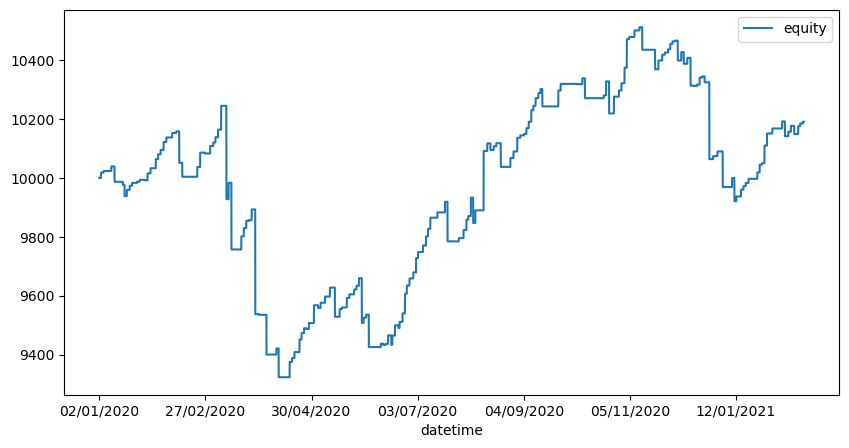

In [350]:
# positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

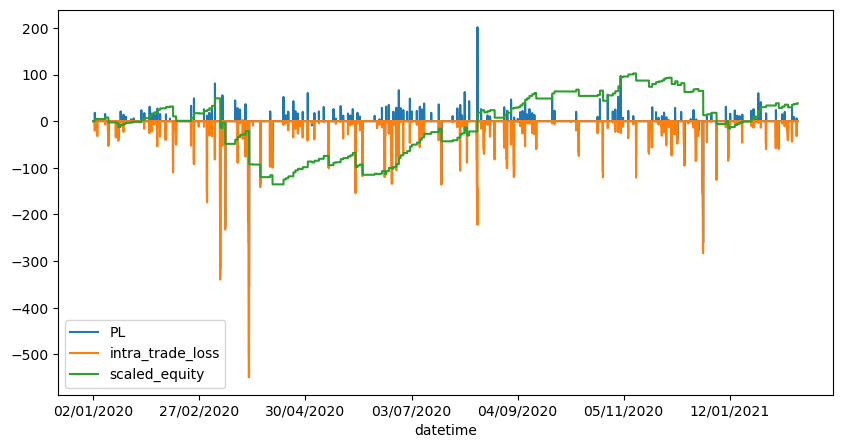

In [351]:
# positions['scaled_equity'] = (positions['equity'] - 10000) / 5
# positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

## Print statistical trading analysis

In [354]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 10191.0,
 'final_pl': 191.0,
 'number_of_operations': 179,
 'sum_in_trade_periods_stats': 25226,
 'mean_in_trade_periods_stats': 140.93,
 'std_in_trade_periods_stats': 173.08,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 306773,
 'mean_flat_periods_stats': 1704.29,
 'std_flat_periods_stats': 1359.28,
 'max_flat_periods_stats': 8836,
 'min_flat_periods_stats': 423,
 'total_profit': 3467.0,
 'number_profit_operations': 138,
 'percent_profit_operations': 77.09,
 'average_profit_trade': 25.1231884057971,
 'max_profit_single_operation': 201.5,
 'number_max_consecutive_profits': 14,
 'max_profit_consecutive_operations': 428.5,
 'number_profit_longs': 79,
 'percent_long_profit': 44.13,
 'number_loss_longs': 21,
 'percent_long_loss': 11.73,
 'total_loss': -3276.0,
 'number_loss_operations': 41,
 'p

## First results analysis

### Stop loss at 50 USD

<AxesSubplot: xlabel='datetime'>

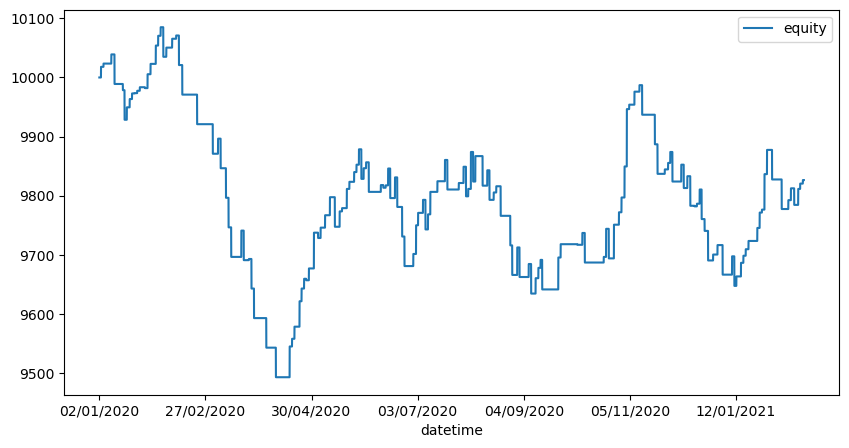

In [373]:
# positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

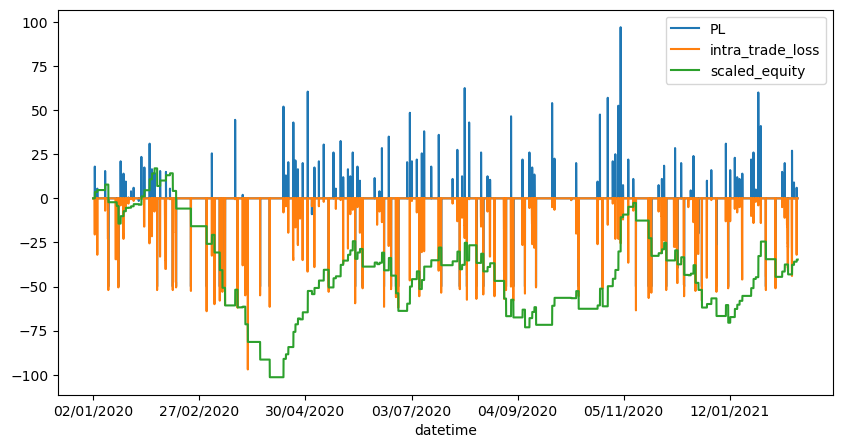

In [374]:
# positions['scaled_equity'] = (positions['equity'] - 10000) / 5
# positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [375]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 9826.5,
 'final_pl': -173.5,
 'number_of_operations': 161,
 'sum_in_trade_periods_stats': 14735,
 'mean_in_trade_periods_stats': 91.52,
 'std_in_trade_periods_stats': 126.26,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 317264,
 'mean_flat_periods_stats': 1958.42,
 'std_flat_periods_stats': 1557.27,
 'max_flat_periods_stats': 8904,
 'min_flat_periods_stats': 508,
 'total_profit': 2344.0,
 'number_profit_operations': 103,
 'percent_profit_operations': 63.98,
 'average_profit_trade': 22.75728155339806,
 'max_profit_single_operation': 97.0,
 'number_max_consecutive_profits': 10,
 'max_profit_consecutive_operations': 293.0,
 'number_profit_longs': 58,
 'percent_long_profit': 36.02,
 'number_loss_longs': 32,
 'percent_long_loss': 19.88,
 'total_loss': -2517.5,
 'number_loss_operations': 58,
 'pe

### Stop loss at 93 USD

<AxesSubplot: xlabel='datetime'>

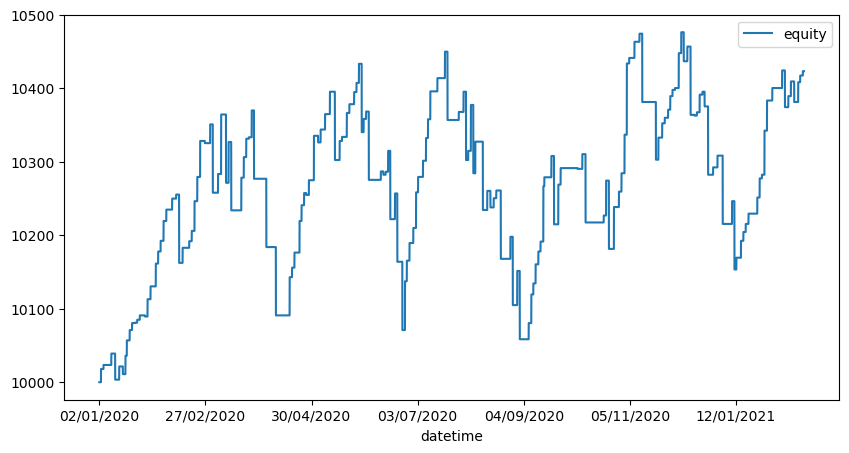

In [380]:
# positions.plot(x = 'datetime', yhttp://localhost:8888/notebooks/Noon%20Delta%20Strategy%20Analysis.ipynb#Stop-loss-at-93-USD = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

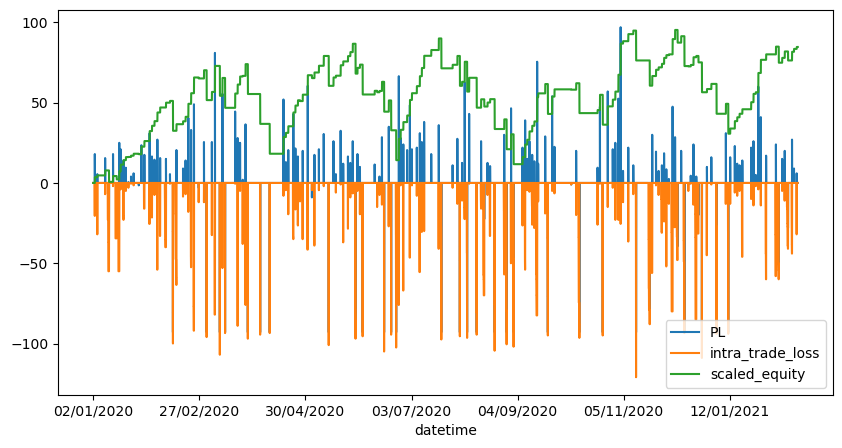

In [381]:
positions['scaled_equity'] = (positions['equity'] - 10000) / 5
positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [382]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 10423.5,
 'final_pl': 423.5,
 'number_of_operations': 179,
 'sum_in_trade_periods_stats': 23642,
 'mean_in_trade_periods_stats': 132.08,
 'std_in_trade_periods_stats': 170.91,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 308357,
 'mean_flat_periods_stats': 1713.09,
 'std_flat_periods_stats': 1292.6,
 'max_flat_periods_stats': 8549,
 'min_flat_periods_stats': 423,
 'total_profit': 3334.5,
 'number_profit_operations': 136,
 'percent_profit_operations': 75.98,
 'average_profit_trade': 24.518382352941178,
 'max_profit_single_operation': 97.0,
 'number_max_consecutive_profits': 12,
 'max_profit_consecutive_operations': 379.0,
 'number_profit_longs': 80,
 'percent_long_profit': 44.69,
 'number_loss_longs': 22,
 'percent_long_loss': 12.29,
 'total_loss': -2911.0,
 'number_loss_operations': 43,
 'p

### Stop loss at twice the take profit

<AxesSubplot: xlabel='datetime'>

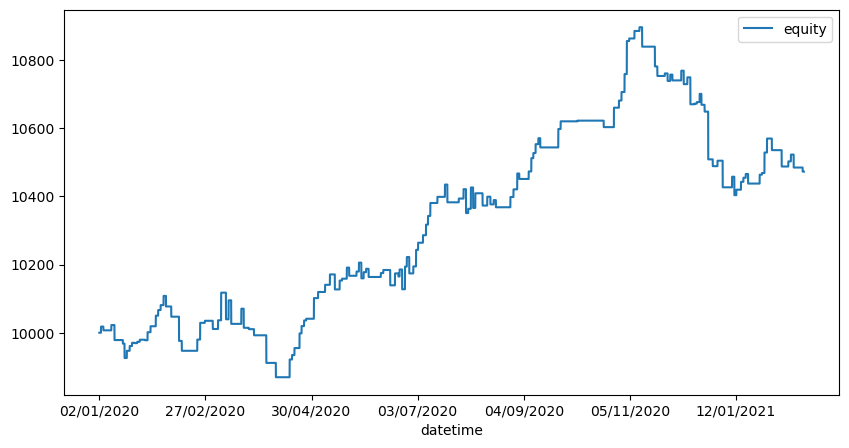

In [387]:
# positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

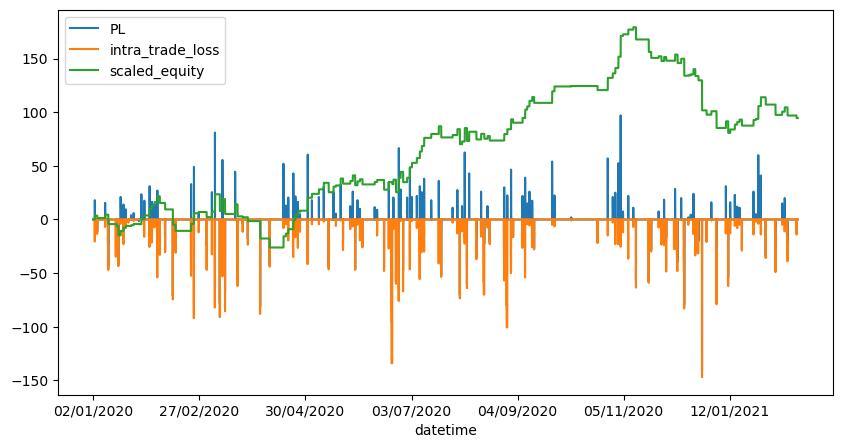

In [388]:
# positions['scaled_equity'] = (positions['equity'] - 10000) / 5
# positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [168]:
trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 10177.0,
 'final_pl': 177.0,
 'number_of_operations': 113,
 'sum_in_trade_periods_stats': 11732,
 'mean_in_trade_periods_stats': 103.82,
 'std_in_trade_periods_stats': 126.42,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 320267,
 'mean_flat_periods_stats': 2809.36,
 'std_flat_periods_stats': 2487.28,
 'max_flat_periods_stats': 20279,
 'min_flat_periods_stats': 545,
 'total_profit': 2272.5,
 'number_profit_operations': 60,
 'percent_profit_operations': 53.1,
 'average_profit_trade': 37.875,
 'max_profit_single_operation': 145.5,
 'number_max_consecutive_profits': 6,
 'max_profit_consecutive_operations': 285.0,
 'number_profit_longs': 60,
 'percent_long_profit': 53.1,
 'number_loss_longs': 53,
 'percent_long_loss': 46.9,
 'total_loss': -2095.5,
 'number_loss_operations': 53,
 'percent_loss_op

<AxesSubplot: xlabel='datetime'>

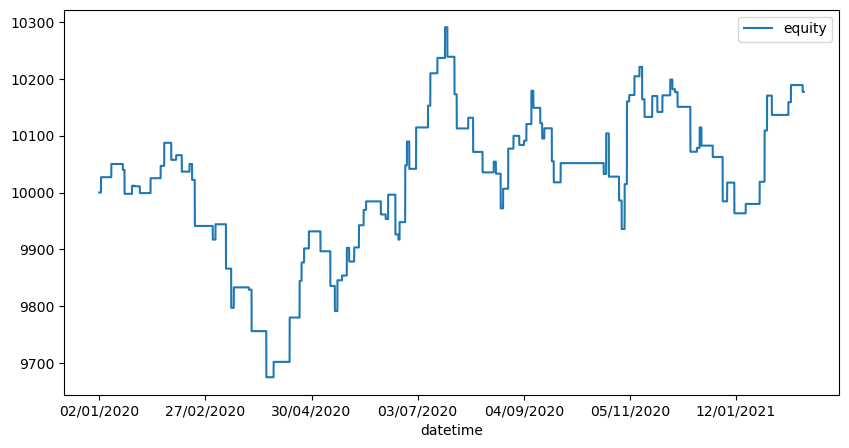

In [167]:
positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

In [389]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 10472.5,
 'final_pl': 472.5,
 'number_of_operations': 151,
 'sum_in_trade_periods_stats': 14320,
 'mean_in_trade_periods_stats': 94.83,
 'std_in_trade_periods_stats': 138.17,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 317679,
 'mean_flat_periods_stats': 2089.99,
 'std_flat_periods_stats': 1770.69,
 'max_flat_periods_stats': 12388,
 'min_flat_periods_stats': 545,
 'total_profit': 2541.5,
 'number_profit_operations': 98,
 'percent_profit_operations': 64.9,
 'average_profit_trade': 25.933673469387756,
 'max_profit_single_operation': 97.0,
 'number_max_consecutive_profits': 11,
 'max_profit_consecutive_operations': 301.5,
 'number_profit_longs': 52,
 'percent_long_profit': 34.44,
 'number_loss_longs': 31,
 'percent_long_loss': 20.53,
 'total_loss': -2069.0,
 'number_loss_operations': 53,
 'pe

### Stop loss at twice the take profit, cut off at 200 USD delta (open position price == Open at 12:00)

<AxesSubplot: xlabel='datetime'>

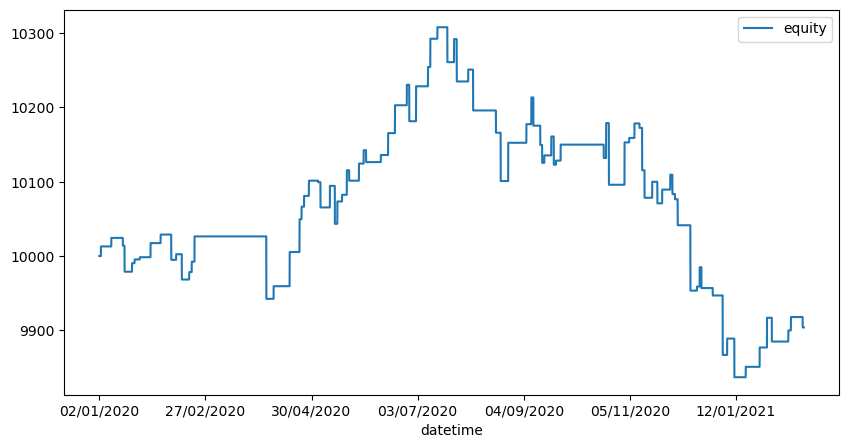

In [152]:
positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

### Stop loss at twice the take profit, one third inner thresholds narrowed by 50% (to 1/6)

<AxesSubplot: xlabel='datetime'>

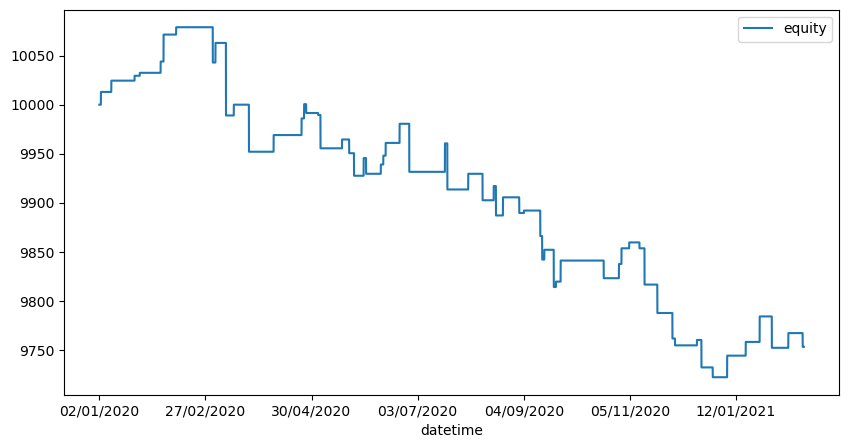

In [112]:
# positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

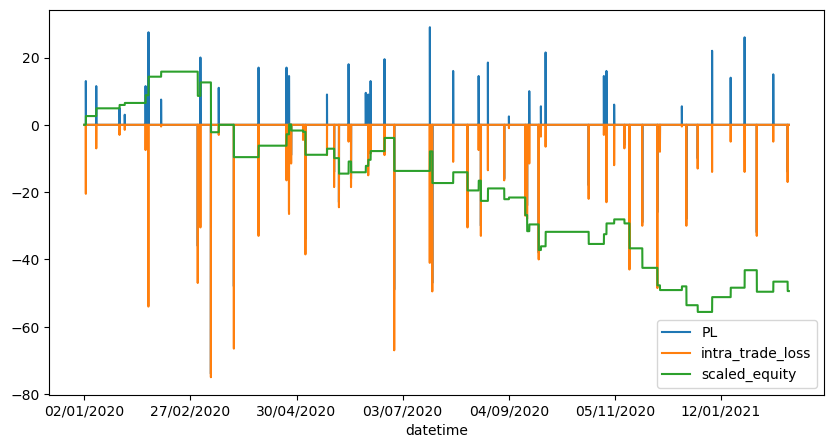

In [113]:
# positions['scaled_equity'] = (positions['equity'] - 10000) / 5
# positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [114]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 9753.0,
 'final_pl': -247.0,
 'number_of_operations': 61,
 'sum_in_trade_periods_stats': 1976,
 'mean_in_trade_periods_stats': 32.39,
 'std_in_trade_periods_stats': 44.85,
 'max_in_trade_periods_stats': 181,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 330023,
 'mean_flat_periods_stats': 5322.95,
 'std_flat_periods_stats': 4343.66,
 'max_flat_periods_stats': 20284,
 'min_flat_periods_stats': 595,
 'total_profit': 473.0,
 'number_profit_operations': 34,
 'percent_profit_operations': 55.74,
 'average_profit_trade': 13.911764705882353,
 'max_profit_single_operation': 29.0,
 'number_max_consecutive_profits': 7,
 'max_profit_consecutive_operations': 79.0,
 'number_profit_longs': 34,
 'percent_long_profit': 55.74,
 'number_loss_longs': 27,
 'percent_long_loss': 44.26,
 'total_loss': -720.0,
 'number_loss_operations': 27,
 'percent_

### Stop loss at four times the take profit, one third inner thresholds narrowed by 50% (to 1/6)

<AxesSubplot: xlabel='datetime'>

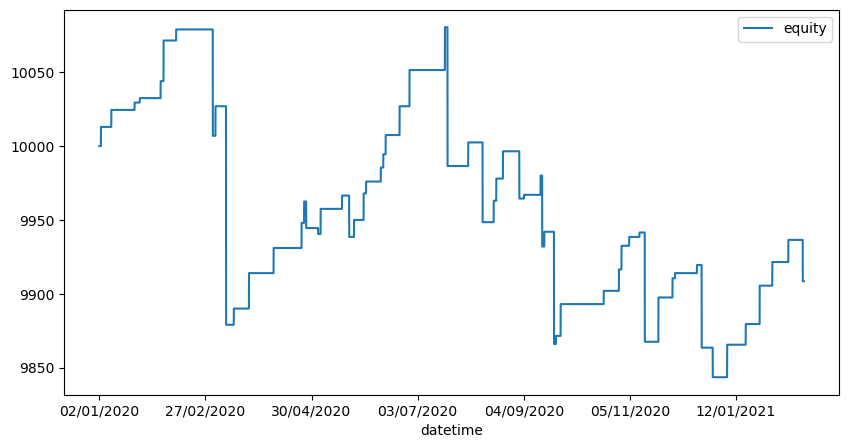

In [118]:
# positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

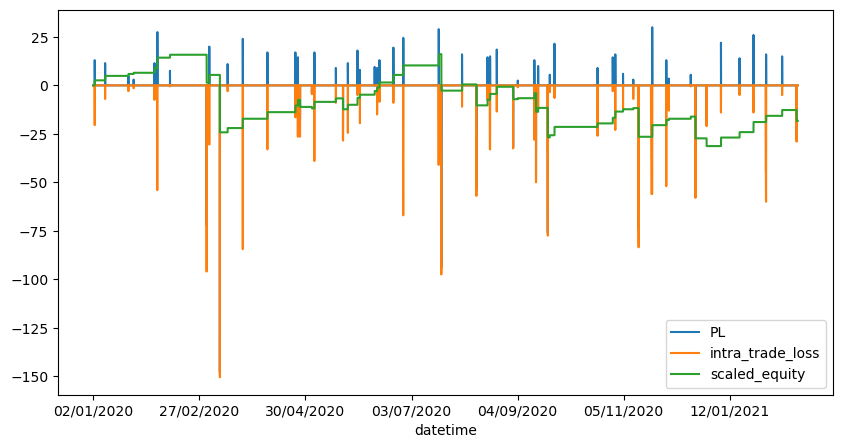

In [119]:
# positions['scaled_equity'] = (positions['equity'] - 10000) / 5
# positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [120]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 9908.5,
 'final_pl': -91.5,
 'number_of_operations': 61,
 'sum_in_trade_periods_stats': 3855,
 'mean_in_trade_periods_stats': 63.2,
 'std_in_trade_periods_stats': 97.8,
 'max_in_trade_periods_stats': 598,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 328144,
 'mean_flat_periods_stats': 5292.65,
 'std_flat_periods_stats': 4338.21,
 'max_flat_periods_stats': 20284,
 'min_flat_periods_stats': 547,
 'total_profit': 660.5,
 'number_profit_operations': 47,
 'percent_profit_operations': 77.05,
 'average_profit_trade': 14.053191489361701,
 'max_profit_single_operation': 30.0,
 'number_max_consecutive_profits': 9,
 'max_profit_consecutive_operations': 142.0,
 'number_profit_longs': 47,
 'percent_long_profit': 77.05,
 'number_loss_longs': 14,
 'percent_long_loss': 22.95,
 'total_loss': -752.0,
 'number_loss_operations': 14,
 'percent_lo

### Stop loss at twice the take profit, one third inner thresholds expaned by 50% (to 1/3*1.5)

<AxesSubplot: xlabel='datetime'>

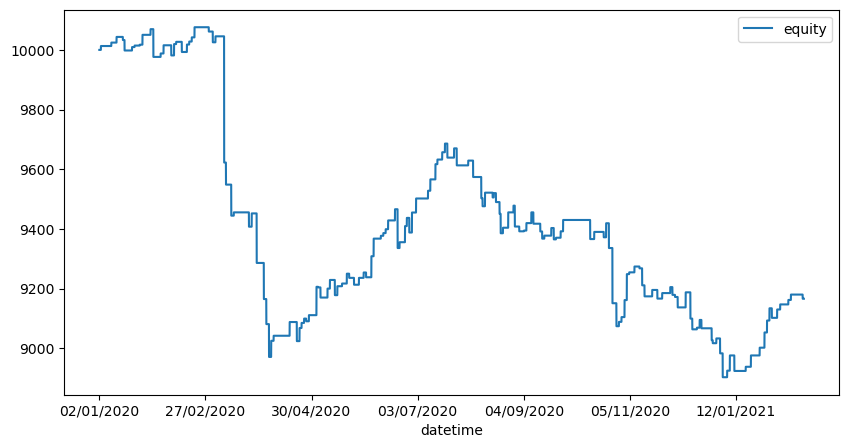

In [124]:
positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

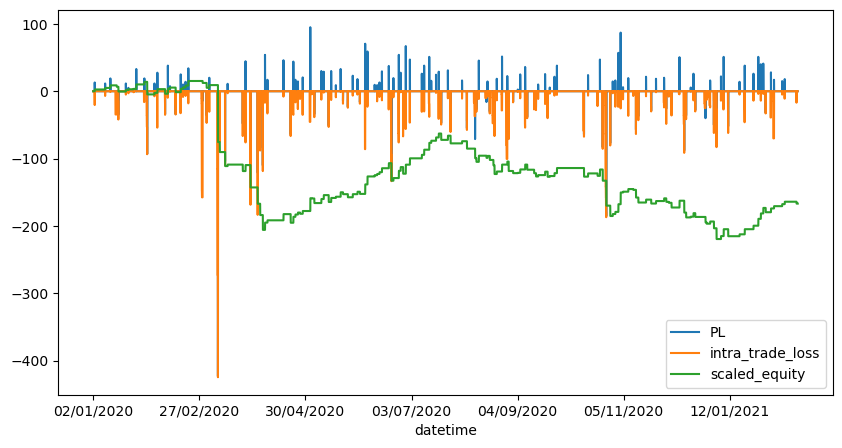

In [125]:
positions['scaled_equity'] = (positions['equity'] - 10000) / 5
positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [126]:
trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 9166.0,
 'final_pl': -834.0,
 'number_of_operations': 156,
 'sum_in_trade_periods_stats': 18305,
 'mean_in_trade_periods_stats': 117.34,
 'std_in_trade_periods_stats': 155.23,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 313694,
 'mean_flat_periods_stats': 1998.05,
 'std_flat_periods_stats': 1561.31,
 'max_flat_periods_stats': 12374,
 'min_flat_periods_stats': 480,
 'total_profit': 2618.5,
 'number_profit_operations': 94,
 'percent_profit_operations': 60.26,
 'average_profit_trade': 27.856382978723403,
 'max_profit_single_operation': 95.0,
 'number_max_consecutive_profits': 8,
 'max_profit_consecutive_operations': 298.0,
 'number_profit_longs': 94,
 'percent_long_profit': 60.26,
 'number_loss_longs': 62,
 'percent_long_loss': 39.74,
 'total_loss': -3452.5,
 'number_loss_operations': 62,
 'p

### Stop loss at half the take profit, one third inner thresholds expaned by 50% (to 1/3*1.5)¶

<AxesSubplot: xlabel='datetime'>

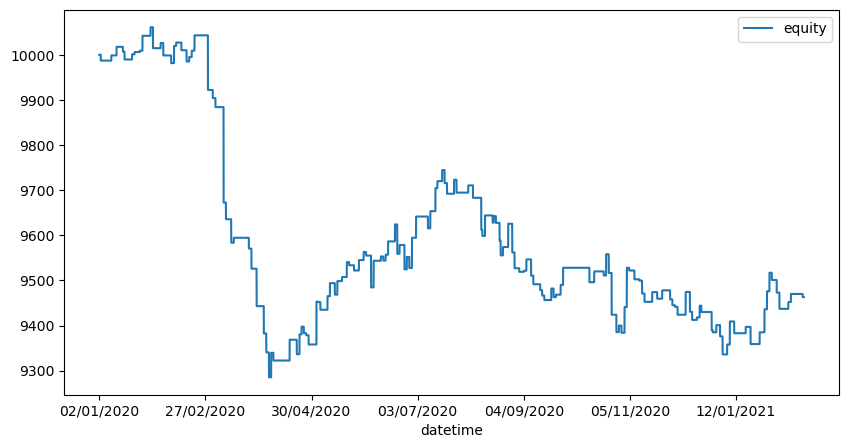

In [131]:
positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='Date'>

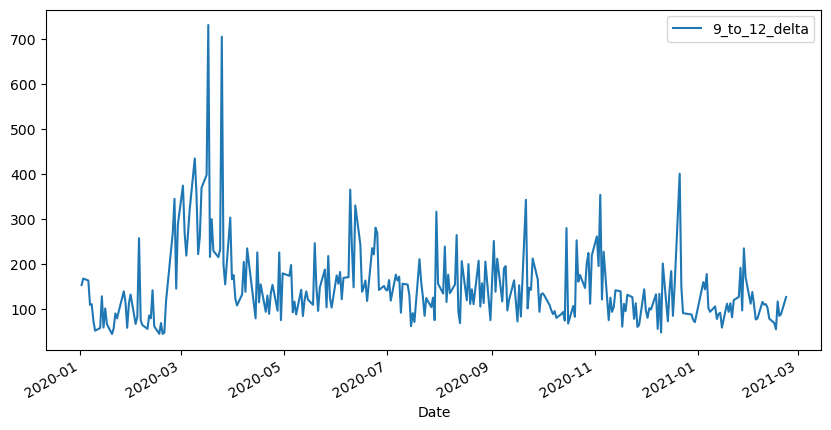

In [140]:
df_stats.plot(x = 'Date', y = '9_to_12_delta', figsize=(10, 5))

### Stop loss at half the take profit, one third inner thresholds expaned by 50% (to 1/3*1.5) - cutoff delta > 200 USD

<AxesSubplot: xlabel='datetime'>

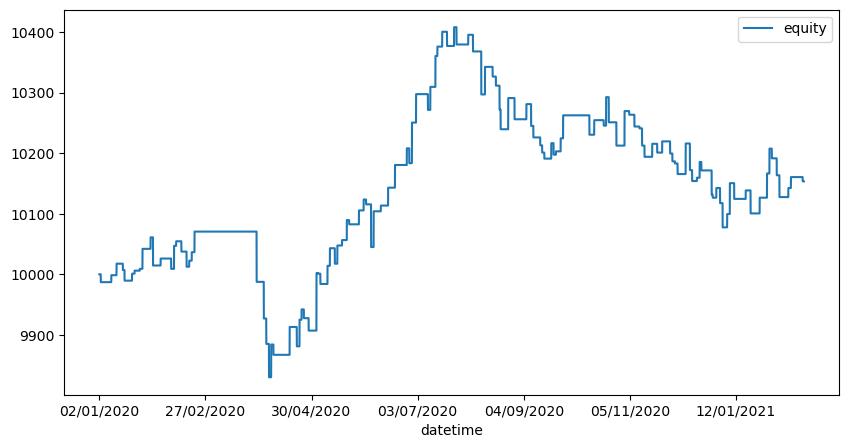

In [147]:
positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

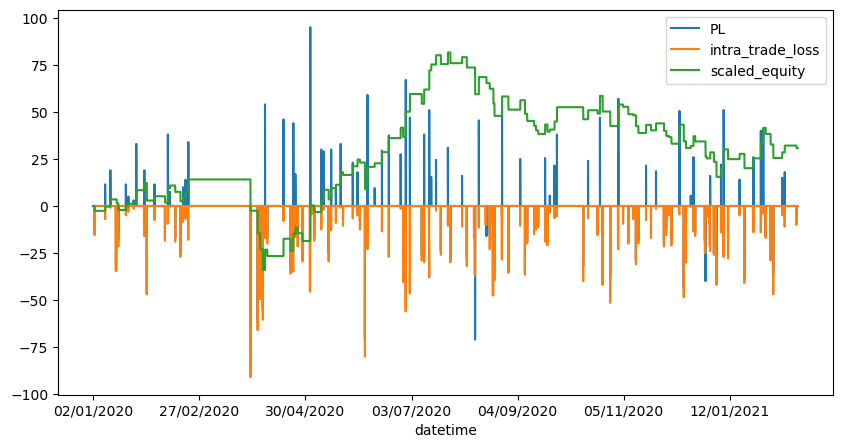

In [149]:
positions['scaled_equity'] = (positions['equity'] - 10000) / 5
positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

### Stop loss figure equal to take profit one

<AxesSubplot: xlabel='datetime'>

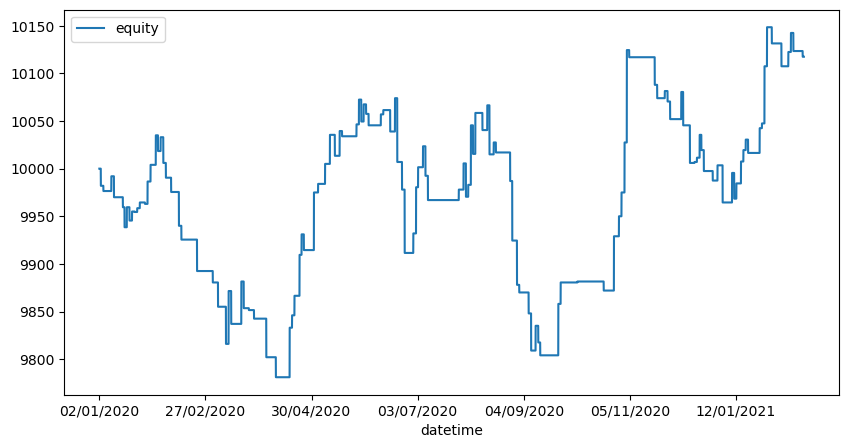

In [392]:
# positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

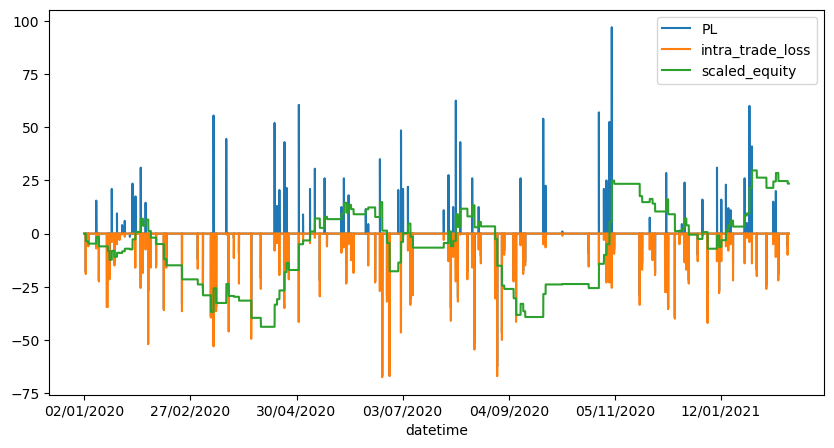

In [393]:
# positions['scaled_equity'] = (positions['equity'] - 10000) / 5
# positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [394]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 10117.5,
 'final_pl': 117.5,
 'number_of_operations': 131,
 'sum_in_trade_periods_stats': 7396,
 'mean_in_trade_periods_stats': 56.46,
 'std_in_trade_periods_stats': 93.86,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 324603,
 'mean_flat_periods_stats': 2459.11,
 'std_flat_periods_stats': 2360.64,
 'max_flat_periods_stats': 14538,
 'min_flat_periods_stats': 574,
 'total_profit': 1651.5,
 'number_profit_operations': 64,
 'percent_profit_operations': 48.85,
 'average_profit_trade': 25.8046875,
 'max_profit_single_operation': 97.0,
 'number_max_consecutive_profits': 5,
 'max_profit_consecutive_operations': 252.5,
 'number_profit_longs': 31,
 'percent_long_profit': 23.66,
 'number_loss_longs': 37,
 'percent_long_loss': 28.24,
 'total_loss': -1534.0,
 'number_loss_operations': 67,
 'percent_loss

### Stop loss at three times the take profit

<AxesSubplot: xlabel='datetime'>

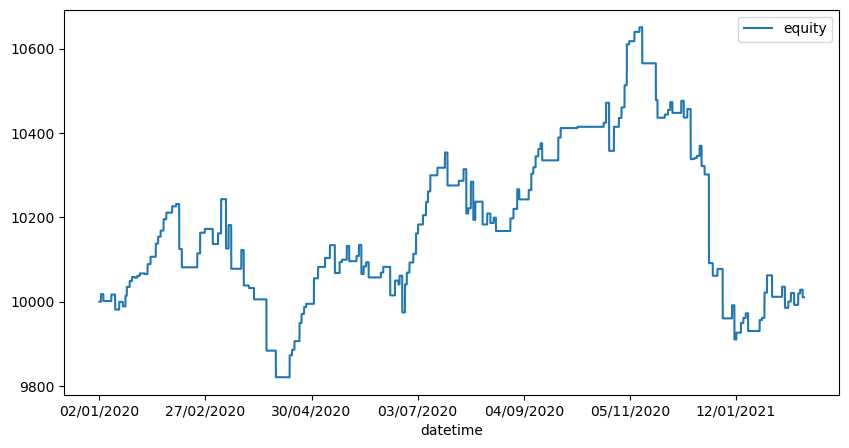

In [401]:
# positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

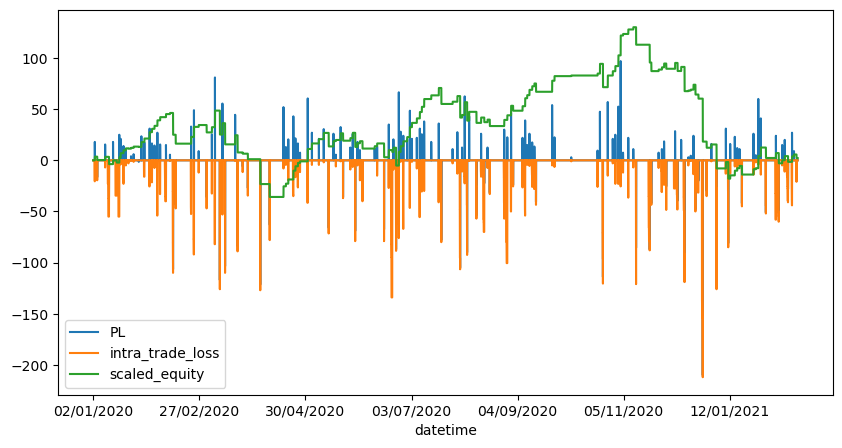

In [402]:
# positions['scaled_equity'] = (positions['equity'] - 10000) / 5
# positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [403]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 10010.5,
 'final_pl': 10.5,
 'number_of_operations': 159,
 'sum_in_trade_periods_stats': 19654,
 'mean_in_trade_periods_stats': 123.61,
 'std_in_trade_periods_stats': 168.98,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 312345,
 'mean_flat_periods_stats': 1952.16,
 'std_flat_periods_stats': 1691.05,
 'max_flat_periods_stats': 12388,
 'min_flat_periods_stats': 545,
 'total_profit': 2807.0,
 'number_profit_operations': 111,
 'percent_profit_operations': 69.81,
 'average_profit_trade': 25.28828828828829,
 'max_profit_single_operation': 97.0,
 'number_max_consecutive_profits': 12,
 'max_profit_consecutive_operations': 379.0,
 'number_profit_longs': 59,
 'percent_long_profit': 37.11,
 'number_loss_longs': 28,
 'percent_long_loss': 17.61,
 'total_loss': -2796.5,
 'number_loss_operations': 48,
 'p

### Stop loss at twice the initial take profit, and then take profit increased by 50% 

<AxesSubplot: xlabel='datetime'>

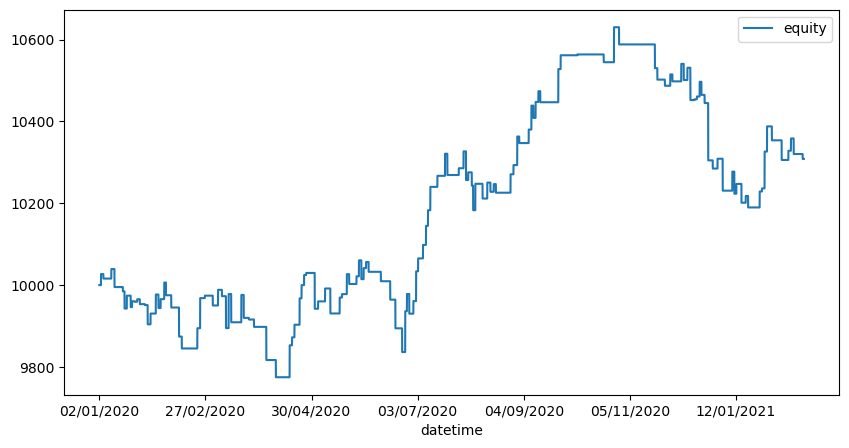

In [409]:
# positions.plot(x = 'datetime', y = 'equity', figsize=(10, 5))

<AxesSubplot: xlabel='datetime'>

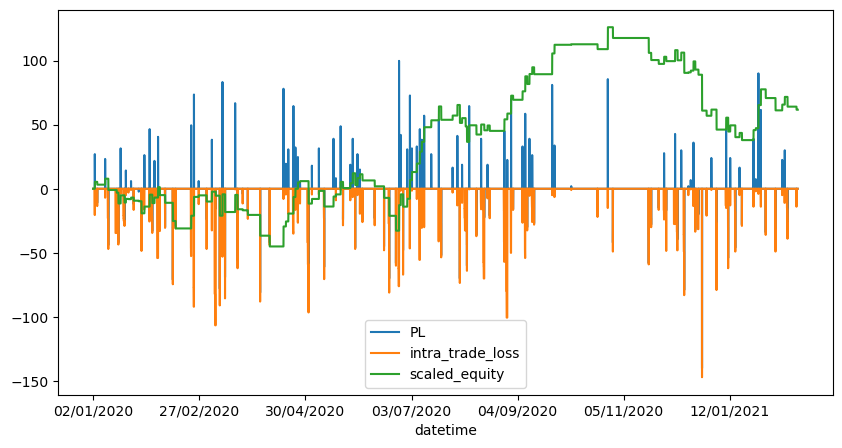

In [410]:
# positions['scaled_equity'] = (positions['equity'] - 10000) / 5
# positions.plot(x = 'datetime', y = ['PL', 'intra_trade_loss', 'scaled_equity'], figsize=(10, 5))

In [411]:
# trading_stats

{'ticker': 'DAX',
 'start_date': '02/01/2020',
 'end_date': '22/02/2021',
 'number_of_periods': 333133,
 'initial_equity': 10000,
 'final_equity': 10308.25,
 'final_pl': 308.25,
 'number_of_operations': 138,
 'sum_in_trade_periods_stats': 16873,
 'mean_in_trade_periods_stats': 122.27,
 'std_in_trade_periods_stats': 164.45,
 'max_in_trade_periods_stats': 600,
 'min_in_trade_periods_stats': 1,
 'sum_flat_periods_stats': 315126,
 'mean_flat_periods_stats': 2267.09,
 'std_flat_periods_stats': 2205.75,
 'max_flat_periods_stats': 16757,
 'min_flat_periods_stats': 512,
 'total_profit': 2788.5,
 'number_profit_operations': 75,
 'percent_profit_operations': 54.35,
 'average_profit_trade': 37.18,
 'max_profit_single_operation': 99.75,
 'number_max_consecutive_profits': 9,
 'max_profit_consecutive_operations': 390.75,
 'number_profit_longs': 38,
 'percent_long_profit': 27.54,
 'number_loss_longs': 34,
 'percent_long_loss': 24.64,
 'total_loss': -2480.25,
 'number_loss_operations': 63,
 'percent_l

### Maxes analysis

In [7]:

# Filtra le righe con forecast = long
df_long_forecast = df_stats[(df_stats['forecast'] == 'long') ]

# time without date
df_long_forecast['after_12_max_time'] = (df_long_forecast['after_12_max_datetime'] - df_long_forecast['after_12_max_datetime'].dt.normalize())  # timedelta64[ns]
df_long_forecast['after_12_min_time'] = (df_long_forecast['after_12_min_datetime'] - df_long_forecast['after_12_min_datetime'].dt.normalize())  # timedelta64[ns]
df_long_forecast['after_12_min_before_max_datetime'] = pd.to_datetime(df_long_forecast['after_12_min_before_max_datetime']).astype('datetime64[ns]')
df_long_forecast['after_12_min_before_max_time'] = (df_long_forecast['after_12_min_before_max_datetime'] - df_long_forecast['after_12_min_before_max_datetime'].dt.normalize())  # timedelta64[ns]


# workaround for pandas time grouping issue/bug
first_day_max = df_long_forecast['after_12_max_datetime'].min().normalize()
df_long_forecast['after_12_max_time_based'] = ( df_long_forecast['after_12_max_time'] + first_day_max )

first_day_min = df_long_forecast['after_12_min_datetime'].min().normalize()
df_long_forecast['after_12_min_time_based'] = ( df_long_forecast['after_12_min_time'] + first_day_min )

first_day_min_before_max = df_long_forecast['after_12_min_before_max_datetime'].min().normalize()
df_long_forecast['after_12_min_before_max_time_based'] = ( df_long_forecast['after_12_min_before_max_time'] + first_day_min )

# ---------------------------------------------------------------------------------
#      Max values after 12:00 in groups of 30 minutes despite the date
# ---------------------------------------------------------------------------------
hist_max = df_long_forecast.groupby(pd.Grouper(key='after_12_max_time_based', freq='30T',  offset='0T', origin='epoch'))['Date'].count()


# ---------------------------------------------------------------------------------------------------
#      Max values after 12:00 in groups of 30 minutes despite the date resulting in effective profit
# ---------------------------------------------------------------------------------------------------

# filter just the signal resulting effectively in a profit
df_long_forecast_profit = df_long_forecast[ df_long_forecast['after_12_max_>_9_to_12_max'] > 0 ]

profit_long = df_long_forecast_profit.groupby(pd.Grouper(key='after_12_max_time_based', freq='30T',  offset='0T', origin='epoch'))['Date'].count()


# ---------------------------------------------------------------------------------------------------
#      Min after 12:00 below min between 9:00 and 12:00 in case of profit
# ---------------------------------------------------------------------------------------------------
df_min_after_12_below_min_9_12 = df_long_forecast[ df_long_forecast['after_12_min_>_9_to_12_min'] < 0 ]
below_min = df_min_after_12_below_min_9_12.groupby(pd.Grouper(key='after_12_min_time_based', freq='30T',  offset='0T', origin='epoch'))['Date'].count()

# display('below_min')
# display(below_min)

# ---------------------------------------------------------------------------------------------------
#      Min after 12:00 above min between 9:00 and 12:00 in case of profit
# ---------------------------------------------------------------------------------------------------
df_min_after_12_above_min_9_12 = df_long_forecast[ df_long_forecast['after_12_min_>_9_to_12_min'] > 0 ]
above_min = df_min_after_12_above_min_9_12.groupby(pd.Grouper(key='after_12_min_time_based', freq='30T',  offset='0T', origin='epoch'))['Date'].count()



# df_stats['after_12_min_before_max_>_12_Open'] = np.where(df_stats['after_12_min_before_max_minus_12_Open'] > 0, 1, -1)
# df_stats['after_12_min_before_max_>_9_to_12_max'] = np.where(df_stats['after_12_min_before_max_9_to_12_max'] > 0, 1, -1)
# df_stats['after_12_min_before_max_>_9_to_12_min'] = np.where(df_stats['after_12_min_before_max_9_to_12_min'] > 0, 1, -1)


# ---------------------------------------------------------------------------------------------------
#      Min after 12:00 and before next max below min between 9:00 and 12:00 in case of profit
# ---------------------------------------------------------------------------------------------------
df_min_after_12_before_max_below_min_9_12 = df_long_forecast[ df_long_forecast['after_12_min_before_max_>_9_to_12_min'] < 0 ]
below_min_before_max = df_min_after_12_before_max_below_min_9_12.groupby(pd.Grouper(key='after_12_min_before_max_time_based', freq='30T',  offset='0T', origin='epoch'))['Date'].count()


# ---------------------------------------------------------------------------------------------------
#      Min after 12:00 and before next max above min between 9:00 and 12:00 in case of profit
# ---------------------------------------------------------------------------------------------------
df_min_after_12_before_max_above_min_9_12 = df_long_forecast[ df_long_forecast['after_12_min_before_max_>_9_to_12_min'] > 0 ]
above_min_before_max = df_min_after_12_before_max_above_min_9_12.groupby(pd.Grouper(key='after_12_min_before_max_time_based', freq='30T',  offset='0T', origin='epoch'))['Date'].count()





# ---------------------------------------------------------------------------------------------------
#      Percentage calculations
# ---------------------------------------------------------------------------------------------------
df_hist_max = hist_max.reset_index()
df_profit_long = profit_long.reset_index()
df_below_min = below_min.reset_index()
df_above_min = above_min.reset_index()
df_below_min_before_max = below_min_before_max.reset_index()
df_above_min_before_max = above_min_before_max.reset_index()


# Workaronud: another bug of grouper: no intervals if not elements falling inside, instad 0 value counting
df_hist_max.columns = ['time', 'hist_max']
df_profit_long.columns = ['time', 'profit_long']
df_below_min.columns = ['time', 'below_min']
df_above_min.columns = ['time', 'above_min']
df_below_min_before_max.columns = ['time', 'below_min_before_max']
df_above_min_before_max.columns = ['time', 'above_min_before_max']

df_hist_max['percent_max'] = round(df_hist_max['hist_max'] / hist_max.sum() * 100, 2)
df_profit_long['percent_profit_long'] = round(df_profit_long['profit_long'] / hist_max.sum() * 100, 2)
df_below_min['percent_below_min'] = round(df_below_min['below_min'] / hist_max.sum() * 100, 2)
df_above_min['percent_above_min'] = round(df_above_min['above_min'] / hist_max.sum() * 100, 2)
df_below_min_before_max['percent_below_min_before_max'] = round(df_below_min_before_max['below_min_before_max'] / hist_max.sum() * 100, 2)
df_above_min_before_max['percent_above_min_before_max'] = round(df_above_min_before_max['above_min_before_max'] / hist_max.sum() * 100, 2)

# Esegui il merge dei tre DataFrame
plot_df = pd.merge(df_hist_max, df_profit_long, on='time', how='outer')
plot_df = plot_df.merge(df_below_min, on='time', how='outer')
plot_df = plot_df.merge(df_above_min, on='time', how='outer')
plot_df = plot_df.merge(df_below_min_before_max, on='time', how='outer')
plot_df = plot_df.merge(df_above_min_before_max, on='time', how='outer')

# Riempi i valori mancanti con 0
plot_df = plot_df.fillna(0)

plot_df['time'] = plot_df['time'].dt.time
plot_df.index = plot_df['time']


# ---------------------------------------
#      Charting
# ---------------------------------------

import plotly.express as px

fig = px.bar(plot_df, x='time', y=['percent_max', 
                                   'percent_profit_long', 
                                   'percent_below_min', 
                                   'percent_above_min',
                                   'percent_below_min_before_max',
                                   'percent_above_min_before_max'],
             color_discrete_sequence=['skyblue', 'green', 'orange', 'red', 'violet', 'purple'], barmode='group')

fig.update_layout(title='After 12:00 mins and maxes occurencies distribution for long trigger signals',
                  xaxis_title='Time', yaxis_title='Occurencies %', xaxis_tickangle=45)

# Personalizza le etichette della legenda
fig.update_traces(
    name='After 12:00 total maxes',
    selector=dict(name='percent_max')
)

fig.update_traces(
    name='After 12:00 profitable maxes',
    selector=dict(name='percent_profit_long')
)

fig.update_traces(
    name='After 12 mins below 9-12 mins',
    selector=dict(name='percent_below_min')
)

fig.update_traces(
    name='After 12 mins above 9-12 mins',
    selector=dict(name='percent_above_min')
)



fig.update_traces(
    name='After 12 mins before max below 9-12 mins',
    selector=dict(name='percent_below_min_before_max')
)

fig.update_traces(
    name='After 12 mins before max above 9-12 mins',
    selector=dict(name='percent_above_min_before_max')
)


fig.show()


# Cumulative chart


# Calcola le colonne cumulate
plot_df['cumulative_percent_max'] = plot_df['percent_max'].cumsum()
plot_df['cumulative_percent_profit_long'] = plot_df['percent_profit_long'].cumsum()
plot_df['cumulative_percent_below_min'] = plot_df['percent_below_min'].cumsum()
plot_df['cumulative_percent_above_min'] = plot_df['percent_above_min'].cumsum()
plot_df['cumulative_percent_below_min_before_max'] = plot_df['percent_below_min_before_max'].cumsum()
plot_df['cumulative_percent_above_min_before_max'] = plot_df['percent_above_min_before_max'].cumsum()

# Riempi i valori mancanti con 0
plot_df = plot_df.fillna(0)

# plot_df['time'] = plot_df['time'].dt.time
# plot_df.index = plot_df['time']

# ---------------------------------------
#      Charting
# ---------------------------------------

fig = px.bar(plot_df, x='time', 
             y=['cumulative_percent_max', 
                'cumulative_percent_profit_long', 
                'cumulative_percent_below_min', 
                'cumulative_percent_above_min',
                'cumulative_percent_below_min_before_max',
                'cumulative_percent_above_min_before_max'],
             color_discrete_sequence=['skyblue', 'green', 'orange', 'red', 'violet', 'purple'], 
             barmode='group')

fig.update_layout(title='Cumulative distribution of occurrences after 12:00 for long trigger signals',
                  xaxis_title='Time', yaxis_title='Cumulative Occurrences %', xaxis_tickangle=45)

# Personalizza le etichette della legenda
fig.update_traces(
    name='Cumulative After 12:00 total maxes',
    selector=dict(name='cumulative_percent_max')
)

fig.update_traces(
    name='Cumulative After 12:00 profitable maxes',
    selector=dict(name='cumulative_percent_profit_long')
)

fig.update_traces(
    name='Cumulative After 12 mins below 9-12 mins',
    selector=dict(name='cumulative_percent_below_min')
)

fig.update_traces(
    name='Cumulative After 12 mins above 9-12 mins',
    selector=dict(name='cumulative_percent_above_min')
)

fig.update_traces(
    name='Cumulative After 12 mins before max below 9-12 mins',
    selector=dict(name='cumulative_percent_below_min_before_max')
)

fig.update_traces(
    name='Cumulative After 12 mins before max above 9-12 mins',
    selector=dict(name='cumulative_percent_above_min_before_max')
)

fig.show()




## Scatter plot of after 12:00 min-max delta vs 9:00-12:00 delta

In [8]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Supponendo che '9_to_12_delta' e 'after_12_min_before_max_max_delta' siano le colonne da considerare
features = df_long_forecast[['9_to_12_delta', 'after_12_min_before_max_max_delta']]

# Normalizza le feature
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Applica l'algoritmo K-Means considerando solo l'asse x
N = 4  # Numero di raggruppamenti desiderato
kmeans = KMeans(n_clusters=N, random_state=42)
df_long_forecast['cluster'] = kmeans.fit_predict(features_scaled[:, [0]])  # Considera solo l'asse x

# Crea uno scatter plot con i raggruppamenti colorati
fig = px.scatter(df_long_forecast, x='9_to_12_delta', y='after_12_min_before_max_max_delta', color='cluster',
                 title=f'Scatter Plot: 9 to 12 min/max delta vs. after 12 min before max and max delta',
                 labels={'9_to_12_delta': '9 to 12 Delta', 'after_12_min_before_max_max_delta': 'After 12 Min Max Delta'})

# Inizializza liste per tracce di linee
lines_min = []
lines_mean = []
lines_std_plus = []
lines_std_minus = []

# Aggiungi bande orizzontali per ogni cluster
for cluster in df_long_forecast['cluster'].unique():
    cluster_data = df_long_forecast[df_long_forecast['cluster'] == cluster]
    y_value_min = cluster_data['after_12_min_before_max_max_delta'].min()
    y_value_mean = cluster_data['after_12_min_before_max_max_delta'].mean()
    y_value_std = cluster_data['after_12_min_before_max_max_delta'].std()

    # Aggiungi linee orizzontali con add_shape
    fig.add_shape(
        type="line",
        x0=cluster_data['9_to_12_delta'].min(),
        x1=cluster_data['9_to_12_delta'].max(),
        y0=y_value_min,
        y1=y_value_min,
        line=dict(color='green', width=2),
    )

    fig.add_shape(
        type="line",
        x0=cluster_data['9_to_12_delta'].min(),
        x1=cluster_data['9_to_12_delta'].max(),
        y0=y_value_mean,
        y1=y_value_mean,
        line=dict(color='black', width=2),
    )

    fig.add_shape(
        type="line",
        x0=cluster_data['9_to_12_delta'].min(),
        x1=cluster_data['9_to_12_delta'].max(),
        y0=y_value_mean + y_value_std,
        y1=y_value_mean + y_value_std,
        line=dict(color='red', width=2, dash='dash'),
    )

    fig.add_shape(
        type="line",
        x0=cluster_data['9_to_12_delta'].min(),
        x1=cluster_data['9_to_12_delta'].max(),
        y0=y_value_mean - y_value_std,
        y1=y_value_mean - y_value_std,
        line=dict(color='blue', width=2, dash='dash'),
    )

    fig.add_annotation(
        x=(cluster_data['9_to_12_delta'].min() + cluster_data['9_to_12_delta'].max()) / 2,
        y=y_value_min - 25,  # Posizionato sotto la linea
        text=f'Min: {y_value_min:.1f}',  # Mostra valore arrotondato a una cifra decimale
        showarrow=False,  # Senza freccia
        font=dict(color='green', ),  # Colore del testo e sfondo bianco
        bgcolor='white'
    )

    fig.add_annotation(
        x=(cluster_data['9_to_12_delta'].min() + cluster_data['9_to_12_delta'].max()) / 2,
        y=y_value_mean - 25,  # Posizionato sotto la linea
        text=f'Mean: {y_value_mean:.1f}',  # Mostra valore arrotondato a una cifra decimale
        showarrow=False,  # Senza freccia
        font=dict(color='black',),  # Colore del testo e sfondo bianco
        bgcolor='white'
    )

# Mostra il grafico
fig.show()





C:\Users\Federico\anaconda3\envs\mltrading_base\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## After 12 mins falling areas, winning/looseing cases

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponendo che df_long_forecast sia il tuo DataFrame con le colonne specificate

# Seleziona solo i segnali long
df_long_signals = df_long_forecast[df_long_forecast['forecast'] == 'long']

# Reset degli indici per evitare il problema KeyError
df_long_signals = df_long_signals.reset_index(drop=True)

df_long_signals_win = df_long_signals[df_long_signals['gain'] == 1]

# Calcola la colonna 'mins_below_9_to_12_min'
df_long_signals_win['mins_below_9_to_12_min'] = (df_long_signals_win['after_12_min'] < df_long_signals_win['9_to_12_min']).astype(int)

# Calcola la colonna 'mins_between_9_to_12_min_max'
df_long_signals_win['mins_between_9_to_12_min_max'] = ((df_long_signals_win['after_12_min'] >= df_long_signals_win['9_to_12_min']) & (df_long_signals_win['after_12_min'] <= df_long_signals_win['9_to_12_max'])).astype(int)

# Calcola la colonna 'mins_above_9_to_12_max'
df_long_signals_win['mins_above_9_to_12_max'] = (df_long_signals_win['after_12_min'] > df_long_signals_win['9_to_12_max']).astype(int)

# Calcola la colonna 'mins_below_9_to_12_min_loss'
df_long_signals_loss = df_long_signals[df_long_signals['gain'] == -1]  # Seleziona i segnali long con perdita
df_long_signals_loss['mins_below_9_to_12_min_loss'] = (df_long_signals_loss['after_12_min'] < df_long_signals_loss['9_to_12_min']).astype(int)

# Calcola la colonna 'mins_between_9_to_12_min_max_loss'
df_long_signals_loss['mins_between_9_to_12_min_max_loss'] = ((df_long_signals_loss['after_12_min'] >= df_long_signals_loss['9_to_12_min']) & (df_long_signals_loss['after_12_min'] <= df_long_signals_loss['9_to_12_max'])).astype(int)

# Calcola la colonna 'mins_above_9_to_12_max_loss'
df_long_signals_loss['mins_above_9_to_12_max_loss'] = (df_long_signals_loss['after_12_min'] > df_long_signals_loss['9_to_12_max']).astype(int)

# Calcola il numero di occorrenze per ogni categoria
counts = df_long_signals_win[['mins_below_9_to_12_min', 'mins_between_9_to_12_min_max', 'mins_above_9_to_12_max']].sum()
counts_loss = df_long_signals_loss[['mins_below_9_to_12_min_loss', 'mins_between_9_to_12_min_max_loss', 'mins_above_9_to_12_max_loss']].sum()

# Crea un DataFrame con i risultati
count_df = pd.DataFrame({
    'Category': ['Below 9-12 Min', 'Between 9-12 Min and Max', 'Above 9-12 Max'],
    'Long Gain': counts.values,
    'Long Loss': counts_loss.values
})


fig = px.bar(count_df, y='Category', x=['Long Gain', 'Long Loss'], orientation='h',
             labels={'value': 'Count', 'variable': 'Signal Type'},
             title='Count area location of mins after 12:00 with respect 9:00 to 12:00 min-max',
             color_discrete_map={'Long Gain': 'green', 'Long Loss': 'red'})

fig.show()







In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponendo che df_long_forecast sia il tuo DataFrame con le colonne specificate

# Seleziona solo i segnali long
df_long_signals = df_long_forecast[df_long_forecast['forecast'] == 'long']

# Reset degli indici per evitare il problema KeyError
df_long_signals = df_long_signals.reset_index(drop=True)

df_long_signals_win = df_long_signals[df_long_signals['gain'] == 1]

# Calcola la colonna 'mins_below_9_to_12_min'
df_long_signals_win['mins_below_9_to_12_min'] = (df_long_signals_win['after_12_min'] < df_long_signals_win['9_to_12_min']).astype(int)

# Calcola la colonna 'mins_between_9_to_12_min_max'
df_long_signals_win['mins_between_9_to_12_min_max'] = ((df_long_signals_win['after_12_min'] >= df_long_signals_win['9_to_12_min']) & (df_long_signals_win['after_12_min'] <= df_long_signals_win['9_to_12_max'])).astype(int)

# Calcola la colonna 'mins_above_9_to_12_max'
df_long_signals_win['mins_above_9_to_12_max'] = (df_long_signals_win['after_12_min'] > df_long_signals_win['9_to_12_max']).astype(int)

# Calcola la colonna 'mins_below_9_to_12_min_loss'
df_long_signals_loss = df_long_signals[df_long_signals['gain'] == -1]  # Seleziona i segnali long con perdita
df_long_signals_loss['mins_below_9_to_12_min_loss'] = (df_long_signals_loss['after_12_min'] < df_long_signals_loss['9_to_12_min']).astype(int)

# Calcola la colonna 'mins_between_9_to_12_min_max_loss'
df_long_signals_loss['mins_between_9_to_12_min_max_loss'] = ((df_long_signals_loss['after_12_min'] >= df_long_signals_loss['9_to_12_min']) & (df_long_signals_loss['after_12_min'] <= df_long_signals_loss['9_to_12_max'])).astype(int)

# Calcola la colonna 'mins_above_9_to_12_max_loss'
df_long_signals_loss['mins_above_9_to_12_max_loss'] = (df_long_signals_loss['after_12_min'] > df_long_signals_loss['9_to_12_max']).astype(int)

# Calcola il numero di occorrenze per ogni categoria
counts = df_long_signals_win[['mins_below_9_to_12_min', 'mins_between_9_to_12_min_max', 'mins_above_9_to_12_max']].sum()
counts_loss = df_long_signals_loss[['mins_below_9_to_12_min_loss', 'mins_between_9_to_12_min_max_loss', 'mins_above_9_to_12_max_loss']].sum()

# Calcola la somma totale delle occorrenze su tutte le categorie
total_counts = counts.add(counts_loss, fill_value=0)
total_counts_sum = total_counts.sum()

# Calcola le percentuali
counts_percent = round(counts / total_counts_sum * 100, 2)
counts_loss_percent = round(counts_loss / total_counts_sum * 100, 2)


# Crea un DataFrame con i risultati
count_df = pd.DataFrame({
    'Min value occurencies price range': ['Below 9-12 Min', 'Between 9-12 Min and Max', 'Above 9-12 Max'],
    'Long Gain': counts_percent.values,
    'Long Loss': counts_loss_percent.values
})


fig = px.bar(count_df, y='Min value occurencies price range', x=['Long Gain', 'Long Loss'], orientation='h',
             labels={'value': 'Count', 'variable': 'Signal Type'},
             title='Count area location of mins after 12:00 with respect 9:00 to 12:00 min-max',
             color_discrete_map={'Long Gain': 'green', 'Long Loss': 'red'},
             text_auto=True)

fig.show()







In [11]:
# Eseguiamo la somma dei conteggi, sostituendo i valori NaN con 0
total_counts = counts.add(counts_loss, fill_value=0)

# Stampa il risultato della somma
print("Total Counts:")
print(total_counts)

Total Counts:
mins_above_9_to_12_max                  0.0
mins_above_9_to_12_max_loss             0.0
mins_below_9_to_12_min                692.0
mins_below_9_to_12_min_loss           518.0
mins_between_9_to_12_min_max         1788.0
mins_between_9_to_12_min_max_loss     173.0
dtype: float64


## Count number of crosses after 12:00 of min/max beteween 9:00 and 12:00

In [12]:
import plotly.express as px

# Conteggio delle occorrenze di tocco del massimo dopo le 12
df_stats_long = df_stats[df_stats['forecast'] == 'long']
max_touched_counts = df_stats_long['max_cross_count'].value_counts().reset_index()
max_touched_counts.columns = ['Occurences Number', 'Count']

# Traccia il grafico a barre per il tocco del massimo dopo le 12
fig_max_touched = px.bar(max_touched_counts, 
                         x='Occurences Number', 
                         y='Count',
                         labels={'Count': 'Occurences', 'Occurences Number': 'Number of max crosses after 12:00'},
                         title='Disribution of daily 9:00-12:00 max crosses after 12:00')
fig_max_touched.show()

# Conteggio delle occorrenze di tocco del minimo dopo le 12
min_touched_counts = df_stats['min_cross_count'].value_counts().reset_index()
min_touched_counts.columns = ['Occurences Number', 'Count']

# Traccia il grafico a barre per il tocco del minimo dopo le 12
fig_min_touched = px.bar(min_touched_counts, x='Occurences Number', y='Count',
                         labels={'Count': 'Occurences', 'Occurences Number': 'Number of min crosses afte 12:00'},
                         title='Disribution of daily 9:00-12:00 max crosses after 12:00')
fig_min_touched.show()


## Max difference between 9:00-12:00 min/max and next min/max after 12:00 of the same day 

In [13]:
import plotly.graph_objects as go

# Trova la massima differenza tra il massimo prima delle 12 e quello dopo le 12
# df_stats['max_diff'] = df_stats['after_12_max'] - df_stats['9_to_12_max']
max_diff_max_index = df_stats['after_12_max_minus_9_to_12_max'].idxmax()
max_diff_max_date = df_stats.loc[max_diff_max_index, 'Date']
max_diff_max_value = df_stats.loc[max_diff_max_index, 'after_12_max_minus_9_to_12_max']

# Trova la massima differenza tra il minimo prima delle 12 e quello dopo le 12
# df_stats['min_diff'] = df_stats['9_to_12_min'] - df_stats['after_12_min']
min_diff_max_index = (-1 * df_stats['after_12_min_minus_9_to_12_min']).idxmax()
min_diff_max_date = df_stats.loc[min_diff_max_index, 'Date']
min_diff_max_value = (-1 * df_stats.loc[min_diff_max_index, 'after_12_min_minus_9_to_12_min'] )

print(f"Maximum difference between the maximum before 12 and that after 12: {max_diff_max_value} il {max_diff_max_date}")
print(f"Maximum difference between the minimum before 12 and that after 12: {min_diff_max_value} il {min_diff_max_date}")


# --------------------------------------
#            maxes delta
# --------------------------------------

N = 200
# Aggiungi un bin per valori >= 0
bins = list(range(0, int(max_diff_max_value), int(max_diff_max_value // N))) + [float('inf')]

# Filtra i dati per escludere valori < 0
filtered_df_stats = df_stats[df_stats['after_12_max_minus_9_to_12_max'] >= 0]

# Crea l'istogramma con Plotly Graph Objects
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x=filtered_df_stats['after_12_max_minus_9_to_12_max'],
        nbinsx=N,  # Utilizza nbinsx invece di nbins
        xbins=dict(start=0, end=max_diff_max_value, size=max_diff_max_value / N),
        marker_color='blue',
        opacity=0.7,
    )
)

# Aggiungi etichette agli assi
fig.update_layout(
    title='Delta between 9:00-12:00 maximum and after 12:00 maximum, not negative values only',
    xaxis=dict(title='max_diff'),
    yaxis=dict(title='Occurences'),
)

# Mostra il grafico
fig.show()



# --------------------------------------
#            mins delta
# --------------------------------------

N = 200
# Aggiungi un bin per valori >= 0
bins = list(range(0, int(min_diff_max_value), int(min_diff_max_value // N))) + [float('inf')]

# Filtra i dati per escludere valori < 0
filtered_df_stats = df_stats[(-1 * df_stats['after_12_min_minus_9_to_12_min']) >= 0]

# Crea l'istogramma con Plotly Graph Objects
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x= -1 * filtered_df_stats['after_12_min_minus_9_to_12_min'],
        nbinsx=N,  # Utilizza nbinsx invece di nbins
        xbins=dict(start=0, end=min_diff_max_value, size=min_diff_max_value / N),
        marker_color='blue',
        opacity=0.7,
    )
)

# Aggiungi etichette agli assi
fig.update_layout(
    title='Delta between 9:00-12:00 minimum and after 12:00 minimum, not negative values only',
    xaxis=dict(title='min_diff'),
    yaxis=dict(title='Occurences'),
)

# Mostra il grafico
fig.show()


Maximum difference between the maximum before 12 and that after 12: 556.0 il 2020-11-09 00:00:00
Maximum difference between the minimum before 12 and that after 12: 701.0 il 2020-03-12 00:00:00


## Win/Loss forecasts PCA analysis

In [14]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_long_forecast.reset_index(drop=True, inplace=True)
df_long_forecast['gain_binary'] = df_long_forecast['gain'] # df_long_forecast['gain'].map({True: 1, False: -1})

# Seleziona colonne di interesse per il clustering
columns_for_clustering = ['9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
                          'open_at_12_rel_distance_day_-1',
                          '9_to_12_delta_day_-2', 
                          '9_to_12_min_max_period_day_-2', 
                          '9_to_12_min_before_max_day_-2', 
                          'open_at_12_rel_distance_day_-2',
#                           'gain_day_-1',
#                           'gain_day_-2'
                         ]

columns_for_clustering = [
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
                          'open_at_12_rel_distance_day_-1',
                          '9_to_12_delta_day_-2', 
                          '9_to_12_min_max_period_day_-2', 
                          '9_to_12_min_before_max_day_-2', 
                          'open_at_12_rel_distance_day_-2',
                          'gain_day_-1',
    'gain_day_-2',
    'weekly_day',
    'month',
"CO_mean", "HL_mean", "Close_delta_mean", "High_delta_mean", "Low_delta_mean",  "CO_std", "HL_std", "Close_delta_std", "High_delta_std", "Low_delta_std", 
#                           'gain_day_-2',
                          '9_to_12_max_minus_9_to_12_max_day_-1',
                          '9_to_12_max_minus_9_to_12_max_day_-2',
                          '9_to_12_max_minus_9_to_12_min_day_-1',
                          '9_to_12_max_minus_9_to_12_min_day_-2',
                          '9_to_12_min_minus_9_to_12_max_day_-1',
                          '9_to_12_min_minus_9_to_12_max_day_-2',
                          '9_to_12_min_minus_9_to_12_min_day_-1',
                          '9_to_12_min_minus_9_to_12_min_day_-2',
                          '9_to_12_max_minus_after_12_max_day_-1',
                          '9_to_12_max_minus_after_12_max_day_-2',
                          '9_to_12_max_minus_after_12_min_day_-1',
                          '9_to_12_max_minus_after_12_min_day_-2',
                          '9_to_12_min_minus_after_12_max_day_-1',
                          '9_to_12_min_minus_after_12_max_day_-2',
                         '9_to_12_min_minus_after_12_min_day_-1',
                         '9_to_12_min_minus_after_12_min_day_-2',
                         
                         '9_to_12_delta_div_9_to_12_delta_day_-1',
                         '9_to_12_delta_div_9_to_12_delta_day_-2',
                         '9_to_12_delta_div_after_12_min_max_delta_day_-1',
                         '9_to_12_delta_div_after_12_min_max_delta_day_-2'
                         ]



df_long_forecast_cleaned = df_long_forecast.dropna()

print(len(df_long_forecast))
print(len(df_long_forecast_cleaned))

# Normalizza le colonne selezionate
scaler = StandardScaler()
df_long_forecast_scaled = scaler.fit_transform(df_long_forecast_cleaned[columns_for_clustering])

# Applica PCA per ridurre la dimensionalità a 2 componenti principali
pca = PCA(n_components=2)
components = pca.fit_transform(df_long_forecast_scaled)
df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

print(len(df_pca))

# Aggiungi il campo 'gain' come variabile di colore nel grafico
# df_pca['gain'] = df_long_forecast['gain'].map({True: 1, False: -1})

df_pca['gain'] = df_long_forecast_cleaned['gain_binary']

# Trova i valori unici nel campo 'gain' per determinare i colori
unique_gain_values = df_long_forecast_cleaned['gain_binary'].unique()

# Applica l'algoritmo K-Means sui componenti principali
# num_clusters = len(unique_gain_values)  # Numero di cluster basato sui valori unici di 'gain'
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# df_pca['cluster'] = kmeans.fit_predict(df_long_forecast_scaled)

# Traccia un plot 2D con il colore basato sul campo 'gain' e i cluster
fig = px.scatter(df_pca, x='PC1', y='PC2', color='gain', symbol='gain',#symbol='cluster',
                 labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'gain': 'Gain'},
                 title='PCA on Gain Binary Label')

# Mostra il grafico
fig.show()


3171
3168
3168


In [13]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# va fatto su df_stats
# df_long_forecast.reset_index(drop=True, inplace=True)
# df_long_forecast['gain_binary'] = df_long_forecast['gain'] # df_long_forecast['gain'].map({True: 1, False: -1})

# Seleziona colonne di interesse per il clustering
columns_for_clustering = ['9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
                          'open_at_12_rel_distance_day_-1',
                          '9_to_12_delta_day_-2', 
                          '9_to_12_min_max_period_day_-2', 
                          '9_to_12_min_before_max_day_-2', 
                          'open_at_12_rel_distance_day_-2',
#                           'gain_day_-1',
#                           'gain_day_-2'
                         ]

columns_for_clustering = [
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
                          'open_at_12_rel_distance_day_-1',
                          '9_to_12_delta_day_-2', 
                          '9_to_12_min_max_period_day_-2', 
                          '9_to_12_min_before_max_day_-2', 
                          'open_at_12_rel_distance_day_-2',
                          'gain_day_-1',
    'gain_day_-2',
    'weekly_day',
    'month',
"CO_mean", "HL_mean", "Close_delta_mean", "High_delta_mean", "Low_delta_mean",  "CO_std", "HL_std", "Close_delta_std", "High_delta_std", "Low_delta_std", 
#                           'gain_day_-2',
                          '9_to_12_max_minus_9_to_12_max_day_-1',
                          '9_to_12_max_minus_9_to_12_max_day_-2',
                          '9_to_12_max_minus_9_to_12_min_day_-1',
                          '9_to_12_max_minus_9_to_12_min_day_-2',
                          '9_to_12_min_minus_9_to_12_max_day_-1',
                          '9_to_12_min_minus_9_to_12_max_day_-2',
                          '9_to_12_min_minus_9_to_12_min_day_-1',
                          '9_to_12_min_minus_9_to_12_min_day_-2',
                          '9_to_12_max_minus_after_12_max_day_-1',
                          '9_to_12_max_minus_after_12_max_day_-2',
                          '9_to_12_max_minus_after_12_min_day_-1',
                          '9_to_12_max_minus_after_12_min_day_-2',
                          '9_to_12_min_minus_after_12_max_day_-1',
                          '9_to_12_min_minus_after_12_max_day_-2',
                         '9_to_12_min_minus_after_12_min_day_-1',
                         '9_to_12_min_minus_after_12_min_day_-2',
                         
                         '9_to_12_delta_div_9_to_12_delta_day_-1',
                         '9_to_12_delta_div_9_to_12_delta_day_-2',
                         '9_to_12_delta_div_after_12_min_max_delta_day_-1',
                         '9_to_12_delta_div_after_12_min_max_delta_day_-2'
                         ]



df_stats_cleaned = df_long_forecast.dropna()


# Normalizza le colonne selezionate
scaler = StandardScaler()
df_long_forecast_scaled = scaler.fit_transform(df_stats_cleaned[columns_for_clustering])

# Applica PCA per ridurre la dimensionalità a 2 componenti principali
pca = PCA(n_components=2)
components = pca.fit_transform(df_long_forecast_scaled)
df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

print(len(df_pca))

def assign_gain(row):
    if row['binary_target_long_reached'] == 1 and row['binary_target_short_reached'] == 0:
        return 1
    elif row['binary_target_long_reached'] == 0 and row['binary_target_short_reached'] == 1:
        return 2
    elif row['binary_target_long_reached'] == 1 and row['binary_target_short_reached'] == 1:
        return 3
    else:
        return 0

df_pca['target_reached'] = df_stats_cleaned.apply(assign_gain, axis=1)

# Trova i valori unici nel campo 'gain' per determinare i colori
unique_gain_values = df_pca['target_reached'].unique()


# Traccia un plot 2D con il colore basato sul campo 'gain' e i cluster
fig = px.scatter(df_pca, x='PC1', y='PC2', color='target_reached', #symbol='cluster',
                 labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
                 title='PCA on Gain Binary Label')

# Mostra il grafico
fig.show()


2205


## ANN Networks

### Network class definition: network structure, network training, network validation, results filtering

In [15]:
class fastANN:

    def __init__(self,
                 X_data = None,
                 Y_data = None,
                 X_train_s = None,
                 Y_train = None,
                 X_test_s = None,
                 Y_test = None,
                 split_type = 'sequential', # 'random' 'sequential'
                 model_relative_width = [1],
                 model_dropout = [0],
                 learning_rate = 0.0003,
                 activation = 'relu',
                 last_layer_activation = 'sigmoid',
                 loss = 'binary_crossentropy',
                 save_best_only = True,
                 early_stop_patience = 200,
                 train_size_rate = 0.7,
                 data_storage_path="\\cyPredict\\",
                 model_name = 'ANN'):
        
        self.model = Sequential()
        self.save_best_only = save_best_only
        
        self.data_storage_path = data_storage_path
        self.model_name = model_name
        
        self.model_relative_width = model_relative_width
        self.model_dropout = model_dropout
        self.learning_rate = learning_rate
        self.activation = activation
        self.last_layer_activation = last_layer_activation
        self.loss = loss
        self.early_stop_patience = early_stop_patience
        self.train_size_rate = train_size_rate
        
        self.loss_df = pd.DataFrame()
        
        
        self.model_summary = {}
        
        self.X_data = X_data
        self.Y_data = Y_data
        
        if(X_train_s is None):
            self.X_train_s = pd.DataFrame()
        else:
            self.X_train_s = X_train_s
            
        if(Y_train is None):
            self.Y_train = pd.DataFrame()
        else:
            self.Y_train = Y_train           
            
        if(X_test_s is None):
            self.X_test_s = pd.DataFrame()
        else:
            self.X_test_s = X_test_s               

        if(Y_test is None):
            self.Y_test = pd.DataFrame()
        else:
            self.Y_test = Y_test  

        self.split_type = split_type
        
        self.scaler = StandardScaler()
        
        self.checkpoint_callback(self.save_best_only)        
        
        self.early_stop_patience_set(self.early_stop_patience)
        
        if((self.X_data is not None) & (self.Y_data is not None)):
            self.split_and_scale()
            

    def early_stop_patience_set(self, patience):
        
        self.early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = patience)
            
        
    def checkpoint_callback(self, save_best_only):
        
        self.checkpoint_callback = ModelCheckpoint(self.data_storage_path + 'ANN MODEL - ' + self.model_name +'.h5', 
                                                   monitor='val_accuracy', 
                                                   mode='max', 
                                                   verbose=1, 
                                                   save_best_only=save_best_only)
        
        
    def network_structure_set_compile(self):
        
        # reset
        self.model = Sequential()
        
        print(len(self.X_train_s))
        
        # first layer
        self.model.add(Dense(self.X_train_s.shape[1] * self.model_relative_width[0] , 
                             input_shape = (self.X_train_s.shape[1],), 
                       activation = self.activation))
        self.model.add(Dropout(self.model_dropout[0]))


        # inner layers
        for i in range(1, len(self.model_relative_width) - 1):
            
            model_relative_width = self.model_relative_width[i]
            model_dropout = self.model_dropout[i]
            
            print(model_relative_width)
            print(model_dropout)
            
            self.model.add(Dense(int(self.X_train_s.shape[1] * model_relative_width), 
                           activation = self.activation))
            self.model.add(Dropout(model_dropout)) 
            
            
        # last layer
        self.model.add(Dense(1, 
                             activation = self.last_layer_activation)) 

        # compile
        self.model.compile(optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0003),                      
                         loss = self.loss, 
                         metrics = ['accuracy'])
        
            
        # report
        self.model_summary = self.model.summary()
        
        display(self.model_summary)


        
        
    def network_training(self, epochs, batch_size):
        
        self.model.fit(x=self.X_train_s, 
                  y=self.Y_train, 
                  epochs = epochs, 
                  batch_size = batch_size,    
                  validation_data = (self.X_test_s, 
                                     self.Y_test), 
                  callbacks = [self.early_stop, self.checkpoint_callback])
        
        # save history
        self.loss_df = pd.DataFrame(self.model.history.history)
        self.loss_df.to_csv(self.data_storage_path + 'ANN MODEL - ' + self.model_name + ' - TRAINING HISTORY.csv')
                
        # keep the best model
        self.model = load_model(self.data_storage_path + 'ANN MODEL - ' + self.model_name +'.h5')
        
        # plot history
        self.plot_training_history()
        
        
    def load_model(self, file_path_name = None):
        
        if(file_path_name is not None):
            self.model = pd.read_csv(file_path_name)
            
        else:
            self.model = load_model(self.data_storage_path + 'ANN MODEL - ' + self.model_name +'.h5')

            
    def load_training_history(self, file_path_name = None):
        
        if(file_path_name is not None):
            self.loss_df = pd.read_csv(file_path_name)
            
        else:
            self.loss_df = pd.read_csv(self.data_storage_path + 'ANN MODEL - ' + self.model_name + ' - TRAINING HISTORY.csv')
        
        
    def network_predictions_evaluation(self, min_probability, output_dict = False):       

        
        # Cut off predictions with low probability
        predictions = self.model.predict(self.X_test_s)
        predictions_df = pd.DataFrame(predictions)
        filtered_predictions_results_df = pd.DataFrame()
        
        if(self.Y_data is not None):
            Y = self.Y_data
        elif(self.Y_train is not None):
            Y = self.Y_train
            
        
        
        count = 0
        for col_name, col_data in Y.items():           
              
            filtered_predictions_results_df[col_name] = predictions_df[count].apply(lambda x: 1 if x > min_probability else 0 ).values
            report = classification_report(self.Y_test[col_name], filtered_predictions_results_df[col_name], output_dict = output_dict)
                          
            print(report)
            
            count += 1
        
        if(output_dict == False):
            return filtered_predictions_results_df
        
        elif(output_dict == True):
            return filtered_predictions_results_df, report
        
    
    def plot_training_history(self):
            
        self.loss_df[['accuracy', 'val_accuracy']].plot()
        
        
    def split_and_scale(self):        
        
        if(self.split_type == 'sequential'):
            train_size = int(len(self.X_data) * self.train_size_rate)
            test_size = len(self.X_data) - train_size

            self.X_train = self.X_data.head(train_size)
            self.Y_train = self.Y_data.head(train_size)
            self.X_test = self.X_data.tail(test_size)
            self.Y_test = self.Y_data.tail(test_size)

            print(f"Shape of Y_train: {self.Y_train.shape}")
            print(f"Shape of Y_test: {self.Y_test.shape}")

        if(self.split_type == 'random'):
            self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X_data, 
                                                                self.Y_data, 
                                                                test_size = self.train_size_rate, 
                                                                random_state = 42
                                                               )
        
        # scale
        self.X_train_s = self.scaler.fit_transform(self.X_train)
        self.X_test_s = self.scaler.transform(self.X_test)
        

        
        

        

### ANN for trigger signals confirmation

#### Features Enrichment

In [87]:
# balance

# Seleziona le righe con gain == -1
df_long_signals_loss = df_long_signals[df_long_signals['gain'] == -1]

# Concatena df_long_signals con 4 copie di df_long_signals_loss
df_long_signals_expanded = pd.concat([df_long_signals] + [df_long_signals_loss] * 4, ignore_index=True)

df_long_signals_expanded['binary_gain'] = df_long_signals_expanded['gain'].apply(lambda x: 1 if x == 1 else 0)

df_long_signals_expanded = df_long_signals_expanded.dropna()

X_data = df_long_signals_expanded[[
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
                          'open_at_12_rel_distance_day_-1',
                          '9_to_12_delta_day_-2', 
                          '9_to_12_min_max_period_day_-2', 
                          '9_to_12_min_before_max_day_-2', 
                          'open_at_12_rel_distance_day_-2',
                          'gain_day_-1',
                          'gain_day_-2',
                          'weekly_day',
                          'month',
#                         'CO_mean', 
#                         'HL_mean', 
#                         'Close_delta_mean',
#                         'High_delta_mean', 
#                         'Low_delta_mean',
#                         'CO_std',
#                         'HL_std',
#                         'Close_delta_std',
#                         'High_delta_std',
#                         'Low_delta_std',
                          '9_to_12_max_minus_9_to_12_max_day_-1',
                          '9_to_12_max_minus_9_to_12_max_day_-2',
                          '9_to_12_max_minus_9_to_12_min_day_-1',
                          '9_to_12_max_minus_9_to_12_min_day_-2',
                          '9_to_12_min_minus_9_to_12_max_day_-1',
                          '9_to_12_min_minus_9_to_12_max_day_-2',
                          '9_to_12_min_minus_9_to_12_min_day_-1',
                          '9_to_12_min_minus_9_to_12_min_day_-2',
                          '9_to_12_max_minus_after_12_max_day_-1',
                          '9_to_12_max_minus_after_12_max_day_-2',
                          '9_to_12_max_minus_after_12_min_day_-1',
                          '9_to_12_max_minus_after_12_min_day_-2',
                          '9_to_12_min_minus_after_12_max_day_-1',
                          '9_to_12_min_minus_after_12_max_day_-2',
                         '9_to_12_min_minus_after_12_min_day_-1',
                         '9_to_12_min_minus_after_12_min_day_-2',                         
                         '9_to_12_delta_div_9_to_12_delta_day_-1',
                         '9_to_12_delta_div_9_to_12_delta_day_-2',
                         '9_to_12_delta_div_after_12_min_max_delta_day_-1',
                         '9_to_12_delta_div_after_12_min_max_delta_day_-2'
                        ]]


Y_data = df_long_signals_expanded[['binary_gain']]



In [29]:
model_relative_width = [256, 64, 8, 1]
model_dropout = [0.8, 0.8, 0, 0]

longTriggerANN = fastANN(
                         X_data,
                         Y_data,
                         split_type = 'random', # 'random' 'sequential'
                         model_relative_width = model_relative_width,
                         model_dropout = model_dropout,
                         learning_rate = 0.0003,
                         activation = 'relu',
                         last_layer_activation = 'sigmoid',
                         loss = 'binary_crossentropy',
                         save_best_only = True,
                         early_stop_patience = 1000,
                         train_size_rate = 0.7,
                         data_storage_path= r"D:\Dropbox\TRADING\DATA\\",
                         model_name = 'ANN long triggers'
                        )

In [30]:
longTriggerANN.network_structure_set_compile()
longTriggerANN.network_training(epochs = 600, batch_size = 256)

1803
64
0.8
8
0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              5120      
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)

None

Epoch 1/600
6/8 [=====================>........] - ETA: 0s - loss: 0.7036 - accuracy: 0.5033
Epoch 1: val_accuracy improved from -inf to 0.68805, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - ANN long triggers.h5
8/8 [==============================] - 2s 70ms/step - loss: 0.6984 - accuracy: 0.5186 - val_loss: 0.6542 - val_accuracy: 0.6880
Epoch 2/600
6/8 [=====================>........] - ETA: 0s - loss: 0.6563 - accuracy: 0.6322
Epoch 2: val_accuracy improved from 0.68805 to 0.69233, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - ANN long triggers.h5
8/8 [==============================] - 0s 29ms/step - loss: 0.6569 - accuracy: 0.6284 - val_loss: 0.6311 - val_accuracy: 0.6923
Epoch 3/600
5/8 [=================>............] - ETA: 0s - loss: 0.6432 - accuracy: 0.6281
Epoch 3: val_accuracy did not improve from 0.69233
8/8 [==============================] - 0s 23ms/step - loss: 0.6416 - accuracy: 0.6301 - val_loss: 0.6148 - val_accuracy: 0.6921
Epoch 4/600
6/8 [==============

Epoch 29/600
6/8 [=====================>........] - ETA: 0s - loss: 0.5983 - accuracy: 0.6960
Epoch 29: val_accuracy did not improve from 0.69993
8/8 [==============================] - 0s 22ms/step - loss: 0.5944 - accuracy: 0.6994 - val_loss: 0.5816 - val_accuracy: 0.6997
Epoch 30/600
6/8 [=====================>........] - ETA: 0s - loss: 0.5982 - accuracy: 0.6868
Epoch 30: val_accuracy did not improve from 0.69993
8/8 [==============================] - 0s 22ms/step - loss: 0.5993 - accuracy: 0.6894 - val_loss: 0.5814 - val_accuracy: 0.6999
Epoch 31/600
6/8 [=====================>........] - ETA: 0s - loss: 0.5930 - accuracy: 0.6875
Epoch 31: val_accuracy did not improve from 0.69993
8/8 [==============================] - 0s 22ms/step - loss: 0.5925 - accuracy: 0.6872 - val_loss: 0.5814 - val_accuracy: 0.6990
Epoch 32/600
6/8 [=====================>........] - ETA: 0s - loss: 0.5990 - accuracy: 0.6836
Epoch 32: val_accuracy did not improve from 0.69993
8/8 [===========================

Epoch 86/600
5/8 [=================>............] - ETA: 0s - loss: 0.5752 - accuracy: 0.6961
Epoch 86: val_accuracy did not improve from 0.70587
8/8 [==============================] - 0s 27ms/step - loss: 0.5747 - accuracy: 0.6999 - val_loss: 0.5639 - val_accuracy: 0.7059
Epoch 87/600
5/8 [=================>............] - ETA: 0s - loss: 0.5667 - accuracy: 0.7070
Epoch 87: val_accuracy improved from 0.70587 to 0.70634, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - ANN long triggers.h5
8/8 [==============================] - 0s 32ms/step - loss: 0.5702 - accuracy: 0.7049 - val_loss: 0.5631 - val_accuracy: 0.7063
Epoch 88/600
5/8 [=================>............] - ETA: 0s - loss: 0.5752 - accuracy: 0.7039
Epoch 88: val_accuracy did not improve from 0.70634
8/8 [==============================] - 0s 26ms/step - loss: 0.5770 - accuracy: 0.7011 - val_loss: 0.5622 - val_accuracy: 0.7061
Epoch 89/600
5/8 [=================>............] - ETA: 0s - loss: 0.5724 - accuracy: 0.7031
Epoch 

8/8 [==============================] - 0s 23ms/step - loss: 0.5691 - accuracy: 0.7055 - val_loss: 0.5575 - val_accuracy: 0.7109
Epoch 114/600
5/8 [=================>............] - ETA: 0s - loss: 0.5648 - accuracy: 0.7047
Epoch 114: val_accuracy improved from 0.71086 to 0.71157, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - ANN long triggers.h5
8/8 [==============================] - 0s 27ms/step - loss: 0.5667 - accuracy: 0.7099 - val_loss: 0.5575 - val_accuracy: 0.7116
Epoch 115/600
5/8 [=================>............] - ETA: 0s - loss: 0.5525 - accuracy: 0.7227
Epoch 115: val_accuracy improved from 0.71157 to 0.71205, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - ANN long triggers.h5
8/8 [==============================] - 0s 32ms/step - loss: 0.5655 - accuracy: 0.7072 - val_loss: 0.5574 - val_accuracy: 0.7120
Epoch 116/600
5/8 [=================>............] - ETA: 0s - loss: 0.5790 - accuracy: 0.7016
Epoch 116: val_accuracy did not improve from 0.71205
8/8 [===========

Epoch 141/600
5/8 [=================>............] - ETA: 0s - loss: 0.5663 - accuracy: 0.7133
Epoch 141: val_accuracy did not improve from 0.71656
8/8 [==============================] - 0s 24ms/step - loss: 0.5648 - accuracy: 0.7155 - val_loss: 0.5538 - val_accuracy: 0.7166
Epoch 142/600
6/8 [=====================>........] - ETA: 0s - loss: 0.5619 - accuracy: 0.7142
Epoch 142: val_accuracy did not improve from 0.71656
8/8 [==============================] - 0s 22ms/step - loss: 0.5666 - accuracy: 0.7094 - val_loss: 0.5535 - val_accuracy: 0.7161
Epoch 143/600
6/8 [=====================>........] - ETA: 0s - loss: 0.5598 - accuracy: 0.7077
Epoch 143: val_accuracy did not improve from 0.71656
8/8 [==============================] - 0s 23ms/step - loss: 0.5568 - accuracy: 0.7099 - val_loss: 0.5534 - val_accuracy: 0.7158
Epoch 144/600
5/8 [=================>............] - ETA: 0s - loss: 0.5683 - accuracy: 0.7156
Epoch 144: val_accuracy improved from 0.71656 to 0.71727, saving model to D:\

Epoch 198/600
5/8 [=================>............] - ETA: 0s - loss: 0.5423 - accuracy: 0.7211
Epoch 198: val_accuracy improved from 0.72131 to 0.72297, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - ANN long triggers.h5
8/8 [==============================] - 0s 33ms/step - loss: 0.5545 - accuracy: 0.7099 - val_loss: 0.5517 - val_accuracy: 0.7230
Epoch 199/600
5/8 [=================>............] - ETA: 0s - loss: 0.5656 - accuracy: 0.7055
Epoch 199: val_accuracy improved from 0.72297 to 0.72392, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - ANN long triggers.h5
8/8 [==============================] - 0s 32ms/step - loss: 0.5566 - accuracy: 0.7177 - val_loss: 0.5510 - val_accuracy: 0.7239
Epoch 200/600
5/8 [=================>............] - ETA: 0s - loss: 0.5621 - accuracy: 0.7055
Epoch 200: val_accuracy improved from 0.72392 to 0.72488, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - ANN long triggers.h5
8/8 [==============================] - 0s 31ms/step - loss: 0.5565

Epoch 227/600
5/8 [=================>............] - ETA: 0s - loss: 0.5510 - accuracy: 0.7211
Epoch 227: val_accuracy did not improve from 0.72535
8/8 [==============================] - 0s 26ms/step - loss: 0.5598 - accuracy: 0.7088 - val_loss: 0.5509 - val_accuracy: 0.7227
Epoch 228/600
5/8 [=================>............] - ETA: 0s - loss: 0.5665 - accuracy: 0.6945
Epoch 228: val_accuracy did not improve from 0.72535
8/8 [==============================] - 0s 26ms/step - loss: 0.5659 - accuracy: 0.7016 - val_loss: 0.5507 - val_accuracy: 0.7230
Epoch 229/600
5/8 [=================>............] - ETA: 0s - loss: 0.5544 - accuracy: 0.7133
Epoch 229: val_accuracy did not improve from 0.72535
8/8 [==============================] - 0s 26ms/step - loss: 0.5540 - accuracy: 0.7138 - val_loss: 0.5504 - val_accuracy: 0.7234
Epoch 230/600
5/8 [=================>............] - ETA: 0s - loss: 0.5512 - accuracy: 0.7250
Epoch 230: val_accuracy did not improve from 0.72535
8/8 [===================

8/8 [==============================] - 0s 27ms/step - loss: 0.5561 - accuracy: 0.7127 - val_loss: 0.5504 - val_accuracy: 0.7256
Epoch 257/600
5/8 [=================>............] - ETA: 0s - loss: 0.5573 - accuracy: 0.7141
Epoch 257: val_accuracy did not improve from 0.72654
8/8 [==============================] - 0s 28ms/step - loss: 0.5536 - accuracy: 0.7166 - val_loss: 0.5504 - val_accuracy: 0.7265
Epoch 258/600
5/8 [=================>............] - ETA: 0s - loss: 0.5492 - accuracy: 0.7227
Epoch 258: val_accuracy did not improve from 0.72654
8/8 [==============================] - 0s 27ms/step - loss: 0.5529 - accuracy: 0.7182 - val_loss: 0.5499 - val_accuracy: 0.7246
Epoch 259/600
5/8 [=================>............] - ETA: 0s - loss: 0.5587 - accuracy: 0.7211
Epoch 259: val_accuracy did not improve from 0.72654
8/8 [==============================] - 0s 26ms/step - loss: 0.5525 - accuracy: 0.7232 - val_loss: 0.5499 - val_accuracy: 0.7242
Epoch 260/600
5/8 [=================>.......

Epoch 316/600
5/8 [=================>............] - ETA: 0s - loss: 0.5503 - accuracy: 0.7188
Epoch 316: val_accuracy did not improve from 0.72654
8/8 [==============================] - 0s 28ms/step - loss: 0.5534 - accuracy: 0.7232 - val_loss: 0.5490 - val_accuracy: 0.7223
Epoch 317/600
5/8 [=================>............] - ETA: 0s - loss: 0.5663 - accuracy: 0.7148
Epoch 317: val_accuracy did not improve from 0.72654
8/8 [==============================] - 0s 25ms/step - loss: 0.5540 - accuracy: 0.7205 - val_loss: 0.5491 - val_accuracy: 0.7211
Epoch 318/600
5/8 [=================>............] - ETA: 0s - loss: 0.5497 - accuracy: 0.7250
Epoch 318: val_accuracy did not improve from 0.72654
8/8 [==============================] - 0s 26ms/step - loss: 0.5540 - accuracy: 0.7160 - val_loss: 0.5491 - val_accuracy: 0.7220
Epoch 319/600
5/8 [=================>............] - ETA: 0s - loss: 0.5541 - accuracy: 0.7172
Epoch 319: val_accuracy did not improve from 0.72654
8/8 [===================

KeyboardInterrupt: 

In [225]:
longTriggerANN.network_predictions_evaluation(0.5)

131/131 [==============================] - 12s 93ms/step
              precision    recall  f1-score   support

           0       0.72      0.50      0.59      1690
           1       0.72      0.87      0.79      2492

    accuracy                           0.72      4182
   macro avg       0.72      0.68      0.69      4182
weighted avg       0.72      0.72      0.71      4182



### ANN without rule based strategy

In [115]:
# balance

# # Seleziona le righe con gain == -1
# df_long_signals_loss = df_long_signals[df_long_signals['gain'] == -1]

# # # Concatena df_long_signals con 4 copie di df_long_signals_loss
# # df_long_signals_expanded = pd.concat([df_long_signals] + [df_long_signals_loss] * 4, ignore_index=True)

# df_long_signals_expanded['binary_gain'] = df_long_signals_expanded['gain'].apply(lambda x: 1 if x == 1 else 0)

df_stats_cleaned = df_stats.dropna()

X_data = df_stats_cleaned[[
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
#                           '9_to_12_delta_day_-1', 
#                           '9_to_12_min_max_period_day_-1', 
#                           '9_to_12_min_before_max_day_-1', 
#                           'open_at_12_rel_distance_day_-1',
#                           '9_to_12_delta_day_-2', 
#                           '9_to_12_min_max_period_day_-2', 
#                           '9_to_12_min_before_max_day_-2', 
#                           'open_at_12_rel_distance_day_-2',
                          'gain_day_-1',
                          'gain_day_-2',
                          'weekly_day',
                          'month',
#                           '9_to_12_delta_div_after_12_min_max_delta_day_-1',
#                           '9_to_12_delta_div_after_12_min_max_delta_day_-2',
#                           'binary_target_long_reached_day_-1',
#                           'binary_target_long_reached_day_-2',
#                           'binary_target_short_reached_day_-1',
#                           'binary_target_short_reached_day_2',   
#                         '9_to_12_rel_maxes_number',
#                         '9_to_12_rel_mins_number',
#                         'after_12_max_minus_9_to_12_max_day_-1',
#                         'after_12_max_minus_9_to_12_max_day_-2',
#                         'after_12_min_minus_9_to_12_min_day_-1',
#                         'after_12_min_minus_9_to_12_min_day_-2',
#                         'pos_CO',
#                         'pos_CO_mean',
#                         'pos_CO_std',
#                         'neg_CO',
#                         'neg_CO_mean',
#                         'neg_CO_std',
#                         'pos_CO_div_volume_mean',
#                         'pos_CO_div_volume_std',
#                         'neg_CO_div_volume_mean',
#                         'neg_CO_div_volume_std',
#                         'pos_CO_HL_div_volume_mean',
#                         'pos_CO_HL_div_volume_std',
#                         'neg_CO_HL_div_volume_mean',
#                         'neg_CO_HL_div_volume_std',
#                         'pos_CO_volume',
#                         'neg_CO_volume',
#                         '9_to_12_max_idx_minus_min_idx',
#                         '9_to_12_max_idx_minus_min_idx_day_-1',
#                         '9_to_12_max_idx_minus_min_idx_day_-2'    
   

                        ]]

# X_data = df_stats_cleaned[[
#                           '9_to_12_delta', 
#                           '9_to_12_min_max_period', 
#                           '9_to_12_min_before_max', 
#                           'open_at_12_rel_distance',
#                           '9_to_12_delta_day_-1', 
#                           '9_to_12_min_max_period_day_-1', 
#                           '9_to_12_min_before_max_day_-1', 
#                           'open_at_12_rel_distance_day_-1',
#                           '9_to_12_delta_day_-2', 
#                           '9_to_12_min_max_period_day_-2', 
#                           '9_to_12_min_before_max_day_-2', 
#                           'open_at_12_rel_distance_day_-2',
#                           'gain_day_-1',
#                           'gain_day_-2',
#                           'weekly_day',
#                           'month',
# #                         'CO_mean', 
# #                         'HL_mean', 
# #                         'Close_delta_mean',
# #                         'High_delta_mean', 
# #                         'Low_delta_mean',
# #                         'CO_std',
# #                         'HL_std',
# #                         'Close_delta_std',
# #                         'High_delta_std',
# #                         'Low_delta_std',
#                           '9_to_12_max_minus_9_to_12_max_day_-1',
#                           '9_to_12_max_minus_9_to_12_max_day_-2',
#                           '9_to_12_max_minus_9_to_12_min_day_-1',
#                           '9_to_12_max_minus_9_to_12_min_day_-2',
#                           '9_to_12_min_minus_9_to_12_max_day_-1',
#                           '9_to_12_min_minus_9_to_12_max_day_-2',
#                           '9_to_12_min_minus_9_to_12_min_day_-1',
#                           '9_to_12_min_minus_9_to_12_min_day_-2',
#                           '9_to_12_max_minus_after_12_max_day_-1',
#                           '9_to_12_max_minus_after_12_max_day_-2',
#                           '9_to_12_max_minus_after_12_min_day_-1',
#                           '9_to_12_max_minus_after_12_min_day_-2',
#                           '9_to_12_min_minus_after_12_max_day_-1',
#                           '9_to_12_min_minus_after_12_max_day_-2',
#                          '9_to_12_min_minus_after_12_min_day_-1',
#                          '9_to_12_min_minus_after_12_min_day_-2',                         
#                          '9_to_12_delta_div_9_to_12_delta_day_-1',
#                          '9_to_12_delta_div_9_to_12_delta_day_-2',
#                          '9_to_12_delta_div_after_12_min_max_delta_day_-1',
#                          '9_to_12_delta_div_after_12_min_max_delta_day_-2'
#                         ]]

df_stats_cleaned['binary_long_forecast'] = df_stats_cleaned['forecast'].apply(lambda x: 1 if x == 'long' else 0)


# X_data = df_stats_cleaned[[

#                           '9_to_12_delta', 
#                           '9_to_12_min_max_period', 
#                           '9_to_12_min_before_max', 
#                           'open_at_12_rel_distance',
#                           '9_to_12_delta_day_-1', 
#                           '9_to_12_min_max_period_day_-1', 
#                           '9_to_12_min_before_max_day_-1', 
#                           'open_at_12_rel_distance_day_-1',
#                           '9_to_12_delta_day_-2', 
#                           '9_to_12_min_max_period_day_-2', 
#                           '9_to_12_min_before_max_day_-2', 
#                           'open_at_12_rel_distance_day_-2',
#                           'gain_day_-1',
#                           'gain_day_-2',
#                           'weekly_day',
#                           'month',
    
#                         ]]

# X_data = df_stats_cleaned[[

#                           '9_to_12_delta', 
#                           '9_to_12_min_max_period', 
#                           '9_to_12_min_before_max', 
#                           'open_at_12_rel_distance',
#                         'CO_mean', 
#                         'HL_mean', 
#                         'Close_delta_mean',
#                         'High_delta_mean', 
#                         'Low_delta_mean',
#                         'CO_std',
#                         'HL_std',
#                         'Close_delta_std',
#                         'High_delta_std',
#                         'Low_delta_std',
    
#                         ]]


Y_data = df_stats_cleaned[['binary_target_long_reached']]



In [89]:
print(len(df_stats))
print(len(df_stats[(df_stats['binary_target_long_reached'] == 1)  & (df_stats['binary_target_short_reached'] == 0)] ))
print(len(df_stats[(df_stats['binary_target_short_reached'] == 1) & (df_stats['binary_target_long_reached'] == 0)]))
print(len(df_stats[ (df_stats['binary_target_long_reached'] == 1) & (df_stats['binary_target_short_reached'] == 1)  ]))
print(len(df_stats[ (df_stats['binary_target_long_reached'] == 0) & (df_stats['binary_target_short_reached'] == 0)  ]))
print(len(df_stats_cleaned[df_stats_cleaned['binary_target_long_reached'] == 1]))

6016
2316
2078
1284
338
3597


In [25]:
layers_relative_width = [1028, 64, 1]
layers_dropout = [0.95, 0.95, 0]

longTriggerANN = fastANN(
                         X_data,
                         Y_data,
                         split_type = 'random', # 'random' 'sequential'
                         model_relative_width = layers_relative_width,
                         model_dropout = layers_dropout,
                         learning_rate = 0.0003,
                         activation = 'relu',
                         last_layer_activation = 'sigmoid',
                         loss = 'binary_crossentropy',
                         save_best_only = True,
                         early_stop_patience = 300,
                         train_size_rate = 0.7,
                         data_storage_path= r"D:\Dropbox\TRADING\DATA\\",
                         model_name = 'Noon Strategy no rules based - long triggers - minimal 4 kpis plus gain days -1-3 weekly day and month - target long signal reached - layers 1028-64-1 - droput 0.95-0.95-0 - bacth 512'
                        )

# Y_data = df_stats_cleaned[['binary_target_long_reached']]
# Noon Strategy no rules based - long triggers - all kpis - target long signal reached - layers 2048-64-1 - droput 0_99-0_85-0 - bacth 2048

In [26]:
longTriggerANN.network_structure_set_compile()

1803
64
0.95
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8224)              74016     
                                                                 
 dropout_4 (Dropout)         (None, 8224)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               4211200   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,285,729
Trainable params: 4,285,729
Non-trainable params: 0
_________________________________________________________________


None

In [68]:
# longTriggerANN.load_model()

Epoch 1/3000
4/4 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.4792
Epoch 1: val_accuracy improved from -inf to 0.59800, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - Noon Strategy no rules based - long triggers - minimal 4 kpis plus gain days -1-3 weekly day and month - target long signal reached - layers 1028-64-1 - droput 0.95-0.95-0 - bacth 512.h5
4/4 [==============================] - 2s 365ms/step - loss: 0.7924 - accuracy: 0.4792 - val_loss: 0.6634 - val_accuracy: 0.5980
Epoch 2/3000
4/4 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.5297
Epoch 2: val_accuracy did not improve from 0.59800
4/4 [==============================] - 1s 262ms/step - loss: 0.7427 - accuracy: 0.5297 - val_loss: 0.6436 - val_accuracy: 0.5944
Epoch 3/3000
4/4 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.5757
Epoch 3: val_accuracy did not improve from 0.59800
4/4 [==============================] - 1s 273ms/step - loss: 0.705

4/4 [==============================] - 1s 330ms/step - loss: 0.6257 - accuracy: 0.6561 - val_loss: 0.6028 - val_accuracy: 0.6916
Epoch 20/3000
4/4 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6639
Epoch 20: val_accuracy did not improve from 0.69161
4/4 [==============================] - 1s 312ms/step - loss: 0.6385 - accuracy: 0.6639 - val_loss: 0.6028 - val_accuracy: 0.6904
Epoch 21/3000
4/4 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.6561
Epoch 21: val_accuracy did not improve from 0.69161
4/4 [==============================] - 1s 313ms/step - loss: 0.6218 - accuracy: 0.6561 - val_loss: 0.6028 - val_accuracy: 0.6902
Epoch 22/3000
4/4 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.6412
Epoch 22: val_accuracy did not improve from 0.69161
4/4 [==============================] - 1s 320ms/step - loss: 0.6425 - accuracy: 0.6412 - val_loss: 0.6030 - val_accuracy: 0.6897
Epoch 23/3000
4/4 [========================

Epoch 46/3000
4/4 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.6667
Epoch 46: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 322ms/step - loss: 0.6217 - accuracy: 0.6667 - val_loss: 0.6032 - val_accuracy: 0.6928
Epoch 47/3000
4/4 [==============================] - ETA: 0s - loss: 0.6353 - accuracy: 0.6689
Epoch 47: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 318ms/step - loss: 0.6353 - accuracy: 0.6689 - val_loss: 0.6034 - val_accuracy: 0.6926
Epoch 48/3000
4/4 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.6667
Epoch 48: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 310ms/step - loss: 0.6159 - accuracy: 0.6667 - val_loss: 0.6035 - val_accuracy: 0.6926
Epoch 49/3000
4/4 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6772
Epoch 49: val_accuracy did not improve from 0.69399
4/4 [====================

Epoch 76/3000
4/4 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6877
Epoch 76: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 335ms/step - loss: 0.6028 - accuracy: 0.6877 - val_loss: 0.5975 - val_accuracy: 0.6921
Epoch 77/3000
4/4 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.6877
Epoch 77: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 332ms/step - loss: 0.5981 - accuracy: 0.6877 - val_loss: 0.5974 - val_accuracy: 0.6921
Epoch 78/3000
4/4 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.6883
Epoch 78: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 347ms/step - loss: 0.6043 - accuracy: 0.6883 - val_loss: 0.5973 - val_accuracy: 0.6923
Epoch 79/3000
4/4 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.6783
Epoch 79: val_accuracy did not improve from 0.69399
4/4 [====================

Epoch 106/3000
4/4 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.6800
Epoch 106: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 334ms/step - loss: 0.5913 - accuracy: 0.6800 - val_loss: 0.5909 - val_accuracy: 0.6933
Epoch 107/3000
4/4 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.6894
Epoch 107: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 342ms/step - loss: 0.5914 - accuracy: 0.6894 - val_loss: 0.5907 - val_accuracy: 0.6938
Epoch 108/3000
4/4 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.6922
Epoch 108: val_accuracy did not improve from 0.69399
4/4 [==============================] - 1s 329ms/step - loss: 0.5924 - accuracy: 0.6922 - val_loss: 0.5904 - val_accuracy: 0.6940
Epoch 109/3000
4/4 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.6833
Epoch 109: val_accuracy did not improve from 0.69399
4/4 [============

Epoch 135/3000
4/4 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.6894
Epoch 135: val_accuracy did not improve from 0.69423
4/4 [==============================] - 1s 358ms/step - loss: 0.5898 - accuracy: 0.6894 - val_loss: 0.5868 - val_accuracy: 0.6923
Epoch 136/3000
4/4 [==============================] - ETA: 0s - loss: 0.5768 - accuracy: 0.6944
Epoch 136: val_accuracy did not improve from 0.69423
4/4 [==============================] - 1s 356ms/step - loss: 0.5768 - accuracy: 0.6944 - val_loss: 0.5868 - val_accuracy: 0.6930
Epoch 137/3000
4/4 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.6938
Epoch 137: val_accuracy did not improve from 0.69423
4/4 [==============================] - 1s 350ms/step - loss: 0.5901 - accuracy: 0.6938 - val_loss: 0.5868 - val_accuracy: 0.6940
Epoch 138/3000
4/4 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.6883
Epoch 138: val_accuracy did not improve from 0.69423
4/4 [============

4/4 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.6938
Epoch 184: val_accuracy improved from 0.69922 to 0.69945, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - Noon Strategy no rules based - long triggers - minimal 4 kpis plus gain days -1-3 weekly day and month - target long signal reached - layers 1028-64-1 - droput 0.95-0.95-0 - bacth 512.h5
4/4 [==============================] - 1s 381ms/step - loss: 0.5847 - accuracy: 0.6938 - val_loss: 0.5773 - val_accuracy: 0.6995
Epoch 185/3000
4/4 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.6972
Epoch 185: val_accuracy improved from 0.69945 to 0.69993, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - Noon Strategy no rules based - long triggers - minimal 4 kpis plus gain days -1-3 weekly day and month - target long signal reached - layers 1028-64-1 - droput 0.95-0.95-0 - bacth 512.h5
4/4 [==============================] - 1s 377ms/step - loss: 0.5874 - accuracy: 0.6972 - val_loss: 0

4/4 [==============================] - 1s 333ms/step - loss: 0.5773 - accuracy: 0.7044 - val_loss: 0.5719 - val_accuracy: 0.7054
Epoch 231/3000
4/4 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.7110
Epoch 231: val_accuracy did not improve from 0.70729
4/4 [==============================] - 1s 335ms/step - loss: 0.5708 - accuracy: 0.7110 - val_loss: 0.5718 - val_accuracy: 0.7052
Epoch 232/3000
4/4 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.7022
Epoch 232: val_accuracy did not improve from 0.70729
4/4 [==============================] - 1s 349ms/step - loss: 0.5690 - accuracy: 0.7022 - val_loss: 0.5716 - val_accuracy: 0.7056
Epoch 233/3000
4/4 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7099
Epoch 233: val_accuracy did not improve from 0.70729
4/4 [==============================] - 1s 342ms/step - loss: 0.5720 - accuracy: 0.7099 - val_loss: 0.5713 - val_accuracy: 0.7056
Epoch 234/3000
4/4 [=================

4/4 [==============================] - 1s 341ms/step - loss: 0.5689 - accuracy: 0.7049 - val_loss: 0.5690 - val_accuracy: 0.7073
Epoch 257/3000
4/4 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7105
Epoch 257: val_accuracy did not improve from 0.70943
4/4 [==============================] - 1s 340ms/step - loss: 0.5639 - accuracy: 0.7105 - val_loss: 0.5689 - val_accuracy: 0.7075
Epoch 258/3000
4/4 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7066
Epoch 258: val_accuracy did not improve from 0.70943
4/4 [==============================] - 1s 343ms/step - loss: 0.5709 - accuracy: 0.7066 - val_loss: 0.5688 - val_accuracy: 0.7073
Epoch 259/3000
4/4 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.7055
Epoch 259: val_accuracy did not improve from 0.70943
4/4 [==============================] - 1s 353ms/step - loss: 0.5705 - accuracy: 0.7055 - val_loss: 0.5688 - val_accuracy: 0.7075
Epoch 260/3000
4/4 [=================

4/4 [==============================] - 1s 363ms/step - loss: 0.5741 - accuracy: 0.6961 - val_loss: 0.5664 - val_accuracy: 0.7099
Epoch 284/3000
4/4 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7049
Epoch 284: val_accuracy did not improve from 0.71086
4/4 [==============================] - 1s 352ms/step - loss: 0.5696 - accuracy: 0.7049 - val_loss: 0.5666 - val_accuracy: 0.7109
Epoch 285/3000
4/4 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.7049
Epoch 285: val_accuracy improved from 0.71086 to 0.71110, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - Noon Strategy no rules based - long triggers - minimal 4 kpis plus gain days -1-3 weekly day and month - target long signal reached - layers 1028-64-1 - droput 0.95-0.95-0 - bacth 512.h5
4/4 [==============================] - 1s 375ms/step - loss: 0.5675 - accuracy: 0.7049 - val_loss: 0.5667 - val_accuracy: 0.7111
Epoch 286/3000
4/4 [==============================] - ETA: 0s - loss: 0

4/4 [==============================] - 2s 426ms/step - loss: 0.5663 - accuracy: 0.7088 - val_loss: 0.5647 - val_accuracy: 0.7118
Epoch 310/3000
4/4 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.7033
Epoch 310: val_accuracy improved from 0.71181 to 0.71228, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - Noon Strategy no rules based - long triggers - minimal 4 kpis plus gain days -1-3 weekly day and month - target long signal reached - layers 1028-64-1 - droput 0.95-0.95-0 - bacth 512.h5
4/4 [==============================] - 1s 407ms/step - loss: 0.5667 - accuracy: 0.7033 - val_loss: 0.5648 - val_accuracy: 0.7123
Epoch 311/3000
4/4 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7166
Epoch 311: val_accuracy improved from 0.71228 to 0.71276, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - Noon Strategy no rules based - long triggers - minimal 4 kpis plus gain days -1-3 weekly day and month - target long signal reached - layers 10

4/4 [==============================] - 2s 411ms/step - loss: 0.5581 - accuracy: 0.7005 - val_loss: 0.5645 - val_accuracy: 0.7177
Epoch 329/3000
4/4 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.7088
Epoch 329: val_accuracy improved from 0.71846 to 0.71870, saving model to D:\Dropbox\TRADING\DATA\ANN MODEL - Noon Strategy no rules based - long triggers - minimal 4 kpis plus gain days -1-3 weekly day and month - target long signal reached - layers 1028-64-1 - droput 0.95-0.95-0 - bacth 512.h5
4/4 [==============================] - 2s 439ms/step - loss: 0.5627 - accuracy: 0.7088 - val_loss: 0.5644 - val_accuracy: 0.7187
Epoch 330/3000
4/4 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.7049
Epoch 330: val_accuracy did not improve from 0.71870
4/4 [==============================] - 1s 394ms/step - loss: 0.5892 - accuracy: 0.7049 - val_loss: 0.5645 - val_accuracy: 0.7177
Epoch 331/3000
4/4 [==============================] - ETA: 0s - loss: 0

Epoch 354/3000
4/4 [==============================] - ETA: 0s - loss: 0.5678 - accuracy: 0.7038
Epoch 354: val_accuracy did not improve from 0.72036
4/4 [==============================] - 1s 359ms/step - loss: 0.5678 - accuracy: 0.7038 - val_loss: 0.5631 - val_accuracy: 0.7201
Epoch 355/3000
4/4 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.7127
Epoch 355: val_accuracy did not improve from 0.72036
4/4 [==============================] - 1s 364ms/step - loss: 0.5656 - accuracy: 0.7127 - val_loss: 0.5629 - val_accuracy: 0.7194
Epoch 356/3000
4/4 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7066
Epoch 356: val_accuracy did not improve from 0.72036
4/4 [==============================] - 1s 371ms/step - loss: 0.5577 - accuracy: 0.7066 - val_loss: 0.5629 - val_accuracy: 0.7192
Epoch 357/3000
4/4 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7127
Epoch 357: val_accuracy did not improve from 0.72036
4/4 [============

Epoch 381/3000
4/4 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.7016
Epoch 381: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 346ms/step - loss: 0.5647 - accuracy: 0.7016 - val_loss: 0.5621 - val_accuracy: 0.7194
Epoch 382/3000
4/4 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.7038
Epoch 382: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 374ms/step - loss: 0.5529 - accuracy: 0.7038 - val_loss: 0.5620 - val_accuracy: 0.7194
Epoch 383/3000
4/4 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7221
Epoch 383: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 349ms/step - loss: 0.5551 - accuracy: 0.7221 - val_loss: 0.5618 - val_accuracy: 0.7194
Epoch 384/3000
4/4 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.7088
Epoch 384: val_accuracy did not improve from 0.72202
4/4 [============

4/4 [==============================] - 1s 337ms/step - loss: 0.5559 - accuracy: 0.7194 - val_loss: 0.5614 - val_accuracy: 0.7185
Epoch 411/3000
4/4 [==============================] - ETA: 0s - loss: 0.5508 - accuracy: 0.7171
Epoch 411: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 353ms/step - loss: 0.5508 - accuracy: 0.7171 - val_loss: 0.5611 - val_accuracy: 0.7187
Epoch 412/3000
4/4 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.7166
Epoch 412: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 352ms/step - loss: 0.5457 - accuracy: 0.7166 - val_loss: 0.5608 - val_accuracy: 0.7189
Epoch 413/3000
4/4 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7099
Epoch 413: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 344ms/step - loss: 0.5577 - accuracy: 0.7099 - val_loss: 0.5607 - val_accuracy: 0.7192
Epoch 414/3000
4/4 [=================

4/4 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.7160
Epoch 440: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 328ms/step - loss: 0.5611 - accuracy: 0.7160 - val_loss: 0.5607 - val_accuracy: 0.7196
Epoch 441/3000
4/4 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.7166
Epoch 441: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 330ms/step - loss: 0.5571 - accuracy: 0.7166 - val_loss: 0.5608 - val_accuracy: 0.7192
Epoch 442/3000
4/4 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.7188
Epoch 442: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 342ms/step - loss: 0.5537 - accuracy: 0.7188 - val_loss: 0.5608 - val_accuracy: 0.7187
Epoch 443/3000
4/4 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.7199
Epoch 443: val_accuracy did not improve from 0.72202
4/4 [===========================

4/4 [==============================] - 1s 359ms/step - loss: 0.5545 - accuracy: 0.7199 - val_loss: 0.5589 - val_accuracy: 0.7187
Epoch 470/3000
4/4 [==============================] - ETA: 0s - loss: 0.5589 - accuracy: 0.7210
Epoch 470: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 353ms/step - loss: 0.5589 - accuracy: 0.7210 - val_loss: 0.5589 - val_accuracy: 0.7175
Epoch 471/3000
4/4 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7238
Epoch 471: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 367ms/step - loss: 0.5521 - accuracy: 0.7238 - val_loss: 0.5589 - val_accuracy: 0.7175
Epoch 472/3000
4/4 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.7138
Epoch 472: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 339ms/step - loss: 0.5494 - accuracy: 0.7138 - val_loss: 0.5590 - val_accuracy: 0.7175
Epoch 473/3000
4/4 [=================

4/4 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.7121
Epoch 499: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 376ms/step - loss: 0.5583 - accuracy: 0.7121 - val_loss: 0.5597 - val_accuracy: 0.7182
Epoch 500/3000
4/4 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.7182
Epoch 500: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 350ms/step - loss: 0.5488 - accuracy: 0.7182 - val_loss: 0.5597 - val_accuracy: 0.7182
Epoch 501/3000
4/4 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7188
Epoch 501: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 353ms/step - loss: 0.5605 - accuracy: 0.7188 - val_loss: 0.5596 - val_accuracy: 0.7185
Epoch 502/3000
4/4 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.7199
Epoch 502: val_accuracy did not improve from 0.72202
4/4 [===========================

4/4 [==============================] - 1s 357ms/step - loss: 0.5615 - accuracy: 0.7182 - val_loss: 0.5593 - val_accuracy: 0.7185
Epoch 529/3000
4/4 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.7155
Epoch 529: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 359ms/step - loss: 0.5469 - accuracy: 0.7155 - val_loss: 0.5588 - val_accuracy: 0.7192
Epoch 530/3000
4/4 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.7182
Epoch 530: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 352ms/step - loss: 0.5529 - accuracy: 0.7182 - val_loss: 0.5586 - val_accuracy: 0.7192
Epoch 531/3000
4/4 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7277
Epoch 531: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 364ms/step - loss: 0.5504 - accuracy: 0.7277 - val_loss: 0.5585 - val_accuracy: 0.7189
Epoch 532/3000
4/4 [=================

4/4 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.7077
Epoch 558: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 358ms/step - loss: 0.5498 - accuracy: 0.7077 - val_loss: 0.5587 - val_accuracy: 0.7180
Epoch 559/3000
4/4 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7133
Epoch 559: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 342ms/step - loss: 0.5501 - accuracy: 0.7133 - val_loss: 0.5587 - val_accuracy: 0.7189
Epoch 560/3000
4/4 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.7105
Epoch 560: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 360ms/step - loss: 0.5588 - accuracy: 0.7105 - val_loss: 0.5587 - val_accuracy: 0.7180
Epoch 561/3000
4/4 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.7216
Epoch 561: val_accuracy did not improve from 0.72202
4/4 [===========================

4/4 [==============================] - 1s 390ms/step - loss: 0.5513 - accuracy: 0.7227 - val_loss: 0.5588 - val_accuracy: 0.7158
Epoch 588/3000
4/4 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.7199
Epoch 588: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 378ms/step - loss: 0.5530 - accuracy: 0.7199 - val_loss: 0.5587 - val_accuracy: 0.7163
Epoch 589/3000
4/4 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7288
Epoch 589: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 340ms/step - loss: 0.5459 - accuracy: 0.7288 - val_loss: 0.5586 - val_accuracy: 0.7158
Epoch 590/3000
4/4 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.7171
Epoch 590: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 347ms/step - loss: 0.5619 - accuracy: 0.7171 - val_loss: 0.5586 - val_accuracy: 0.7163
Epoch 591/3000
4/4 [=================

4/4 [==============================] - ETA: 0s - loss: 0.5452 - accuracy: 0.7210
Epoch 617: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 410ms/step - loss: 0.5452 - accuracy: 0.7210 - val_loss: 0.5599 - val_accuracy: 0.7168
Epoch 618/3000
4/4 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7205
Epoch 618: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 400ms/step - loss: 0.5459 - accuracy: 0.7205 - val_loss: 0.5599 - val_accuracy: 0.7161
Epoch 619/3000
4/4 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7105
Epoch 619: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 410ms/step - loss: 0.5535 - accuracy: 0.7105 - val_loss: 0.5597 - val_accuracy: 0.7166
Epoch 620/3000
4/4 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.7243
Epoch 620: val_accuracy did not improve from 0.72202
4/4 [===========================

4/4 [==============================] - 2s 413ms/step - loss: 0.5535 - accuracy: 0.7243 - val_loss: 0.5591 - val_accuracy: 0.7144
Epoch 647/3000
4/4 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.7182
Epoch 647: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 383ms/step - loss: 0.5505 - accuracy: 0.7182 - val_loss: 0.5592 - val_accuracy: 0.7144
Epoch 648/3000
4/4 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7182
Epoch 648: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 359ms/step - loss: 0.5465 - accuracy: 0.7182 - val_loss: 0.5593 - val_accuracy: 0.7158
Epoch 649/3000
4/4 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.7227
Epoch 649: val_accuracy did not improve from 0.72202
4/4 [==============================] - 1s 360ms/step - loss: 0.5499 - accuracy: 0.7227 - val_loss: 0.5593 - val_accuracy: 0.7163
Epoch 650/3000
4/4 [=================

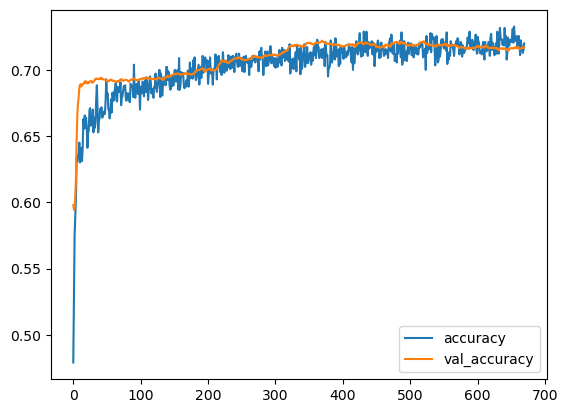

In [27]:
longTriggerANN.network_training(epochs = 3000, batch_size = 512)

In [138]:
filtered_predictions_results_df = longTriggerANN.network_predictions_evaluation(0.4)

132/132 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.78      0.23      0.36      1708
           1       0.65      0.96      0.77      2501

    accuracy                           0.66      4209
   macro avg       0.71      0.59      0.57      4209
weighted avg       0.70      0.66      0.60      4209



132/132 [==============================] - 1s 8ms/step
{'0': {'precision': 0.6666666666666666, 'recall': 0.00117096018735363, 'f1-score': 0.00233781414377557, 'support': 1708}, '1': {'precision': 0.5943889681407513, 'recall': 0.9996001599360256, 'f1-score': 0.745489786789921, 'support': 2501}, 'accuracy': 0.594440484675695, 'macro avg': {'precision': 0.630527817403709, 'recall': 0.5003855600616895, 'f1-score': 0.37391380046684825, 'support': 4209}, 'weighted avg': {'precision': 0.6237190487019922, 'recall': 0.594440484675695, 'f1-score': 0.443920870353804, 'support': 4209}}
132/132 [==============================] - 1s 8ms/step
{'0': {'precision': 0.8214285714285714, 'recall': 0.013466042154566744, 'f1-score': 0.026497695852534562, 'support': 1708}, '1': {'precision': 0.5969863668978713, 'recall': 0.998000799680128, 'f1-score': 0.7470817120622568, 'support': 2501}, 'accuracy': 0.5984794488001901, 'macro avg': {'precision': 0.7092074691632213, 'recall': 0.5057334209173474, 'f1-score': 0

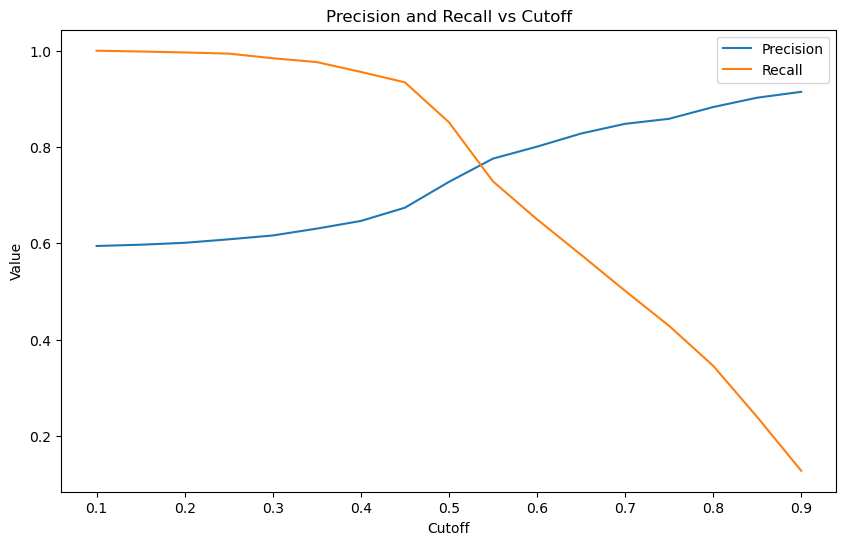

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Inizializza le liste per memorizzare i valori di precision e recall
precision_list = []
recall_list = []
cutoff_values = []

# Ciclo for per calcolare i risultati per ogni valore di cutoff
for cutoff in range(10, 95, 5):
    cutoff_value = cutoff / 100  # Calcola il valore di cutoff da 0.1 a 0.9
    filtered_predictions_results_df, dictionary = longTriggerANN.network_predictions_evaluation(cutoff_value, output_dict=True)
    
    # Aggiungi i valori di precision e recall alla lista
    precision_list.append(dictionary['1']['precision'])
    recall_list.append(dictionary['1']['recall'])
    cutoff_values.append(cutoff_value)

# Crea un DataFrame pandas con i valori di precision, recall e cutoff
df = pd.DataFrame({'Cutoff': cutoff_values, 'Precision': precision_list, 'Recall': recall_list})

# Plot di precision e recall in funzione di cutoff
plt.figure(figsize=(10, 6))
plt.plot(df['Cutoff'], df['Precision'], label='Precision')
plt.plot(df['Cutoff'], df['Recall'], label='Recall')
plt.xlabel('Cutoff')
plt.ylabel('Value')
plt.title('Precision and Recall vs Cutoff')
plt.legend()
plt.show()


### Mixing rule-based (1.5 factor for thresholds) and ANN results

In [62]:

# X_test_data = df_stats_cleaned.tail(len(longTriggerANN.X_test))
# X_test_data = pd.DataFrame(longTriggerANN.X_test, columns=df_stats_cleaned.columns)

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    df_stats_cleaned, 
                                                    Y_data, 
                                                    test_size = 0.7, 
                                                    random_state = 42
                                                   )
X_test_data = pd.DataFrame(X_test, columns=df_stats_cleaned.columns)
X_test_data.shape

(4209, 350)

In [139]:
# Test Split with the same random seed used in the ANN network training 
# for not loosing rows coeherence

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    df_stats_cleaned, 
                                                    Y_data, 
                                                    test_size = 0.7, 
                                                    random_state = 42
                                                   )
X_test_data = pd.DataFrame(X_test, columns=df_stats_cleaned.columns)
X_test_data.shape

data_mixed_test = pd.DataFrame()


# Prediction from the ANN model
filtered_predictions_results_df.reset_index(drop=True, inplace = True)
data_mixed_test['binary_target_long_reached'] = filtered_predictions_results_df['binary_target_long_reached']

# Prediciton from the rule-based base strategy
binary_long_forecast = X_test_data['binary_long_forecast'].astype(int)
binary_long_forecast.reset_index(drop=True, inplace = True)

# Composed predictions
data_mixed_test['binary_long_forecast'] = binary_long_forecast #X_test_data['binary_long_forecast'].astype(int)
data_mixed_test['mixed_forecast'] = 0
data_mixed_test['mixed_forecast'] = ((data_mixed_test['binary_target_long_reached'] == 1) & (data_mixed_test['binary_long_forecast'] == 1)).astype(int)
data_mixed_test['Y_test'] = longTriggerANN.Y_test.reset_index(drop=True)

# predictions = data_mixed_test['mixed_forecast']

# Keep just data with rule-based long signal
filtered_data_mixed_test = data_mixed_test[data_mixed_test['binary_long_forecast'] == 1]
predictions = filtered_data_mixed_test['mixed_forecast']

# print(classification_report(longTriggerANN.Y_test.tail(len(longTriggerANN.X_test)), predictions))
print(classification_report(filtered_data_mixed_test['Y_test'], predictions))



              precision    recall  f1-score   support

           0       0.67      0.01      0.02       500
           1       0.78      1.00      0.87      1737

    accuracy                           0.78      2237
   macro avg       0.72      0.50      0.45      2237
weighted avg       0.75      0.78      0.68      2237



binary_target_long_reached    False
dtype: bool
binary_target_long_reached    False
dtype: bool
Y_test length: 4209
binary_long_forecast length: 4209
132/132 [==============================] - 1s 5ms/step
ANN_long_forecast       False
binary_long_forecast    False
mixed_forecast          False
Y_test                  False
dtype: bool
ANN_long_forecast       False
binary_long_forecast    False
mixed_forecast          False
Y_test                  False
dtype: bool
ANN_long_forecast       False
binary_long_forecast    False
mixed_forecast          False
Y_test                  False
dtype: bool
ANN_long_forecast       False
binary_long_forecast    False
mixed_forecast          False
Y_test                  False
dtype: bool
ANN_long_forecast       False
binary_long_forecast    False
mixed_forecast          False
Y_test                  False
dtype: bool
ANN_long_forecast       False
binary_long_forecast    False
mixed_forecast          False
Y_test                  False
dtype: bool
ANN

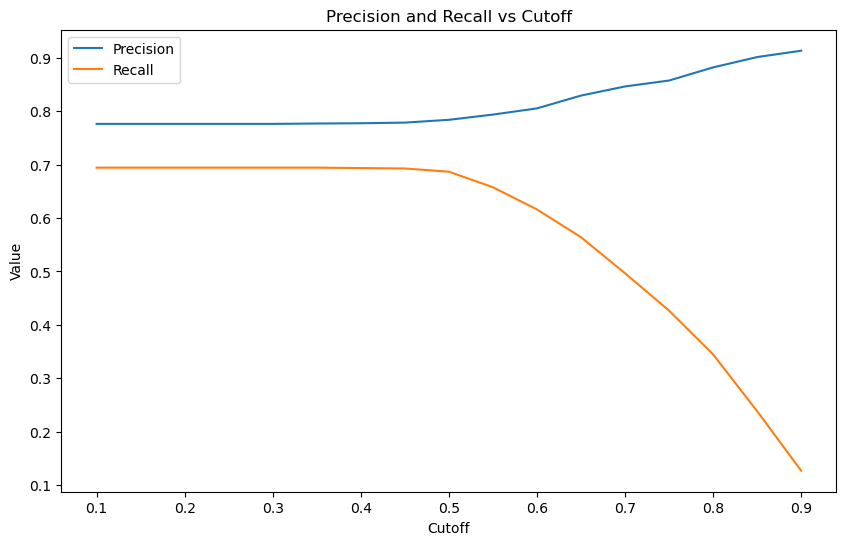

In [141]:

import pandas as pd
import matplotlib.pyplot as plt

# Test Split with the same random seed used in the ANN network training 
# for not loosing rows coeherence

print(Y_data.isna().any())

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    df_stats_cleaned, 
                                                    Y_data, 
                                                    test_size = 0.7, 
                                                    random_state = 42
                                                   )

# X_test_data = pd.DataFrame(X_test, columns=df_stats_cleaned.columns)
# X_train_data = pd.DataFrame(X_train, columns=df_stats_cleaned.columns)

X_train_s = scaler.fit_transform(X_train_data[X_data.columns])
X_test_s = scaler.transform(X_test_data[X_data.columns])

print(Y_test.isna().any())
print(f'Y_test length: {len(Y_test)}')

# Prediciton from the rule-based base strategy
binary_long_forecast = X_test_data['binary_long_forecast'].astype(int)
binary_long_forecast.reset_index(drop=True, inplace = True)

print(f'binary_long_forecast length: {len(binary_long_forecast)}')

# Inizializza le liste per memorizzare i valori di precision e recall
precision_list = []
recall_list = []
cutoff_values = []

# Prediction from the ANN model  
predictions = longTriggerANN.model.predict(X_test_s)
predictions_df = pd.DataFrame(predictions)   


# Ciclo for per calcolare i risultati per ogni valore di cutoff
for cutoff in range(10, 95, 5):
  
    cutoff_value = cutoff / 100  # Calcola il valore di cutoff da 0.1 a 0.9  
        
    data_mixed_test = pd.DataFrame()

    
    filtered_predictions_results = predictions_df[0].apply(lambda x: 1 if x > cutoff_value else 0 ).values
    filtered_predictions_results_df = pd.DataFrame(filtered_predictions_results, columns =['ANN_long_forecast'])
    
#     report = classification_report(Y_test, filtered_predictions_results_d, output_dict = True)


    # Prediction from the ANN model
#     filtered_predictions_results_df.reset_index(drop=True, inplace = True)
    data_mixed_test['ANN_long_forecast'] = filtered_predictions_results_df['ANN_long_forecast']


    # Composed predictions 
    data_mixed_test['binary_long_forecast'] = binary_long_forecast #X_test_data['binary_long_forecast'].astype(int)
    data_mixed_test['mixed_forecast'] = 0
    data_mixed_test['mixed_forecast'] = ((data_mixed_test['ANN_long_forecast'] == 1) & (data_mixed_test['binary_long_forecast'] == 1)).astype(int)
    Y_test['binary_target_long_reached'].reset_index(drop=True, inplace = True)
    data_mixed_test['Y_test'] = Y_test['binary_target_long_reached']    


    # predictions = data_mixed_test['mixed_forecast']

    # Keep just data with rule-based long signal
    filtered_data_mixed_test = data_mixed_test #[data_mixed_test['binary_long_forecast'] == 1]
    predictions = filtered_data_mixed_test['mixed_forecast']
    
    print(filtered_data_mixed_test.isna().any())

    # print(classification_report(longTriggerANN.Y_test.tail(len(longTriggerANN.X_test)), predictions))
#     mixed_prediction_df, dictionary = classification_report(filtered_data_mixed_test['Y_test'], predictions, output_dict = True)
    
    dictionary = classification_report(filtered_data_mixed_test['Y_test'], predictions, output_dict = True)
    
    # Aggiungi i valori di precision e recall alla lista
    precision_list.append(dictionary['1']['precision'])
    recall_list.append(dictionary['1']['recall'])
    cutoff_values.append(cutoff_value)

# Crea un DataFrame pandas con i valori di precision, recall e cutoff
df = pd.DataFrame({'Cutoff': cutoff_values, 'Precision': precision_list, 'Recall': recall_list})

# Plot di precision e recall in funzione di cutoff
plt.figure(figsize=(10, 6))
plt.plot(df['Cutoff'], df['Precision'], label='Precision')
plt.plot(df['Cutoff'], df['Recall'], label='Recall')
plt.xlabel('Cutoff')
plt.ylabel('Value')
plt.title('Precision and Recall vs Cutoff')
plt.legend()
plt.show()


## ANN without rule based strategy for classifying complete min/max swing after 12:00

In [84]:
# balance


df_stats['after_12_full_swing'] = (df_stats['binary_target_long_reached'] == 1) & (df_stats['binary_target_short_reached'] == 1)
df_stats['after_12_full_swing'] = df_stats['after_12_full_swing'].astype(int)
df_stats_full_swing = df_stats[df_stats['after_12_full_swing'] == 1]

df_long_signals_expanded = pd.concat([df_stats] + [df_stats_full_swing] * 4, ignore_index=True)


df_stats_cleaned = df_long_signals_expanded.dropna()

X_data = df_stats_cleaned[[
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
                          'open_at_12_rel_distance_day_-1',
                          '9_to_12_delta_day_-2', 
                          '9_to_12_min_max_period_day_-2', 
                          '9_to_12_min_before_max_day_-2', 
                          'open_at_12_rel_distance_day_-2',
                          'gain_day_-1',
                          'gain_day_-2',
                          'weekly_day',
                          'month',
#                         'CO_mean', 
#                         'HL_mean', 
#                         'Close_delta_mean',
#                         'High_delta_mean', 
#                         'Low_delta_mean',
#                         'CO_std',
#                         'HL_std',
#                         'Close_delta_std',
#                         'High_delta_std',
#                         'Low_delta_std',
#                           '9_to_12_max_minus_9_to_12_max_day_-1',
#                           '9_to_12_max_minus_9_to_12_max_day_-2',
#                           '9_to_12_max_minus_9_to_12_min_day_-1',
#                           '9_to_12_max_minus_9_to_12_min_day_-2',
#                           '9_to_12_min_minus_9_to_12_max_day_-1',
#                           '9_to_12_min_minus_9_to_12_max_day_-2',
#                           '9_to_12_min_minus_9_to_12_min_day_-1',
#                           '9_to_12_min_minus_9_to_12_min_day_-2',
#                           '9_to_12_max_minus_after_12_max_day_-1',
#                           '9_to_12_max_minus_after_12_max_day_-2',
#                           '9_to_12_max_minus_after_12_min_day_-1',
#                           '9_to_12_max_minus_after_12_min_day_-2',
#                           '9_to_12_min_minus_after_12_max_day_-1',
#                           '9_to_12_min_minus_after_12_max_day_-2',
#                           '9_to_12_min_minus_after_12_min_day_-1',
#                           '9_to_12_min_minus_after_12_min_day_-2',                         
#                           '9_to_12_delta_div_9_to_12_delta_day_-1',
#                           '9_to_12_delta_div_9_to_12_delta_day_-2',
                          '9_to_12_delta_div_after_12_min_max_delta_day_-1',
                          '9_to_12_delta_div_after_12_min_max_delta_day_-2',
                          'binary_target_long_reached_day_-1',
                          'binary_target_long_reached_day_-2',
                          'binary_target_short_reached_day_-1',
                          'binary_target_short_reached_day_2',   
                          '9_to_12_rel_maxes_number',
                          '9_to_12_rel_mins_number',
                          'after_12_max_minus_9_to_12_max_day_-1',
                          'after_12_max_minus_9_to_12_max_day_-2',
                          'after_12_min_minus_9_to_12_min_day_-1',
                          'after_12_min_minus_9_to_12_min_day_-2',
                        'pos_CO',
                        'pos_CO_mean',
                        'pos_CO_std',
                        'neg_CO',
                        'neg_CO_mean',
                        'neg_CO_std',
'pos_CO_div_volume_mean',
'pos_CO_div_volume_std',
'neg_CO_div_volume_mean',
'neg_CO_div_volume_std',
'pos_CO_HL_div_volume_mean',
'pos_CO_HL_div_volume_std',
'neg_CO_HL_div_volume_mean',
'neg_CO_HL_div_volume_std',
'pos_CO_volume',
'neg_CO_volume',
    '9_to_12_max_idx_minus_min_idx',
    '9_to_12_max_idx_minus_min_idx_day_-1',
    '9_to_12_max_idx_minus_min_idx_day_-2'

    

                        ]]


Y_data = df_stats_cleaned[['after_12_full_swing']]



In [190]:
# independent balance

scaler = StandardScaler()

def shuffle_split(df, percent):
    # 1. Mescola in modo random le righe di un DataFrame
    df_shuffled = df.sample(frac=1, random_state=42)  # mescola le righe in modo random

    # 2. Estrai due porzioni di percentuale percent e 100 - percent dal DataFrame rimescolato
    percent = 70  # percentuale desiderata per la prima porzione
    num_rows_part1 = int(len(df_shuffled) * percent / 100)
    first_part_df = df_shuffled.iloc[:num_rows_part1]
    second_part_df = df_shuffled.iloc[num_rows_part1:]
    
    return first_part_df, second_part_df
    
df_stats_cleaned = df_stats.dropna()

df_stats_full_swing = df_stats_cleaned[df_stats['after_12_full_swing'] == 1]
train_FS_shuffled, test_FS_shuffled = shuffle_split(df_stats_full_swing, 70)

df_stats_not_full_swing = df_stats_cleaned[df_stats['after_12_full_swing'] == 0]
train_NFS_shuffled, test_NFS_shuffled = shuffle_split(df_stats_not_full_swing, 70)


train_df = pd.concat([train_NFS_shuffled] + [train_FS_shuffled] * 4, ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42)


test_df = pd.concat([test_NFS_shuffled] + [test_FS_shuffled], ignore_index=True)
test_df = test_df.sample(frac=1, random_state=42)

X_train = train_df[[
                        '9_to_12_delta', 
                        '9_to_12_min_max_period', 
                        '9_to_12_min_before_max', 
                        'open_at_12_rel_distance',
                        '9_to_12_delta_day_-1', 
                        '9_to_12_min_max_period_day_-1', 
                        '9_to_12_min_before_max_day_-1', 
                        'open_at_12_rel_distance_day_-1',
                        '9_to_12_delta_day_-2', 
                        '9_to_12_min_max_period_day_-2', 
                        '9_to_12_min_before_max_day_-2', 
                        'open_at_12_rel_distance_day_-2',
                        'gain_day_-1',
                        'gain_day_-2',
                        'weekly_day',
                        'month',
                        '9_to_12_delta_div_after_12_min_max_delta_day_-1',
                        '9_to_12_delta_div_after_12_min_max_delta_day_-2',
                        'binary_target_long_reached_day_-1',
                        'binary_target_long_reached_day_-2',
                        'binary_target_short_reached_day_-1',
                        'binary_target_short_reached_day_2',   
                        '9_to_12_rel_maxes_number',
                        '9_to_12_rel_mins_number',
                        'after_12_max_minus_9_to_12_max_day_-1',
                        'after_12_max_minus_9_to_12_max_day_-2',
                        'after_12_min_minus_9_to_12_min_day_-1',
                        'after_12_min_minus_9_to_12_min_day_-2',
                        'pos_CO',
                        'pos_CO_mean',
                        'pos_CO_std',
                        'neg_CO',
                        'neg_CO_mean',
                        'neg_CO_std',
                        'pos_CO_div_volume_mean',
                        'pos_CO_div_volume_std',
                        'neg_CO_div_volume_mean',
                        'neg_CO_div_volume_std',
                        'pos_CO_HL_div_volume_mean',
                        'pos_CO_HL_div_volume_std',
                        'neg_CO_HL_div_volume_mean',
                        'neg_CO_HL_div_volume_std',
                        'pos_CO_volume',
                        'neg_CO_volume',
                        '9_to_12_max_idx_minus_min_idx',
                        '9_to_12_max_idx_minus_min_idx_day_-1',
                        '9_to_12_max_idx_minus_min_idx_day_-2'    

                        ]]

X_train_s = scaler.fit_transform(X_train)

Y_train = train_df[['after_12_full_swing']]

X_test = test_df[[
                        '9_to_12_delta', 
                        '9_to_12_min_max_period', 
                        '9_to_12_min_before_max', 
                        'open_at_12_rel_distance',
                        '9_to_12_delta_day_-1', 
                        '9_to_12_min_max_period_day_-1', 
                        '9_to_12_min_before_max_day_-1', 
                        'open_at_12_rel_distance_day_-1',
                        '9_to_12_delta_day_-2', 
                        '9_to_12_min_max_period_day_-2', 
                        '9_to_12_min_before_max_day_-2', 
                        'open_at_12_rel_distance_day_-2',
                        'gain_day_-1',
                        'gain_day_-2',
                        'weekly_day',
                        'month',
                        '9_to_12_delta_div_after_12_min_max_delta_day_-1',
                        '9_to_12_delta_div_after_12_min_max_delta_day_-2',
                        'binary_target_long_reached_day_-1',
                        'binary_target_long_reached_day_-2',
                        'binary_target_short_reached_day_-1',
                        'binary_target_short_reached_day_2',   
                        '9_to_12_rel_maxes_number',
                        '9_to_12_rel_mins_number',
                        'after_12_max_minus_9_to_12_max_day_-1',
                        'after_12_max_minus_9_to_12_max_day_-2',
                        'after_12_min_minus_9_to_12_min_day_-1',
                        'after_12_min_minus_9_to_12_min_day_-2',
                        'pos_CO',
                        'pos_CO_mean',
                        'pos_CO_std',
                        'neg_CO',
                        'neg_CO_mean',
                        'neg_CO_std',
                        'pos_CO_div_volume_mean',
                        'pos_CO_div_volume_std',
                        'neg_CO_div_volume_mean',
                        'neg_CO_div_volume_std',
                        'pos_CO_HL_div_volume_mean',
                        'pos_CO_HL_div_volume_std',
                        'neg_CO_HL_div_volume_mean',
                        'neg_CO_HL_div_volume_std',
                        'pos_CO_volume',
                        'neg_CO_volume',
                        '9_to_12_max_idx_minus_min_idx',
                        '9_to_12_max_idx_minus_min_idx_day_-1',
                        '9_to_12_max_idx_minus_min_idx_day_-2'    

                        ]]

X_test_s = scaler.transform(X_test)

Y_test = test_df[['after_12_full_swing']]


C:\Users\Federico\AppData\Local\Temp\ipykernel_17404\4194121817.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Federico\AppData\Local\Temp\ipykernel_17404\4194121817.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [191]:
print(len(df_stats_cleaned))
print(len(df_stats_cleaned[(df_stats_cleaned['binary_target_long_reached'] == 1)  & (df_stats_cleaned['binary_target_short_reached'] == 0)] ))
print(len(df_stats_cleaned[(df_stats_cleaned['binary_target_short_reached'] == 1) & (df_stats_cleaned['binary_target_long_reached'] == 0)]))
print(len(df_stats_cleaned[ (df_stats_cleaned['binary_target_long_reached'] == 1) & (df_stats_cleaned['binary_target_short_reached'] == 1)  ]))
print(len(df_stats_cleaned[ (df_stats_cleaned['binary_target_long_reached'] == 0) & (df_stats_cleaned['binary_target_short_reached'] == 0)  ]))

6012
2313
2077
1284
338


In [162]:
layers_relative_width = [1024, 64, 1]
layers_dropout = [0.9, 0.7, 0]

longTriggerANN = fastANN(
                         X_train_s = X_train_s,
                         Y_train = Y_train,
                         X_test_s = X_test_s,
                         Y_test = Y_test,
                         split_type = 'random', # 'random' 'sequential'
                         model_relative_width = layers_relative_width,
                         model_dropout = layers_dropout,
                         learning_rate = 0.0003,
                         activation = 'relu',
                         last_layer_activation = 'sigmoid',
                         loss = 'binary_crossentropy',
                         save_best_only = True,
                         early_stop_patience = 100,
                         train_size_rate = 0.7,
                         data_storage_path= r"D:\Dropbox\TRADING\DATA\\",
                         model_name = 'Noon Strategy no rules based - full swing - with all kpis'
                        )

In [163]:
longTriggerANN.load_model()

In [72]:
longTriggerANN.network_structure_set_compile()

In [158]:
longTriggerANN.network_training(epochs = 600, batch_size = 1024)

6901
64
0.6
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 24064)             1155072   
                                                                 
 dropout_68 (Dropout)        (None, 24064)             0         
                                                                 
 dense_34 (Dense)            (None, 3008)              72387520  
                                                                 
 dropout_69 (Dropout)        (None, 3008)              0         
                                                                 
 dense_35 (Dense)            (None, 1)                 3009      
                                                                 
Total params: 73,545,601
Trainable params: 73,545,601
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/600
7/7 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.5751
Epoch 1: val_accuracy did not improve from 0.71136
7/7 [==============================] - 31s 4s/step - loss: 0.7100 - accuracy: 0.5751 - val_loss: 0.6825 - val_accuracy: 0.5324
Epoch 2/600
7/7 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.6347
Epoch 2: val_accuracy did not improve from 0.71136
7/7 [==============================] - 34s 5s/step - loss: 0.6351 - accuracy: 0.6347 - val_loss: 0.6952 - val_accuracy: 0.4942
Epoch 3/600
7/7 [==============================] - ETA: 0s - loss: 0.6187 - accuracy: 0.6493
Epoch 3: val_accuracy did not improve from 0.71136
7/7 [==============================] - 34s 5s/step - loss: 0.6187 - accuracy: 0.6493 - val_loss: 0.6228 - val_accuracy: 0.6166
Epoch 4/600
7/7 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.6722
Epoch 4: val_accuracy did not improve from 0.71136
7/7 [==============================] - 34s 

7/7 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8761
Epoch 61: val_accuracy did not improve from 0.71136
7/7 [==============================] - 36s 5s/step - loss: 0.2957 - accuracy: 0.8761 - val_loss: 0.6873 - val_accuracy: 0.6947
Epoch 62/600
7/7 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8767
Epoch 62: val_accuracy did not improve from 0.71136
7/7 [==============================] - 35s 5s/step - loss: 0.2953 - accuracy: 0.8767 - val_loss: 0.6862 - val_accuracy: 0.7030
Epoch 63/600
7/7 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.8767
Epoch 63: val_accuracy did not improve from 0.71136
7/7 [==============================] - 35s 5s/step - loss: 0.2960 - accuracy: 0.8767 - val_loss: 0.6904 - val_accuracy: 0.6936
Epoch 64/600
7/7 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8745
Epoch 64: val_accuracy did not improve from 0.71136
7/7 [==============================] - 42s 6s/st

7/7 [==============================] - 35s 5s/step - loss: 0.1153 - accuracy: 0.9617 - val_loss: 0.9972 - val_accuracy: 0.7247
Epoch 121/600
7/7 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9599
Epoch 121: val_accuracy did not improve from 0.72465
7/7 [==============================] - 34s 5s/step - loss: 0.1116 - accuracy: 0.9599 - val_loss: 1.0055 - val_accuracy: 0.7125
Epoch 122/600
7/7 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9677
Epoch 122: val_accuracy did not improve from 0.72465
7/7 [==============================] - 34s 5s/step - loss: 0.1028 - accuracy: 0.9677 - val_loss: 1.0075 - val_accuracy: 0.6975
Epoch 123/600
7/7 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9667
Epoch 123: val_accuracy did not improve from 0.72465
7/7 [==============================] - 36s 5s/step - loss: 0.0995 - accuracy: 0.9667 - val_loss: 1.0178 - val_accuracy: 0.7047
Epoch 124/600
7/7 [=============================

Epoch 180/600
7/7 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9852
Epoch 180: val_accuracy did not improve from 0.72465
7/7 [==============================] - 35s 5s/step - loss: 0.0488 - accuracy: 0.9852 - val_loss: 1.3088 - val_accuracy: 0.7136
Epoch 181/600
7/7 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9858
Epoch 181: val_accuracy did not improve from 0.72465
7/7 [==============================] - 37s 5s/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 1.3080 - val_accuracy: 0.7169
Epoch 182/600
7/7 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9861
Epoch 182: val_accuracy did not improve from 0.72465
7/7 [==============================] - 36s 5s/step - loss: 0.0453 - accuracy: 0.9861 - val_loss: 1.2977 - val_accuracy: 0.7069
Epoch 183/600
7/7 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9849
Epoch 183: val_accuracy did not improve from 0.72465
7/7 [======================

KeyboardInterrupt: 

In [166]:
longTriggerANN.network_predictions_evaluation(0.9)

57/57 [==============================] - 4s 77ms/step
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1419
           1       0.32      0.10      0.15       386

    accuracy                           0.76      1805
   macro avg       0.56      0.52      0.51      1805
weighted avg       0.69      0.76      0.71      1805



### ANN for min after 12:00 breakdown area

In [52]:

# Calcola la colonna 'mins_below_9_to_12_min'\
df_long_signals['mins_below_9_to_12_min'] = (df_long_signals['after_12_min'] < df_long_signals['9_to_12_min']).astype(int)

# Calcola la colonna 'mins_between_9_to_12_min_max'
df_long_signals['mins_between_9_to_12_min_max'] = ((df_long_signals['after_12_min'] >= df_long_signals['9_to_12_min']) & (df_long_signals['after_12_min'] <= df_long_signals['9_to_12_max'])).astype(int)

# Calcola la colonna 'mins_above_9_to_12_max'
df_long_signals['mins_above_9_to_12_max'] = (df_long_signals['after_12_min'] > df_long_signals['9_to_12_max']).astype(int)

df_long_signals['mins_below_9_to_12_min'].value_counts()

mins_below_9_to_12_min
0    1518
1     689
Name: count, dtype: int64

In [53]:

# Seleziona le righe con gain == -1
df_long_signals_mins_below = df_long_signals[df_long_signals['mins_below_9_to_12_min'] == 1]

# NB: avendo duplicato i dati finali mettendoli tutti di uno stesso tipo il dataset va RIMESCOLATO
# NB: possibile farlo sono con ANN per la quale non ha importanza rispettare ordine cronologico

# Concatena df_long_signals con 4 copie di df_long_signals_loss
df_long_signals_expanded = pd.concat([df_long_signals] + [df_long_signals_mins_below] * 1, ignore_index=True)

X_data = df_long_signals_expanded[[
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
"CO_mean", "HL_mean", "Close_delta_mean", "High_delta_mean", "Low_delta_mean",  "CO_std", "HL_std", "Close_delta_std", "High_delta_std", "Low_delta_std", 
#                           'open_at_12_rel_distance_day_-1',
#                           '9_to_12_delta_day_-2', 
#                           '9_to_12_min_max_period_day_-2', 
#                           '9_to_12_min_before_max_day_-2', 
#                           'open_at_12_rel_distance_day_-2',
                          'gain_day_-1',
#                           'gain_day_-2',
                        ]]

Y_data = df_long_signals_expanded[['mins_below_9_to_12_min']]

In [64]:
model_relative_width = [2024, 128, 32, 1]
model_dropout = [0.9995, 0.9995, 0, 0]

longTriggerANN = fastANN(
                         X_data,
                         Y_data,
                         split_type = 'random',
                         model_relative_width = model_relative_width,
                         model_dropout = model_dropout,
                         learning_rate = 0.0003,
                         activation = 'relu',
                         last_layer_activation = 'sigmoid',
                         loss = 'binary_crossentropy',
                         save_best_only = True,
                         early_stop_patience = 200,
                         train_size_rate = 0.7,
                         data_storage_path= r"D:\Dropbox\TRADING\DATA\\",
                         model_name = 'ANN long triggers'
                        )

In [ ]:
longTriggerANN.network_structure_set_compile()
longTriggerANN.network_training(epochs = 600, batch_size = 1024)

In [63]:
longTriggerANN.network_predictions_evaluation(0.5)

64/64 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.53      0.01      0.02      1073
           1       0.47      0.99      0.64       955

    accuracy                           0.47      2028
   macro avg       0.50      0.50      0.33      2028
weighted avg       0.50      0.47      0.31      2028



## Genetics Algorithm for strategy hyperparameters optimization

In [21]:
# def evaluation_ranges(df):
    
#     df_stats = create_noon_strategy_statistics(df)
    
    

def evaluate_fitness(individual, df):

    
    current_datetime = datetime.now()

    # Formatta la data e l'ora come stringa
    formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M:%S')

    # Stampa la data e l'ora attuali
    print("Data e ora attuali:", formatted_datetime)
    
    coeff_min_thrsd, coeff_max_thrsd = individual
    
    df_stats = create_noon_strategy_statistics(df, 
                                               coeff_min_thrsd = coeff_min_thrsd, 
                                               coeff_max_thrsd = coeff_max_thrsd)
    
    targets_results = targets_reached_resutls(df_stats)
    
   
    
    return (targets_results['long_targets_not_reached'], 
            targets_results['short_targets_not_reached'],
            targets_results['long_targets_reached'], 
            targets_results['short_targets_reached'])


   
def initialize_individual(individual_mins = [0.5, 0.5], individual_maxes = [1.5,1.5]):
    
    
    serie = []
    for i in range(0, len(individual_mins)):
        serie.append( np.random.uniform(individual_mins[i], individual_maxes[i]) )
        
#     print(serie)
        
    return serie




def genetics_noon_strategy_opt(df, 
                               weights, 
                               individual_mins,
                               individual_maxes,
                               individual_samples_number,
                               population_n = 20,
                               NGEN = 50, 
                               CXPB = 0.7, 
                               MUTPB = 0.3):
    
    individual_ranges = []
  
    # Crea il creator per il tipo di fitness (massimizzazione di var1 e minimizzazione di var2 e var3)
    creator.create("FitnessMulti", base.Fitness, weights= weights) #(weigth,)) # loss are always negative so they must be maximized
    
    # Crea il creator per un individuo (una lista di parametri)
    creator.create("Individual", list, fitness=creator.FitnessMulti)
    
    # Inizializzazione della popolazione e delle operazioni genetiche
    toolbox = base.Toolbox()

    
    toolbox.register("individual", tools.initIterate, creator.Individual, initialize_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


#     toolbox.register("evaluate", lambda ind: evaluate_fitness(ind, df))
    toolbox.register("evaluate", evaluate_fitness, df=df)
    
    
    toolbox.register("mate", tools.cxTwoPoint)
#     toolbox.register("mutate",
#                   tools.mutUniformInt,
#                   low = individual_mins, 
#                   up = individual_maxes, 
#                   indpb=0.2)

    toolbox.register("mutate",
                     tools.mutGaussian,
                     mu=0, 
                     sigma=1, 
                     indpb=0.2,
                    )
    
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Set the multiprocessing start method to 'spawn'
#     if multiprocessing.get_start_method() != 'spawn':
#         multiprocessing.set_start_method('spawn')

    cpu_count = multiprocessing.cpu_count()
    print(f"CPU count: {cpu_count}")

    pool = multiprocessing.Pool()
    toolbox.register("map", pool.map)


    # Create the initial population
    population = toolbox.population(n=population_n)

    for gen in range(NGEN):

        offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
        fits = toolbox.map(toolbox.evaluate, offspring)
        count = 0
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
            count += 1

        population = toolbox.select(offspring, k=len(population))

        best_individual = tools.selBest(population, k=1)[0]
        best_fitness = best_individual.fitness.values

        clear_output(wait=True)

        print("Generation number: " + str(gen+1) + "/" + str(NGEN)+ ", population number " + str(count) + "/" + str(population_n))
        print('\tbest_individual: ' + str(best_individual))
        print('\tbest_fitness: ' + str(best_fitness))


    pool.close()
    pool.join()

    best_individual = tools.selBest(population, k=1)[0]
    best_fitness = best_individual.fitness.values

    clear_output(wait=True)

    print("\nGenetics Optimization results:")
    print('\tbest_individual: ' + str(best_individual))
    print('\tbest_fitness: ' + str(best_fitness))

    self.MultiAn_dominant_cycles_df['best_amplitudes'] = best_individual

    best_fitness_value = best_fitness[0]
    self.MultiAn_dominant_cycles_df['best_fitness'] = best_fitness_value

    display(self.MultiAn_dominant_cycles_df)

    amplitudes = best_individual

weights = (-1, -1, 0.5, 0.5)
individual_mins = (0.5, 0.5)
individual_maxes = (1.5, 1.5)
individual_samples_number = 30

# genetics_noon_strategy_opt(df, 
#                                weights, 
#                                individual_mins,
#                                individual_maxes,
#                                individual_samples_number,
#                                population_n = 10,
#                                NGEN = 30, 
#                                CXPB = 0.7, 
#                                MUTPB = 0.3)

In [204]:
import itertools
import numpy as np

N = 16  # Numero di campioni
start_value = 0.51
end_value = 1.49

uniform_values = np.linspace(start_value, end_value, N)

# Crea tutte le possibili combinazioni tra i valori senza duplicati
all_combinations = list(itertools.product(uniform_values, repeat=2))

# df_results = pd.DataFrame()
df_results_list = [] 

# Cicla su tutte le combinazioni
for combination in all_combinations:   
    
    coeff_min_thrsd, coeff_max_thrsd = combination
    
    print(combination)
#     print(coeff_min_thrsd)
#     print(type(coeff_min_thrsd))

    df_stats = create_noon_strategy_statistics(df, 
                                               coeff_min_thrsd = coeff_min_thrsd, 
                                               coeff_max_thrsd = coeff_max_thrsd)
    
    result = targets_reached_resutls(df_stats)
    
#     print(type(result))
    
    
    result['coeff_min_thrsd'] = coeff_min_thrsd
    result['coeff_max_thrsd'] = coeff_max_thrsd
    
#     display(result)
    
#     pd.concat([df_results, pd.DataFrame(result)], ignore_index=True)

    df_results_list.append(result)

# display(df_results_list)
df_list = []

# Itera attraverso ogni dizionario nella lista dei dati
for d in df_results_list:
    # Converti il dizionario in un DataFrame e aggiungi alla lista
    df_list.append(pd.DataFrame([d]))

# Concatena i DataFrame
df_results = pd.concat(df_list, ignore_index=True)

# Ora hai un DataFrame con i dati dalla lista di dizionari
display(df_results)



(0.51, 0.51)
(0.51, 0.5753333333333334)
(0.51, 0.6406666666666667)
(0.51, 0.706)
(0.51, 0.7713333333333333)
(0.51, 0.8366666666666667)
(0.51, 0.9019999999999999)
(0.51, 0.9673333333333333)
(0.51, 1.0326666666666666)
(0.51, 1.0979999999999999)
(0.51, 1.1633333333333333)
(0.51, 1.2286666666666666)
(0.51, 1.294)
(0.51, 1.3593333333333333)
(0.51, 1.4246666666666665)
(0.51, 1.49)
(0.5753333333333334, 0.51)
(0.5753333333333334, 0.5753333333333334)
(0.5753333333333334, 0.6406666666666667)
(0.5753333333333334, 0.706)
(0.5753333333333334, 0.7713333333333333)
(0.5753333333333334, 0.8366666666666667)
(0.5753333333333334, 0.9019999999999999)
(0.5753333333333334, 0.9673333333333333)
(0.5753333333333334, 1.0326666666666666)
(0.5753333333333334, 1.0979999999999999)
(0.5753333333333334, 1.1633333333333333)
(0.5753333333333334, 1.2286666666666666)
(0.5753333333333334, 1.294)
(0.5753333333333334, 1.3593333333333333)
(0.5753333333333334, 1.4246666666666665)
(0.5753333333333334, 1.49)
(0.6406666666666667,

(1.4246666666666665, 1.2286666666666666)
(1.4246666666666665, 1.294)
(1.4246666666666665, 1.3593333333333333)
(1.4246666666666665, 1.4246666666666665)
(1.4246666666666665, 1.49)
(1.49, 0.51)
(1.49, 0.5753333333333334)
(1.49, 0.6406666666666667)
(1.49, 0.706)
(1.49, 0.7713333333333333)
(1.49, 0.8366666666666667)
(1.49, 0.9019999999999999)
(1.49, 0.9673333333333333)
(1.49, 1.0326666666666666)
(1.49, 1.0979999999999999)
(1.49, 1.1633333333333333)
(1.49, 1.2286666666666666)
(1.49, 1.294)
(1.49, 1.3593333333333333)
(1.49, 1.4246666666666665)
(1.49, 1.49)


TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

In [211]:
df_results.to_csv('Noon DAX strategy threshold optimization - 16 points.csv', index=False)

In [42]:
# Importa il file CSV
df_results = pd.read_csv('Noon DAX strategy threshold optimization - 16 points.csv')


In [43]:
df_results.columns

Index(['long_targets_reached', 'long_targets_not_reached',
       'total_long_signals', 'short_targets_reached',
       'short_targets_not_reached', 'total_short_signals',
       'total_targets_reached', 'total_targets_not_reached', 'tatal_signals',
       '12_open_under_min', '12_open_over_min', '12_open_undetermined_area',
       'total_no_signals', 'total_days', 'long_targets_reached_%',
       'long_targets_not_reached_%', 'short_targets_reached_%',
       'short_targets_not_reached_%', 'total_targets_reached_%',
       'total_targets_not_reached_%', 'coeff_min_thrsd', 'coeff_max_thrsd'],
      dtype='object')

In [44]:
import plotly.graph_objects as go

# Supponendo che df_results sia il tuo DataFrame
fig = go.Figure()

df_results = df_results.sort_values(by='coeff_max_thrsd')

# Aggiungi i tracciati per le colonne specifiche
fig.add_trace(go.Scatter(x=df_results['coeff_max_thrsd'], y=df_results['long_targets_reached'], mode='lines', name='Long Targets Reached'))
fig.add_trace(go.Scatter(x=df_results['coeff_max_thrsd'], y=df_results['long_targets_not_reached'], mode='lines', name='Long Targets Not Reached'))
fig.add_trace(go.Scatter(x=df_results['coeff_max_thrsd'], y=df_results['12_open_undetermined_area'], mode='lines', name='12 Open Undetermined Area'))

# Aggiungi etichette agli assi e un titolo al grafico
fig.update_layout(
    xaxis_title='Coefficient Max Threshold',
    yaxis_title='Counts',
    title='Targets and Undetermined Area vs Coefficient Max Threshold'
)

# Visualizza il grafico
fig.show()



# Ordina il DataFrame in base a 'coeff_max_thrsd'
df_results = df_results.sort_values(by='coeff_max_thrsd')

# Calcola le percentuali
df_results['long_targets_reached_%'] = df_results['long_targets_reached'] / (df_results['long_targets_reached'] + df_results['long_targets_not_reached']) * 100
df_results['long_targets_not_reached_%'] = df_results['long_targets_not_reached'] / (df_results['long_targets_reached'] + df_results['long_targets_not_reached']) * 100

# Crea un nuovo grafico
fig_percentage = go.Figure()

# Aggiungi i tracciati per le colonne specifiche
fig_percentage.add_trace(go.Scatter(x=df_results['coeff_max_thrsd'], y=df_results['long_targets_reached_%'], mode='lines', name='Long Targets Reached (%)'))
fig_percentage.add_trace(go.Scatter(x=df_results['coeff_max_thrsd'], y=df_results['long_targets_not_reached_%'], mode='lines', name='Long Targets Not Reached (%)'))

# Aggiungi etichette agli assi e un titolo al grafico
fig_percentage.update_layout(
    xaxis_title='Coefficient Max Threshold',
    yaxis_title='Percentage',
    title='Long Targets Percentage vs Coefficient Max Threshold'
)

# Visualizza il grafico
fig_percentage.show()


## LSTM Networks

### Network class definition: network structure, network training, network validation, results filtering

In [189]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import BatchNormalization

class fastLSTM:

    def __init__(self,
                 X_data,
                 Y_data,
                 model_relative_width = [1],
                 model_dropout = [0],
                 learning_rate = 0.0003,
                 activation = 'tanh', #'relu',
                 last_layer_activation = 'sigmoid',
                 loss = 'binary_crossentropy',
                 batch_size = 128,
                 timesteps = 1,
                 class_weight = None,
                 save_best_only = True,
                 early_stop_patience = 200,
                 train_size_rate = 0.7,
                 data_storage_path="\\cyPredict\\",
                 model_name = 'LSTM'):
        

        
        self.model = Sequential()
        
        self.save_best_only = save_best_only
        
        self.data_storage_path = data_storage_path
        self.model_name = model_name
        
        self.model_relative_width = model_relative_width
        self.model_dropout = model_dropout
        self.learning_rate = learning_rate
        self.activation = activation
        self.last_layer_activation = last_layer_activation
        self.loss = loss
        self.early_stop_patience = early_stop_patience
        self.train_size_rate = train_size_rate
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.class_weight = class_weight
        
        self.loss_df = pd.DataFrame()
        
        
        self.model_summary = {}
        
        self.X_data = X_data
        self.Y_data = Y_data
        self.X_train_s = pd.DataFrame()
        self.Y_train = pd.DataFrame()
        self.X_test_s = pd.DataFrame()
        self.Y_test = pd.DataFrame()

        
        self.scaler = StandardScaler()
        
        self.checkpoint_callback(self.save_best_only)
        
        
        self.early_stop_patience_set(self.early_stop_patience)
        
        
        self.split_and_scale()
        
        self.generator = TimeseriesGenerator(self.X_train_s, pd.DataFrame.to_numpy(self.Y_train), 
                                                                 length=timesteps, 
                                                                 batch_size=batch_size)
        
        self.validation_generator = TimeseriesGenerator(self.X_test_s, pd.DataFrame.to_numpy(self.Y_test), 
                                                                           length=timesteps, 
                                                                           batch_size=batch_size)
            

    def early_stop_patience_set(self, patience):
        
        self.early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = patience)
            
        
    def checkpoint_callback(self, save_best_only):
        
        self.checkpoint_callback = ModelCheckpoint(self.data_storage_path + 'LSTM MODEL - ' + self.model_name +'.h5', 
                                                   monitor='val_accuracy', 
                                                   mode='max', 
                                                   verbose=1, 
                                                   save_best_only=save_best_only)
        
        
    def network_structure_set_compile(self, timesteps = None):
        
        if(timesteps is not None):
            self.timesteps = timesteps
        
        # reset
        self.model = Sequential()
        
        
        # Aggiungi il primo livello LSTM
        self.model.add(LSTM(units=int(self.X_train_s.shape[1] * self.model_relative_width[0]), 
                       return_sequences=True, 
                       input_shape=(self.timesteps, self.X_train_s.shape[1]),
                       activation = self.activation))
        
        self.model.add(Dropout(self.model_dropout[0]))

        
        # inner layers
        for i in range(1, len(self.model_relative_width) - 1):
            
            model_relative_width = self.model_relative_width[i]
            model_dropout = self.model_dropout[i]

            self.model.add(LSTM(units=int(self.X_train_s.shape[1] * model_relative_width), 
                           return_sequences=True, 
                           activation = self.activation))
    
            self.model.add(Dropout(model_dropout))
            
            
            
        # last layer (NB maybe doesn't work for multitargets ... should be number width equal to te number of targets)
        self.model.add(Dense(self.Y_train.shape[1], 
                             activation = self.last_layer_activation)) 

        # compile
        self.model.compile(optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0003),                      
                         loss = self.loss, 
                         metrics = ['accuracy'])
        
            
        # report
        self.model_summary = self.model.summary()
        
        display(self.model_summary)


        
        
    def network_training(self, epochs, batch_size = None, timesteps = None):
        
        if(batch_size is not None):
            
            self.batch_size = batch_size
            
            self.generator = TimeseriesGenerator(self.X_train_s, pd.DataFrame.to_numpy(self.Y_trainI), 
                                                                     length=timesteps, 
                                                                     batch_size=batch_size)

            self.validation_generator = TimeseriesGenerator(self.X_test_s, pd.DataFrame.to_numpy(self.Y_test), 
                                                                               length=timesteps, 
                                                                               batch_size=self.batch_size)

        if(self.class_weight is not None):
            
            print(f'Used class_weight: {self.class_weight}')
            
            self.model.fit(self.generator,
                      epochs = epochs,
                      validation_data = self.validation_generator,
                      class_weight = self.class_weight,
                      callbacks=[self.early_stop, self.checkpoint_callback])           
            
            
        
        else:

            self.model.fit(self.generator,
                      epochs = epochs,
                      validation_data = self.validation_generator,
                      callbacks=[self.early_stop, self.checkpoint_callback])
        
        # save history
        self.loss_df = pd.DataFrame(self.model.history.history)
        self.loss_df.to_csv(self.data_storage_path + 'LSTM MODEL - ' + self.model_name + ' - TRAINING HISTORY.csv')
                
        # keep the best model
        self.model = load_model(self.data_storage_path + 'LSTM MODEL - ' + self.model_name +'.h5')
        
        # plot history
        self.plot_training_history()
        
        
    def load_model(self, file_path_name = None):
        
        if(file_path_name is not None):
            self.model = pd.read_csv(file_path_name)
            
        else:
            self.model = load_model(self.data_storage_path + 'LSTM MODEL - ' + self.model_name +'.h5')

            
    def load_training_history(self, file_path_name = None):
        
        if(file_path_name is not None):
            self.loss_df = pd.read_csv(file_path_name)
            
        else:
            self.loss_df = pd.read_csv(self.data_storage_path + 'LSTM MODEL - ' + self.model_name + ' - TRAINING HISTORY.csv')
        
        
    def network_predictions_evaluation(self, min_probability, output_dict = False):        

        predictions = self.model.predict(self.validation_generator)
        reshaped_predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])
        predictions_df = pd.DataFrame(reshaped_predictions)
        
        # Cut off predictions with low probability
#         predictions = self.model.predict(self.X_test_s)
#         predictions_df = pd.DataFrame(predictions)
        filtered_predictions_results_df = pd.DataFrame()
    
        print(predictions_df.columns)
        print(predictions_df.shape)
        print(predictions_df.tail(5))
        print(self.Y_test.shape)
        
        
        
        count = 0
        for col_name, col_data in self.Y_data.items():
            filtered_predictions_results_df[col_name] = predictions_df[count].apply(lambda x: 1 if x > min_probability else 0 ).values

            if(output_dict == True):
                report  = classification_report(self.Y_test[col_name][self.timesteps:], filtered_predictions_results_df[col_name], output_dict = False)
            
            else:
                report  = classification_report(self.Y_test[col_name][self.timesteps:], filtered_predictions_results_df[col_name])
            
            print(classification_report)
            count += 1

        if(output_dict == True):
            return classification_report
        
    
    def plot_training_history(self):
            
        self.loss_df[['accuracy', 'val_accuracy']].plot()
        
        
    def split_and_scale(self):        
        

        train_size = int(len(self.X_data) * self.train_size_rate)
        test_size = len(self.X_data) - train_size

        self.X_train = self.X_data.head(train_size)
        self.Y_train = self.Y_data.head(train_size)
        self.X_test = self.X_data.tail(test_size)
        self.Y_test = self.Y_data.tail(test_size)

        print(f"Shape of Y_train: {self.Y_train.shape}")
        print(f"Shape of Y_test: {self.Y_test.shape}")


        self.X_train_s = self.scaler.fit_transform(self.X_train)
        self.X_test_s = self.scaler.transform(self.X_test)
        

        
        

        

## LSTM without rule based strategy for classifying complete min/max swing after 12:00

In [129]:
# balance

# # Seleziona le righe con gain == -1
# df_long_signals_loss = df_long_signals[df_long_signals['gain'] == -1]

# # # Concatena df_long_signals con 4 copie di df_long_signals_loss
# # df_long_signals_expanded = pd.concat([df_long_signals] + [df_long_signals_loss] * 4, ignore_index=True)

# df_long_signals_expanded['binary_gain'] = df_long_signals_expanded['gain'].apply(lambda x: 1 if x == 1 else 0)

df_stats['after_12_full_swing'] = (df_stats['binary_target_long_reached'] == 1) & (df_stats['binary_target_short_reached'] == 1)
df_stats['after_12_full_swing'] = df_stats['after_12_full_swing'].astype(int)
# df_stats_full_swing = df_stats[df_stats['after_12_full_swing'] == 1]

df_stats['9_to_12_min_minus_after_12_min_day_-1'] = df_stats['after_12_min_minus_9_to_12_min_day_-1'] * -1

# df_long_signals_expanded = pd.concat([df_stats] + [df_stats_full_swing] * 4, ignore_index=True)


df_stats_cleaned = df_stats.dropna()

X_data = df_stats_cleaned[[
                            '9_to_12_delta', 
                            '9_to_12_min_max_period', 
                            '9_to_12_min_before_max', 
                            'open_at_12_rel_distance',
                            'gain_day_-1',
#                             'gain_day_-2',
                            'weekly_day',
                            'month',
                            '9_to_12_delta_div_after_12_min_max_delta_day_-1',
#                             '9_to_12_delta_div_after_12_min_max_delta_day_-2',
                            'binary_target_long_reached_day_-1',
#                             'binary_target_long_reached_day_-2',
                            'binary_target_short_reached_day_-1',
#                             'binary_target_short_reached_day_2',   
                            '9_to_12_rel_maxes_number',
                            '9_to_12_rel_mins_number',
                            'after_12_max_minus_9_to_12_max_day_-1',
#                             'after_12_max_minus_9_to_12_max_day_-2',
                            '9_to_12_min_minus_after_12_min_day_-1',
#                             'after_12_min_minus_9_to_12_min_day_-2',
                            'pos_CO',
                            'pos_CO_mean',
                            'pos_CO_std',
                            'neg_CO',
                            'neg_CO_mean',
                            'neg_CO_std',
                            'pos_CO_div_volume_mean',
                            'pos_CO_div_volume_std',
                            'neg_CO_div_volume_mean',
                            'neg_CO_div_volume_std',
                            'pos_CO_HL_div_volume_mean',
                            'pos_CO_HL_div_volume_std',
                            'neg_CO_HL_div_volume_mean',
                            'neg_CO_HL_div_volume_std',
                            'pos_CO_volume',
                            'neg_CO_volume',
                            '9_to_12_max_idx_minus_min_idx'

    

                        ]]


Y_data = df_stats_cleaned[['after_12_full_swing']]

count_1 = (Y_data['after_12_full_swing'] == 1).sum()
count_0 = (Y_data['after_12_full_swing'] == 0).sum()
total = count_0 + count_1

weight_for_0 = (1 / count_0) * (total / 2.0)
weight_for_1 = 8 #(1 / count_1) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

# https://stats.stackexchange.com/questions/342170/how-to-train-an-lstm-when-the-sequence-has-imbalanced-classes
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=it


{0: 0.6357868020304568, 1: 8}


In [130]:
layers_relative_width = [128, 8, 0.25]
layers_dropout = [0.8, 0.5, 0]

longTriggerLSTM = fastLSTM(
                         X_data,
                         Y_data,

                         model_relative_width = layers_relative_width,
                         model_dropout = layers_dropout,
                         learning_rate = 0.0003,
                         activation = 'relu', #'tanh', #'relu',
                         last_layer_activation = 'sigmoid',
                         loss = 'binary_crossentropy',
                         batch_size = 128,
                         timesteps = 1,
                         save_best_only = True,
                         early_stop_patience = 100,
                         train_size_rate = 0.7,
                         class_weight = class_weight,
                         data_storage_path= r"D:\Dropbox\TRADING\DATA\\",
                         model_name = 'Noon Strategy no rules based - full swing - with all kpis'
                        )

Shape of Y_train: (4208, 1)
Shape of Y_test: (1804, 1)


In [ ]:
longTriggerLSTM.network_structure_set_compile()

Used class_weight: {0: 0.6357868020304568, 1: 8}
Epoch 1/400
33/33 [==============================] - ETA: 0s - loss: 0.7553 - accuracy: 0.5764
Epoch 1: val_accuracy did not improve from 0.66999
33/33 [==============================] - 42s 1s/step - loss: 0.7553 - accuracy: 0.5764 - val_loss: 1.3380 - val_accuracy: 0.5912
Epoch 2/400
33/33 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.5683
Epoch 2: val_accuracy did not improve from 0.66999
33/33 [==============================] - 40s 1s/step - loss: 0.7561 - accuracy: 0.5683 - val_loss: 1.2964 - val_accuracy: 0.6095
Epoch 3/400
33/33 [==============================] - ETA: 0s - loss: 0.7577 - accuracy: 0.5612
Epoch 3: val_accuracy did not improve from 0.66999
33/33 [==============================] - 41s 1s/step - loss: 0.7577 - accuracy: 0.5612 - val_loss: 1.2740 - val_accuracy: 0.6234
Epoch 4/400
33/33 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.5781
Epoch 4: val_accuracy did not i

33/33 [==============================] - 46s 1s/step - loss: 0.7396 - accuracy: 0.5702 - val_loss: 1.2687 - val_accuracy: 0.6423
Epoch 31/400
33/33 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.5821
Epoch 31: val_accuracy did not improve from 0.66999
33/33 [==============================] - 48s 1s/step - loss: 0.7349 - accuracy: 0.5821 - val_loss: 1.3121 - val_accuracy: 0.6084
Epoch 32/400
33/33 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.5788
Epoch 32: val_accuracy did not improve from 0.66999
33/33 [==============================] - 48s 1s/step - loss: 0.7332 - accuracy: 0.5788 - val_loss: 1.2967 - val_accuracy: 0.6151
Epoch 33/400
33/33 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.5904
Epoch 33: val_accuracy did not improve from 0.66999
33/33 [==============================] - 47s 1s/step - loss: 0.7190 - accuracy: 0.5904 - val_loss: 1.2879 - val_accuracy: 0.6439
Epoch 34/400
33/33 [====================

Epoch 90/400
33/33 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5926
Epoch 90: val_accuracy did not improve from 0.66999
33/33 [==============================] - 48s 1s/step - loss: 0.6928 - accuracy: 0.5926 - val_loss: 1.3141 - val_accuracy: 0.6678
Epoch 91/400
33/33 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.6320
Epoch 91: val_accuracy did not improve from 0.66999
33/33 [==============================] - 47s 1s/step - loss: 0.6613 - accuracy: 0.6320 - val_loss: 1.3830 - val_accuracy: 0.6539
Epoch 92/400
33/33 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.6126
Epoch 92: val_accuracy did not improve from 0.66999
33/33 [==============================] - 48s 1s/step - loss: 0.7237 - accuracy: 0.6126 - val_loss: 1.3751 - val_accuracy: 0.6389
Epoch 93/400
33/33 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.6149
Epoch 93: val_accuracy did not improve from 0.66999
33/33 [==============

33/33 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.6370
Epoch 119: val_accuracy did not improve from 0.68996
33/33 [==============================] - 47s 1s/step - loss: 0.6420 - accuracy: 0.6370 - val_loss: 1.3501 - val_accuracy: 0.6683
Epoch 120/400
33/33 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.6344
Epoch 120: val_accuracy did not improve from 0.68996
33/33 [==============================] - 47s 1s/step - loss: 0.6442 - accuracy: 0.6344 - val_loss: 1.3377 - val_accuracy: 0.6633
Epoch 121/400
33/33 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.6268
Epoch 121: val_accuracy did not improve from 0.68996
33/33 [==============================] - 47s 1s/step - loss: 0.7103 - accuracy: 0.6268 - val_loss: 1.3886 - val_accuracy: 0.6384
Epoch 122/400
33/33 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.6515
Epoch 122: val_accuracy did not improve from 0.68996
33/33 [====================

33/33 [==============================] - 47s 1s/step - loss: 0.6428 - accuracy: 0.6456 - val_loss: 1.4128 - val_accuracy: 0.6617
Epoch 149/400
33/33 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.6599
Epoch 149: val_accuracy did not improve from 0.68996
33/33 [==============================] - 48s 1s/step - loss: 0.6052 - accuracy: 0.6599 - val_loss: 1.4180 - val_accuracy: 0.6589
Epoch 150/400
33/33 [==============================] - ETA: 0s - loss: 0.6318 - accuracy: 0.6568
Epoch 150: val_accuracy did not improve from 0.68996
33/33 [==============================] - 48s 1s/step - loss: 0.6318 - accuracy: 0.6568 - val_loss: 1.3729 - val_accuracy: 0.6711
Epoch 151/400
33/33 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.6534
Epoch 151: val_accuracy did not improve from 0.68996
33/33 [==============================] - 48s 1s/step - loss: 0.6119 - accuracy: 0.6534 - val_loss: 1.3866 - val_accuracy: 0.6550
Epoch 152/400
33/33 [=============

33/33 [==============================] - 49s 1s/step - loss: 0.5942 - accuracy: 0.6748 - val_loss: 1.4360 - val_accuracy: 0.6395
Epoch 178/400
33/33 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.6782
Epoch 178: val_accuracy did not improve from 0.69329
33/33 [==============================] - 50s 2s/step - loss: 0.5959 - accuracy: 0.6782 - val_loss: 1.4023 - val_accuracy: 0.6811
Epoch 179/400
33/33 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.6698
Epoch 179: val_accuracy did not improve from 0.69329
33/33 [==============================] - 50s 2s/step - loss: 0.5891 - accuracy: 0.6698 - val_loss: 1.4391 - val_accuracy: 0.6534
Epoch 180/400
33/33 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.6767
Epoch 180: val_accuracy did not improve from 0.69329
33/33 [==============================] - 50s 2s/step - loss: 0.5962 - accuracy: 0.6767 - val_loss: 1.4371 - val_accuracy: 0.6622
Epoch 181/400
33/33 [=============

33/33 [==============================] - 49s 1s/step - loss: 0.5788 - accuracy: 0.6774 - val_loss: 1.4595 - val_accuracy: 0.6683
Epoch 207/400
33/33 [==============================] - ETA: 0s - loss: 0.5615 - accuracy: 0.6979
Epoch 207: val_accuracy did not improve from 0.71215
33/33 [==============================] - 50s 2s/step - loss: 0.5615 - accuracy: 0.6979 - val_loss: 1.4361 - val_accuracy: 0.6733
Epoch 208/400
33/33 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.6969
Epoch 208: val_accuracy did not improve from 0.71215
33/33 [==============================] - 49s 1s/step - loss: 0.5850 - accuracy: 0.6969 - val_loss: 1.4630 - val_accuracy: 0.6545
Epoch 209/400
33/33 [==============================] - ETA: 0s - loss: 0.5661 - accuracy: 0.6874
Epoch 209: val_accuracy did not improve from 0.71215
33/33 [==============================] - 49s 1s/step - loss: 0.5661 - accuracy: 0.6874 - val_loss: 1.4083 - val_accuracy: 0.6861
Epoch 210/400
33/33 [=============

Epoch 236/400
33/33 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.6924
Epoch 236: val_accuracy did not improve from 0.71215
33/33 [==============================] - 50s 2s/step - loss: 0.5793 - accuracy: 0.6924 - val_loss: 1.4954 - val_accuracy: 0.6484
Epoch 237/400
33/33 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.7043
Epoch 237: val_accuracy did not improve from 0.71215
33/33 [==============================] - 50s 2s/step - loss: 0.5532 - accuracy: 0.7043 - val_loss: 1.4634 - val_accuracy: 0.6705
Epoch 238/400
33/33 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.7079
Epoch 238: val_accuracy did not improve from 0.71215
33/33 [==============================] - 52s 2s/step - loss: 0.5435 - accuracy: 0.7079 - val_loss: 1.4588 - val_accuracy: 0.6550
Epoch 239/400
33/33 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7010
Epoch 239: val_accuracy did not improve from 0.71215
33/33 [======

33/33 [==============================] - 49s 1s/step - loss: 0.5332 - accuracy: 0.7152 - val_loss: 1.5507 - val_accuracy: 0.6789
Epoch 266/400
33/33 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.7228
Epoch 266: val_accuracy did not improve from 0.71215
33/33 [==============================] - 49s 1s/step - loss: 0.5408 - accuracy: 0.7228 - val_loss: 1.5366 - val_accuracy: 0.6656
Epoch 267/400
33/33 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.7145
Epoch 267: val_accuracy did not improve from 0.71215
33/33 [==============================] - 49s 1s/step - loss: 0.5387 - accuracy: 0.7145 - val_loss: 1.5398 - val_accuracy: 0.6861
Epoch 268/400
33/33 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7219
Epoch 268: val_accuracy did not improve from 0.71215
33/33 [==============================] - 49s 1s/step - loss: 0.5646 - accuracy: 0.7219 - val_loss: 1.5335 - val_accuracy: 0.6961
Epoch 269/400
33/33 [=============

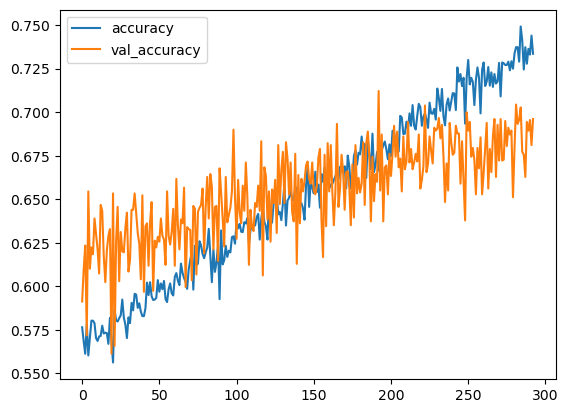

In [135]:
longTriggerLSTM.network_training(epochs = 400)

In [132]:
longTriggerLSTM.load_model()
longTriggerLSTM.load_training_history()

In [139]:
longTriggerLSTM.network_predictions_evaluation(0.2)

15/15 [==============================] - 2s 110ms/step
RangeIndex(start=0, stop=1, step=1)
(1803, 1)
                 0
1798  4.008018e-10
1799  8.356622e-01
1800  1.768061e-02
1801  2.704380e-01
1802  2.572325e-01
(1804, 1)
Index(['after_12_full_swing'], dtype='object')
(1803, 1)
      after_12_full_swing
1798                    0
1799                    1
1800                    0
1801                    1
1802                    1
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1480
           1       0.20      0.34      0.25       323

    accuracy                           0.64      1803
   macro avg       0.51      0.52      0.51      1803
weighted avg       0.72      0.64      0.67      1803



## LSTM for regression on min/max before 12:00 and afternoon min/max deltas 

In [83]:
# balance

# # Seleziona le righe con gain == -1
# df_long_signals_loss = df_long_signals[df_long_signals['gain'] == -1]

# # # Concatena df_long_signals con 4 copie di df_long_signals_loss
# # df_long_signals_expanded = pd.concat([df_long_signals] + [df_long_signals_loss] * 4, ignore_index=True)

# df_long_signals_expanded['binary_gain'] = df_long_signals_expanded['gain'].apply(lambda x: 1 if x == 1 else 0)

df_stats['after_12_full_swing'] = (df_stats['binary_target_long_reached'] == 1) & (df_stats['binary_target_short_reached'] == 1)
df_stats['after_12_full_swing'] = df_stats['after_12_full_swing'].astype(int)
# df_stats_full_swing = df_stats[df_stats['after_12_full_swing'] == 1]

df_stats['9_to_12_min_minus_after_12_min'] = df_stats['after_12_min_minus_9_to_12_min'] * -1
df_stats['9_to_12_min_minus_after_12_min_day_-1'] = df_stats['after_12_min_minus_9_to_12_min_day_-1'] * -1

# df_long_signals_expanded = pd.concat([df_stats] + [df_stats_full_swing] * 4, ignore_index=True)


df_stats_cleaned = df_stats.dropna()

X_data = df_stats_cleaned[[
                            '9_to_12_delta', 
                            '9_to_12_min_max_period', 
                            '9_to_12_min_before_max', 
                            'open_at_12_rel_distance',
                            'gain_day_-1',
#                             'gain_day_-2',
                            'weekly_day',
                            'month',
                            '9_to_12_delta_div_after_12_min_max_delta_day_-1',
#                             '9_to_12_delta_div_after_12_min_max_delta_day_-2',
                            'binary_target_long_reached_day_-1',
#                             'binary_target_long_reached_day_-2',
                            'binary_target_short_reached_day_-1',
#                             'binary_target_short_reached_day_2',   
                            '9_to_12_rel_maxes_number',
                            '9_to_12_rel_mins_number',
                            'after_12_max_minus_9_to_12_max_day_-1',
#                             'after_12_max_minus_9_to_12_max_day_-2',
                            '9_to_12_min_minus_after_12_min_day_-1',
#                             'after_12_min_minus_9_to_12_min_day_-2',
                            'pos_CO',
                            'pos_CO_mean',
                            'pos_CO_std',
                            'neg_CO',
                            'neg_CO_mean',
                            'neg_CO_std',
                            'pos_CO_div_volume_mean',
                            'pos_CO_div_volume_std',
                            'neg_CO_div_volume_mean',
                            'neg_CO_div_volume_std',
                            'pos_CO_HL_div_volume_mean',
                            'pos_CO_HL_div_volume_std',
                            'neg_CO_HL_div_volume_mean',
                            'neg_CO_HL_div_volume_std',
                            'pos_CO_volume',
                            'neg_CO_volume',
                            '9_to_12_max_idx_minus_min_idx'

    

                        ]]


Y_data = df_stats_cleaned[['after_12_max_minus_9_to_12_max', '9_to_12_min_minus_after_12_min']]



In [92]:
layers_relative_width = [16, 4, 1]
layers_dropout = [0, 0, 0]

longTriggerLSTM = fastLSTM(
                         X_data,
                         Y_data,

                         model_relative_width = layers_relative_width,
                         model_dropout = layers_dropout,
                         learning_rate = 0.0003,
                         activation = 'relu', #'tanh', #'relu',
                         last_layer_activation = 'linear', # for regression 'linear' # 'sigmoid'
                         loss = 'mean_squared_error', # for regression 'mean_squared_error' # 'binary_crossentropy'
                         batch_size = 256,
                         timesteps = 1,
                         save_best_only = True,
                         early_stop_patience = 300,
                         train_size_rate = 0.7,
                         data_storage_path= r"D:\Dropbox\TRADING\DATA\\",
                         model_name = 'Noon Strategy no rules based - regression on before after noon min and maxe deltas'
                        )

Shape of Y_train: (4208, 2)
Shape of Y_test: (1804, 2)


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 1, 496)            1047552   
                                                                 
 dropout_44 (Dropout)        (None, 1, 496)            0         
                                                                 
 lstm_45 (LSTM)              (None, 1, 124)            308016    
                                                                 
 dropout_45 (Dropout)        (None, 1, 124)            0         
                                                                 
 dense_15 (Dense)            (None, 1, 2)              250       
                                                                 
Total params: 1,355,818
Trainable params: 1,355,818
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/1000
17/17 [==============================] - ETA: 0s - loss: 3143.2117 - accuracy: 0.0061
Epoch 1: val_accuracy improved from -inf to 0.00499, saving model to D:\Dropbox\TRADING\DATA\LSTM MODEL - Noon Strategy no rules based - regression on before after noon min and maxe deltas.h5
17/17 [==============================] - 4s 71ms/step - loss: 3143.2117 - accuracy: 0.0061 - val_loss: 7079.3154 - val_accuracy: 0.0050
Epoch 2/1000
17/17 [==============================] - ETA: 0s - loss: 3141.3213 - accuracy: 0.0059
Epoch 2: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 45ms/step - loss: 3141.3213 - accuracy: 0.0059 - val_loss: 7074.5601 - val_accuracy: 0.0047
Epoch 3/1000
17/17 [==============================] - ETA: 0s - loss: 3138.0354 - accuracy: 0.0050
Epoch 3: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 52ms/step - loss: 3138.0354 - accuracy: 0.0050 - val_loss: 7065.3721 - val_accuracy: 0.0047
E

17/17 [==============================] - ETA: 0s - loss: 2935.2007 - accuracy: 0.0049
Epoch 29: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 51ms/step - loss: 2935.2007 - accuracy: 0.0049 - val_loss: 6793.2275 - val_accuracy: 0.0047
Epoch 30/1000
17/17 [==============================] - ETA: 0s - loss: 2934.0842 - accuracy: 0.0049
Epoch 30: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 52ms/step - loss: 2934.0842 - accuracy: 0.0049 - val_loss: 6792.6768 - val_accuracy: 0.0047
Epoch 31/1000
17/17 [==============================] - ETA: 0s - loss: 2934.1257 - accuracy: 0.0049
Epoch 31: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 51ms/step - loss: 2934.1257 - accuracy: 0.0049 - val_loss: 6790.1030 - val_accuracy: 0.0047
Epoch 32/1000
17/17 [==============================] - ETA: 0s - loss: 2933.4387 - accuracy: 0.0050
Epoch 32: val_accuracy did not improve from 0.0049

17/17 [==============================] - 1s 51ms/step - loss: 2927.1584 - accuracy: 0.0052 - val_loss: 6807.4595 - val_accuracy: 0.0047
Epoch 58/1000
17/17 [==============================] - ETA: 0s - loss: 2927.7493 - accuracy: 0.0051
Epoch 58: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 49ms/step - loss: 2927.7493 - accuracy: 0.0051 - val_loss: 6805.1411 - val_accuracy: 0.0047
Epoch 59/1000
17/17 [==============================] - ETA: 0s - loss: 2926.8694 - accuracy: 0.0049
Epoch 59: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 49ms/step - loss: 2926.8694 - accuracy: 0.0049 - val_loss: 6806.3140 - val_accuracy: 0.0047
Epoch 60/1000
17/17 [==============================] - ETA: 0s - loss: 2926.5623 - accuracy: 0.0049
Epoch 60: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 48ms/step - loss: 2926.5623 - accuracy: 0.0049 - val_loss: 6805.2456 - val_accuracy: 0.0047


Epoch 86/1000
17/17 [==============================] - ETA: 0s - loss: 2924.0642 - accuracy: 0.0058
Epoch 86: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 51ms/step - loss: 2924.0642 - accuracy: 0.0058 - val_loss: 6819.3071 - val_accuracy: 0.0047
Epoch 87/1000
17/17 [==============================] - ETA: 0s - loss: 2924.3474 - accuracy: 0.0056
Epoch 87: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 54ms/step - loss: 2924.3474 - accuracy: 0.0056 - val_loss: 6816.2124 - val_accuracy: 0.0047
Epoch 88/1000
17/17 [==============================] - ETA: 0s - loss: 2924.2451 - accuracy: 0.0053
Epoch 88: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 53ms/step - loss: 2924.2451 - accuracy: 0.0053 - val_loss: 6823.7217 - val_accuracy: 0.0047
Epoch 89/1000
17/17 [==============================] - ETA: 0s - loss: 2925.2424 - accuracy: 0.0050
Epoch 89: val_accuracy did not impro

17/17 [==============================] - 1s 53ms/step - loss: 2922.7998 - accuracy: 0.0055 - val_loss: 6828.5508 - val_accuracy: 0.0047
Epoch 115/1000
17/17 [==============================] - ETA: 0s - loss: 2922.8384 - accuracy: 0.0055
Epoch 115: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 54ms/step - loss: 2922.8384 - accuracy: 0.0055 - val_loss: 6827.9009 - val_accuracy: 0.0047
Epoch 116/1000
17/17 [==============================] - ETA: 0s - loss: 2922.0969 - accuracy: 0.0055
Epoch 116: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 53ms/step - loss: 2922.0969 - accuracy: 0.0055 - val_loss: 6832.5254 - val_accuracy: 0.0047
Epoch 117/1000
16/17 [===========================>..] - ETA: 0s - loss: 2636.2205 - accuracy: 0.0057
Epoch 117: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 57ms/step - loss: 2922.7732 - accuracy: 0.0055 - val_loss: 6830.4419 - val_accuracy: 0

Epoch 143/1000
17/17 [==============================] - ETA: 0s - loss: 2921.3159 - accuracy: 0.0055
Epoch 143: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 59ms/step - loss: 2921.3159 - accuracy: 0.0055 - val_loss: 6838.1250 - val_accuracy: 0.0047
Epoch 144/1000
17/17 [==============================] - ETA: 0s - loss: 2921.6375 - accuracy: 0.0053
Epoch 144: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 56ms/step - loss: 2921.6375 - accuracy: 0.0053 - val_loss: 6836.6719 - val_accuracy: 0.0047
Epoch 145/1000
16/17 [===========================>..] - ETA: 0s - loss: 2886.2642 - accuracy: 0.0056
Epoch 145: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 58ms/step - loss: 2920.4324 - accuracy: 0.0053 - val_loss: 6834.1143 - val_accuracy: 0.0047
Epoch 146/1000
16/17 [===========================>..] - ETA: 0s - loss: 2803.7622 - accuracy: 0.0054
Epoch 146: val_accuracy did n

17/17 [==============================] - ETA: 0s - loss: 2919.9863 - accuracy: 0.0052
Epoch 199: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 60ms/step - loss: 2919.9863 - accuracy: 0.0052 - val_loss: 6842.0596 - val_accuracy: 0.0047
Epoch 200/1000
17/17 [==============================] - ETA: 0s - loss: 2918.5493 - accuracy: 0.0052
Epoch 200: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 64ms/step - loss: 2918.5493 - accuracy: 0.0052 - val_loss: 6840.4531 - val_accuracy: 0.0047
Epoch 201/1000
17/17 [==============================] - ETA: 0s - loss: 2919.3792 - accuracy: 0.0052
Epoch 201: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 55ms/step - loss: 2919.3792 - accuracy: 0.0052 - val_loss: 6838.8950 - val_accuracy: 0.0047
Epoch 202/1000
16/17 [===========================>..] - ETA: 0s - loss: 2983.0234 - accuracy: 0.0053
Epoch 202: val_accuracy did not improve from

17/17 [==============================] - ETA: 0s - loss: 2917.7917 - accuracy: 0.0051
Epoch 255: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 58ms/step - loss: 2917.7917 - accuracy: 0.0051 - val_loss: 6835.7544 - val_accuracy: 0.0047
Epoch 256/1000
17/17 [==============================] - ETA: 0s - loss: 2917.0857 - accuracy: 0.0050
Epoch 256: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 58ms/step - loss: 2917.0857 - accuracy: 0.0050 - val_loss: 6834.7075 - val_accuracy: 0.0047
Epoch 257/1000
17/17 [==============================] - ETA: 0s - loss: 2917.2441 - accuracy: 0.0052
Epoch 257: val_accuracy did not improve from 0.00499
17/17 [==============================] - 1s 58ms/step - loss: 2917.2441 - accuracy: 0.0052 - val_loss: 6837.4814 - val_accuracy: 0.0047
Epoch 258/1000
17/17 [==============================] - ETA: 0s - loss: 2917.3933 - accuracy: 0.0051
Epoch 258: val_accuracy did not improve from

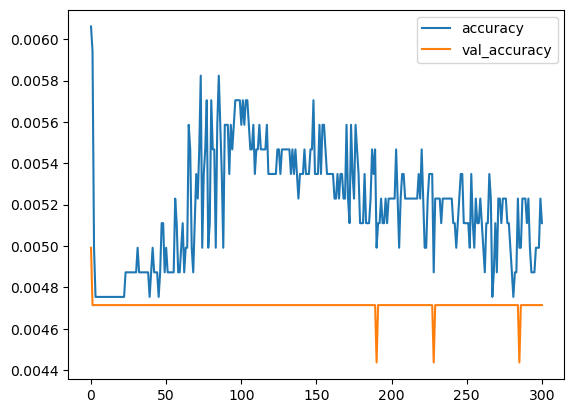

In [93]:
longTriggerLSTM.network_structure_set_compile()
longTriggerLSTM.network_training(epochs = 1000)

<AxesSubplot: >

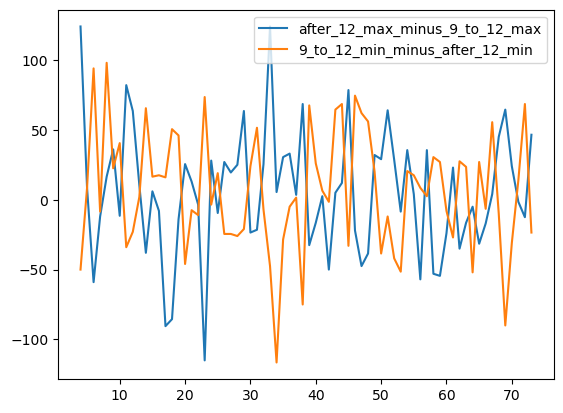

In [89]:
df_stats_cleaned.head(70)[['after_12_max_minus_9_to_12_max', '9_to_12_min_minus_after_12_min']].plot()

## LSTM for binary classifcation of long signals without rules

In [284]:
# balance

# # Seleziona le righe con gain == -1
# df_long_signals_loss = df_long_signals[df_long_signals['gain'] == -1]

# # # Concatena df_long_signals con 4 copie di df_long_signals_loss
# # df_long_signals_expanded = pd.concat([df_long_signals] + [df_long_signals_loss] * 4, ignore_index=True)

# df_long_signals_expanded['binary_gain'] = df_long_signals_expanded['gain'].apply(lambda x: 1 if x == 1 else 0)

df_stats_cleaned = df_stats.dropna()

X_data = df_stats_cleaned[[
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
                          'open_at_12_rel_distance_day_-1',
                          '9_to_12_delta_day_-2', 
                          '9_to_12_min_max_period_day_-2', 
                          '9_to_12_min_before_max_day_-2', 
                          'open_at_12_rel_distance_day_-2',
                          'gain_day_-1',
                          'gain_day_-2',
                          'weekly_day',
                          'month',
                          '9_to_12_delta_div_after_12_min_max_delta_day_-1',
                          '9_to_12_delta_div_after_12_min_max_delta_day_-2',
                          'binary_target_long_reached_day_-1',
                          'binary_target_long_reached_day_-2',
                          'binary_target_short_reached_day_-1',
                          'binary_target_short_reached_day_2',   
                        '9_to_12_rel_maxes_number',
                        '9_to_12_rel_mins_number',
                        'after_12_max_minus_9_to_12_max_day_-1',
                        'after_12_max_minus_9_to_12_max_day_-2',
                        'after_12_min_minus_9_to_12_min_day_-1',
                        'after_12_min_minus_9_to_12_min_day_-2',
#                         'pos_CO',
#                         'pos_CO_mean',
#                         'pos_CO_std',
#                         'neg_CO',
#                         'neg_CO_mean',
#                         'neg_CO_std',
#                         'pos_CO_div_volume_mean',
#                         'pos_CO_div_volume_std',
#                         'neg_CO_div_volume_mean',
#                         'neg_CO_div_volume_std',
#                         'pos_CO_HL_div_volume_mean',
#                         'pos_CO_HL_div_volume_std',
#                         'neg_CO_HL_div_volume_mean',
#                         'neg_CO_HL_div_volume_std',
#                         'pos_CO_volume',
#                         'neg_CO_volume',
#                         '9_to_12_max_idx_minus_min_idx',
#                         '9_to_12_max_idx_minus_min_idx_day_-1',
#                         '9_to_12_max_idx_minus_min_idx_day_-2'    
   

                        ]]

X_data = df_stats_cleaned[[
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                          '9_to_12_delta_day_-1', 
                          '9_to_12_min_max_period_day_-1', 
                          '9_to_12_min_before_max_day_-1', 
                          'open_at_12_rel_distance_day_-1',
                          '9_to_12_delta_day_-2', 
                          '9_to_12_min_max_period_day_-2', 
                          '9_to_12_min_before_max_day_-2', 
                          'open_at_12_rel_distance_day_-2',
                          'gain_day_-1',
                          'gain_day_-2',
                          'weekly_day',
                          'month',
#                         'CO_mean', 
#                         'HL_mean', 
#                         'Close_delta_mean',
#                         'High_delta_mean', 
#                         'Low_delta_mean',
#                         'CO_std',
#                         'HL_std',
#                         'Close_delta_std',
#                         'High_delta_std',
#                         'Low_delta_std',
                          '9_to_12_max_minus_9_to_12_max_day_-1',
                          '9_to_12_max_minus_9_to_12_max_day_-2',
                          '9_to_12_max_minus_9_to_12_min_day_-1',
                          '9_to_12_max_minus_9_to_12_min_day_-2',
                          '9_to_12_min_minus_9_to_12_max_day_-1',
                          '9_to_12_min_minus_9_to_12_max_day_-2',
                          '9_to_12_min_minus_9_to_12_min_day_-1',
                          '9_to_12_min_minus_9_to_12_min_day_-2',
                          '9_to_12_max_minus_after_12_max_day_-1',
                          '9_to_12_max_minus_after_12_max_day_-2',
                          '9_to_12_max_minus_after_12_min_day_-1',
                          '9_to_12_max_minus_after_12_min_day_-2',
                          '9_to_12_min_minus_after_12_max_day_-1',
                          '9_to_12_min_minus_after_12_max_day_-2',
                         '9_to_12_min_minus_after_12_min_day_-1',
                         '9_to_12_min_minus_after_12_min_day_-2',                         
                         '9_to_12_delta_div_9_to_12_delta_day_-1',
                         '9_to_12_delta_div_9_to_12_delta_day_-2',
                         '9_to_12_delta_div_after_12_min_max_delta_day_-1',
                         '9_to_12_delta_div_after_12_min_max_delta_day_-2'
                        ]]

df_stats_cleaned['binary_long_forecast'] = df_stats_cleaned['forecast'].apply(lambda x: 1 if x == 'long' else 0)


X_data = df_stats_cleaned[[
#     'binary_long_forecast',
                          '9_to_12_delta', 
                          '9_to_12_min_max_period', 
                          '9_to_12_min_before_max', 
                          'open_at_12_rel_distance',
                            'after_12_max_minus_9_to_12_max_day_-1',

                            '9_to_12_min_minus_after_12_min_day_-1',
#                           '9_to_12_delta_day_-1', 
#                           '9_to_12_min_max_period_day_-1', 
#                           '9_to_12_min_before_max_day_-1', 
#                           'open_at_12_rel_distance_day_-1',
#                           '9_to_12_delta_day_-2', 
#                           '9_to_12_min_max_period_day_-2', 
#                           '9_to_12_min_before_max_day_-2', 
#                           'open_at_12_rel_distance_day_-2',
#                           'gain_day_-1',
#                           'gain_day_-2',
#                           'weekly_day',
#                           'month',
    
                        ]]


Y_data = df_stats_cleaned[['binary_target_long_reached']]



In [288]:
layers_relative_width = [512, 32, 1]
layers_dropout = [0, 0, 0]

longTriggerLSTM = fastLSTM(
                         X_data,
                         Y_data,

                         model_relative_width = layers_relative_width,
                         model_dropout = layers_dropout,
                         learning_rate = 0.0003,
                         activation = 'relu', #'tanh', #'relu',
                         last_layer_activation = 'sigmoid', # for regression 'linear' # 'sigmoid'
                         loss = 'binary_crossentropy', # for regression 'mean_squared_error' # 'binary_crossentropy'
                         batch_size = 256,
                         timesteps = 1,
                         save_best_only = True,
                         early_stop_patience = 300,
                         train_size_rate = 0.7,
                         data_storage_path= r"D:\Dropbox\TRADING\DATA\\",
                         model_name = 'Noon Strategy no rules based - classificaion on binary_target_long_reached - minimal 6 kpis - layer w 512-32-1 - dropout 0-0-0 - batch size 256'
                        )

Shape of Y_train: (4208, 1)
Shape of Y_test: (1804, 1)


In [289]:
longTriggerLSTM.network_structure_set_compile()


Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 1, 3072)           37834752  
                                                                 
 dropout_108 (Dropout)       (None, 1, 3072)           0         
                                                                 
 lstm_64 (LSTM)              (None, 1, 192)            2507520   
                                                                 
 dropout_109 (Dropout)       (None, 1, 192)            0         
                                                                 
 dense_89 (Dense)            (None, 1, 1)              193       
                                                                 
Total params: 40,342,465
Trainable params: 40,342,465
Non-trainable params: 0
_________________________________________________________________


None

In [290]:
longTriggerLSTM.network_training(epochs = 1000)

Epoch 1/1000
17/17 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5945
Epoch 1: val_accuracy improved from -inf to 0.57626, saving model to D:\Dropbox\TRADING\DATA\LSTM MODEL - Noon Strategy no rules based - classificaion on binary_target_long_reached - minimal 6 kpis - layer w 512-32-1 - dropout 0-0-0 - batch size 256.h5
17/17 [==============================] - 20s 1s/step - loss: 0.6892 - accuracy: 0.5945 - val_loss: 0.6863 - val_accuracy: 0.5763
Epoch 2/1000
17/17 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.6076
Epoch 2: val_accuracy did not improve from 0.57626
17/17 [==============================] - 17s 1s/step - loss: 0.6794 - accuracy: 0.6076 - val_loss: 0.6823 - val_accuracy: 0.5763
Epoch 3/1000
17/17 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.6076
Epoch 3: val_accuracy did not improve from 0.57626
17/17 [==============================] - 18s 1s/step - loss: 0.6730 - accuracy: 0.6076 - val_loss: 

Epoch 30/1000
17/17 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.6087
Epoch 30: val_accuracy did not improve from 0.57626
17/17 [==============================] - 21s 1s/step - loss: 0.6663 - accuracy: 0.6087 - val_loss: 0.6861 - val_accuracy: 0.5735
Epoch 31/1000
17/17 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.6092
Epoch 31: val_accuracy did not improve from 0.57626
17/17 [==============================] - 21s 1s/step - loss: 0.6665 - accuracy: 0.6092 - val_loss: 0.6871 - val_accuracy: 0.5724
Epoch 32/1000
17/17 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.6087
Epoch 32: val_accuracy did not improve from 0.57626
17/17 [==============================] - 22s 1s/step - loss: 0.6665 - accuracy: 0.6087 - val_loss: 0.6882 - val_accuracy: 0.5729
Epoch 33/1000
 1/17 [>.............................] - ETA: 19s - loss: 0.7140 - accuracy: 0.5117

KeyboardInterrupt: 